<a href="https://colab.research.google.com/github/surajsrivathsa/mri_harmonizatiom/blob/main/MRI_Data_Harmonization_Contrast_Scanner_Removalv80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

* Install Libraries
* Read IXI metadata file and link it with our dataset

In [ ]:
# !pip install --upgrade nibabel
!pip install torchviz
!pip install nilearn

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=cea2e920c528a6cd375e9cc5f143c659671d4c6a90e4618ad8cf011d18eb128b
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz
     |████████████████████████████████| 3.1MB 5.1MB/s 


In [ ]:
import warnings
import os
warnings.filterwarnings("ignore")
import numpy as np
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import nibabel as nb
import nibabel.processing as nbp
import nilearn.image as ni
import os, sys, glob
from google.colab import drive
drive.mount('/content/drive')
print()

1.8.1+cu101
0.9.1+cu101
Mounted at /content/drive



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import collections
from torch.autograd import Variable

In [ ]:
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from torchviz import make_dot
from random import randint, seed
import seaborn as sns

In [ ]:
data_path_t1 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/"
# data_path_t1 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T1_Train_50_Reg_downsampled_hm_znm/" 
data_path_t2 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/voxelmorp_intermodal/T2_Train_50_Reg_downsampled_hm_znm/"
ixi_xls_path = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/IXI.xls"
file_names_t1 = sorted(glob.glob(os.path.join(data_path_t1, "*.nii.gz")))
file_names_t2 = sorted(glob.glob(os.path.join(data_path_t2, "*.nii.gz")))

In [ ]:
ixi_df = pd.read_excel(ixi_xls_path, sheet_name="Table")
ixi_df.head()

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE
0,1,1,170,80,2,3,5,2,1968-02-22,0,NaT,NaN
1,2,2,164,58,1,4,1,5,1970-01-30,1,2005-11-18,35.800137
2,12,1,175,70,1,2,1,5,1966-08-20,1,2005-06-01,38.781656
3,13,1,182,70,1,2,1,5,1958-09-15,1,2005-06-01,46.710472
4,14,2,163,65,1,4,1,5,1971-03-15,1,2005-06-09,34.236824


In [ ]:
ixi_df.describe()

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DATE_AVAILABLE,AGE
count,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.00000,619.000000,619.000000,590.000000
mean,335.399031,1.552504,160.466882,70.195477,1.374798,2.016155,2.50727,3.733441,0.957997,49.416235
std,185.351230,0.497638,99.604071,56.802863,1.122762,1.280826,2.05535,1.662949,0.200759,16.715313
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,19.980835
25%,176.500000,1.000000,160.000000,60.000000,1.000000,1.000000,1.00000,3.000000,1.000000,34.000000
50%,341.000000,2.000000,168.000000,70.000000,1.000000,2.000000,1.00000,5.000000,1.000000,50.611910
75%,498.000000,2.000000,176.000000,80.000000,1.000000,3.000000,5.00000,5.000000,1.000000,63.355921
max,662.000000,2.000000,1850.000000,960.000000,6.000000,5.000000,8.00000,5.000000,1.000000,86.318960


duplicate records in ixi excel file must be dropped to ensure one-one join later

In [ ]:
ixi_df.drop_duplicates(subset=['IXI_ID'], keep='first', inplace=True)

In [ ]:
count = 0
ixi_id = []
scanner_name = []
contrast_type = []
file_path = []
for root, dirs, files in os.walk(data_path_t1):
  for file in files:
    parameters_search = re.search('reg_IXI(\d*)-(\w*)-(\d*)-(\w*)_downsampled_hm_zscore(.*?)', file, re.IGNORECASE)
    
    if parameters_search:
      ixi_id.append(int(parameters_search.group(1)))
      scanner_name.append(parameters_search.group(2))
      # contrast_type.append(parameters_search.group(4))
      contrast_type.append("T1")
      file_path.append(os.path.join(data_path_t1, file))
  
    count = count+1
  
  print("processed T1 {} files".format(count))

# for root, dirs, files in os.walk(data_path_t2):
#   for file in files:
#     parameters_search = re.search('reg_IXI(\d*)-(\w*)-(\d*)-(\w*)_downsampled_hm_zscore(.*?)', file, re.IGNORECASE)
    
#     if parameters_search:
#       ixi_id.append(int(parameters_search.group(1)))
#       scanner_name.append(parameters_search.group(2))
#       contrast_type.append(parameters_search.group(4))
#       file_path.append(os.path.join(data_path_t2, file))
  
#     count = count+1
  
#   print("processed T2 {} files".format(count))

processed T1 201 files


check for ixi_id duplicates in our regexed list

In [ ]:
print([item for item, count in collections.Counter(ixi_id).items() if count > 1])

[]


In [ ]:
contrast_type[0:3]

['T1', 'T1', 'T1']

In [ ]:
scanner_name[0:3]

['IOP', 'Guys', 'Guys']

In [ ]:
ixi_id[0:3]

[433, 429, 431]

In [ ]:
our_df = pd.DataFrame(data={"our_ixi_id": ixi_id, "scanner_name": scanner_name, "contrast_type": contrast_type, "file_path": file_path} )
our_df.head()

,our_ixi_id,scanner_name,contrast_type,file_path
0,433,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...
1,429,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...
2,431,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...
3,430,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...
4,432,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...


IOP scanner info is pretty less, In each batch there should be atleast some IOP. Both learning and unlearning. Ofcourse this has to be decided based on age.

In [ ]:
filtered_df = pd.merge(left = ixi_df, right=our_df, left_on="IXI_ID", right_on="our_ixi_id", how="inner")
#, validate="one_to_one"

In [ ]:
filtered_df.columns = ['IXI_ID', 'SEX_ID', 'HEIGHT', 'WEIGHT', 'ETHNIC_ID',
       'MARITAL_ID', 'OCCUPATION_ID', 'QUALIFICATION_ID', 'DOB',
       'DATE_AVAILABLE', 'STUDY_DATE', 'AGE', 'our_ixi_id', 'scanner_name',
       'contrast_type', 'file_path']

In [ ]:
filtered_df.head()

,IXI_ID,SEX_ID,HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,our_ixi_id,scanner_name,contrast_type,file_path
0,60,1,180,75,1,2,1,5,1974-10-26,1,2005-07-08,30.699521,60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...
1,428,2,163,75,1,2,1,4,1951-01-08,1,2006-07-24,55.540041,428,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...
2,429,2,155,61,1,2,2,4,1951-01-08,1,2006-07-24,55.540041,429,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...
3,430,2,166,70,1,4,5,5,1934-07-02,1,2006-07-04,72.005476,430,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...
4,431,2,163,58,1,2,2,5,1947-10-05,1,2006-07-17,58.781656,431,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...


discretize age into bins of 10

In [ ]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90", "90-100"]
filtered_df['age_disc'] = pd.cut(filtered_df['AGE'], bins=bins, labels=labels)

In [ ]:
filtered_df[(filtered_df["scanner_name"] == "IOP") & (filtered_df["age_disc"].isin(["50-60", "60-70"]) ) ].describe()

,IXI_ID,SEX_ID,HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DATE_AVAILABLE,AGE,our_ixi_id
count,5.000000,5.000000,5.00000,5.00000,5.0,5.000000,5.000000,5.00000,5.0,5.000000,5.000000
mean,494.200000,1.600000,163.40000,69.60000,1.0,1.600000,5.200000,4.20000,1.0,62.729090,494.200000
std,63.365606,0.547723,12.54193,18.98157,0.0,0.547723,0.447214,1.30384,0.0,7.282813,63.365606
min,434.000000,1.000000,153.00000,50.00000,1.0,1.000000,5.000000,2.00000,1.0,50.573580,434.000000
25%,442.000000,1.000000,157.00000,59.00000,1.0,1.000000,5.000000,4.00000,1.0,61.366188,442.000000
50%,473.000000,2.000000,160.00000,60.00000,1.0,2.000000,5.000000,5.00000,1.0,66.329911,473.000000
75%,548.000000,2.000000,162.00000,84.00000,1.0,2.000000,5.000000,5.00000,1.0,67.241615,548.000000
max,574.000000,2.000000,185.00000,95.00000,1.0,2.000000,6.000000,5.00000,1.0,68.134155,574.000000


In [ ]:
filtered_df[(filtered_df["scanner_name"] == "Guys") & (filtered_df["age_disc"].isin(["50-60", "60-70"]) ) ].describe()

,IXI_ID,SEX_ID,HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DATE_AVAILABLE,AGE,our_ixi_id
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.0,54.000000,54.000000
mean,529.333333,1.555556,192.833333,66.944444,1.203704,2.388889,4.148148,3.629630,1.0,62.796360,529.333333
std,65.262315,0.501570,232.171354,21.576032,0.876951,1.279986,2.068701,1.593576,0.0,4.837039,65.262315
min,428.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,50.395619,428.000000
25%,486.250000,1.000000,160.250000,58.000000,1.000000,2.000000,2.000000,2.250000,1.0,59.368925,486.250000
50%,505.500000,2.000000,167.000000,66.500000,1.000000,2.000000,5.000000,4.000000,1.0,63.627652,505.500000
75%,577.500000,2.000000,175.750000,79.000000,1.000000,3.500000,5.000000,5.000000,1.0,67.071869,577.500000
max,651.000000,2.000000,1850.000000,110.000000,6.000000,5.000000,8.000000,5.000000,1.0,69.689254,651.000000


In [ ]:
filtered_df[(filtered_df["scanner_name"] == "HH") & (filtered_df["age_disc"].isin(["50-60", "60-70"]) ) ].describe()

,IXI_ID,SEX_ID,HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DATE_AVAILABLE,AGE,our_ixi_id
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.0,34.000000,34.000000
mean,520.411765,1.529412,170.617647,77.264706,1.529412,2.235294,3.500000,3.352941,1.0,61.184120,520.411765
std,59.219222,0.506640,9.853517,15.964561,1.022039,1.129731,2.219063,1.474682,0.0,4.891415,59.219222
min,437.000000,1.000000,150.000000,52.000000,1.000000,1.000000,1.000000,1.000000,1.0,52.498289,437.000000
25%,469.000000,1.000000,163.500000,67.750000,1.000000,2.000000,1.250000,2.000000,1.0,57.568104,469.000000
50%,517.500000,2.000000,170.000000,75.000000,1.000000,2.000000,3.500000,4.000000,1.0,60.735113,517.500000
75%,563.500000,2.000000,178.000000,88.000000,1.000000,2.000000,5.000000,4.750000,1.0,64.479808,563.500000
max,632.000000,2.000000,195.000000,105.000000,4.000000,5.000000,8.000000,5.000000,1.0,69.281314,632.000000


# Adding BRATS Dataset

In [ ]:
downsampled_data_path = '/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/BRATS/T1_downsampled/'
brats_df = pd.read_csv('/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/BRATS/survival_info.csv')
brats_df.head()

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR


In [ ]:
brats_df.describe()

,Age
count,236.000000
mean,61.223203
std,11.874114
min,18.975000
25%,54.244250
50%,61.471000
75%,69.200000
max,86.652000


In [ ]:
count = 0
brats_id = []
scanner_name = []
contrast_type = []
file_path = []
for root, dirs, files in os.walk(downsampled_data_path):
  for file in files:
    parameters_search = re.search('(.*?)_(t1)_(.*)', file, re.IGNORECASE)
    
    if parameters_search:
      brats_id.append(parameters_search.group(1))
      scanner_name.append("BRATS")
      contrast_type.append("T1")
      file_path.append(os.path.join(downsampled_data_path, file))
  
    count = count+1
  
  print("processed T1 {} files".format(count))

processed T1 50 files


In [ ]:
count = 0
brats_id = []
scanner_name = []
contrast_type = []
file_path = []
for root, dirs, files in os.walk(downsampled_data_path):
  for file in files:
    parameters_search = re.search('(.*?)_(t1)_(.*)', file, re.IGNORECASE)
    
    if parameters_search:
      brats_id.append(parameters_search.group(1))
      scanner_name.append("BRATS")
      contrast_type.append("T1")
      file_path.append(os.path.join(downsampled_data_path, file))
  
    count = count+1
  
  print("processed T1 {} files".format(count))

processed T1 50 files


In [ ]:
our_brats_df = pd.DataFrame(data={"our_brats_id": brats_id, "scanner_name": scanner_name, "contrast_type": contrast_type, "file_path": file_path} )
our_brats_df.head()

,our_brats_id,scanner_name,contrast_type,file_path
0,BraTS20_Training_001,BRATS,T1,/content/drive/My Drive/Image_Registration_Pro...
1,BraTS20_Training_002,BRATS,T1,/content/drive/My Drive/Image_Registration_Pro...
2,BraTS20_Training_003,BRATS,T1,/content/drive/My Drive/Image_Registration_Pro...
3,BraTS20_Training_004,BRATS,T1,/content/drive/My Drive/Image_Registration_Pro...
4,BraTS20_Training_005,BRATS,T1,/content/drive/My Drive/Image_Registration_Pro...


In [ ]:
filtered_brats_df = pd.merge(left = brats_df, right=our_brats_df, left_on="Brats20ID", right_on="our_brats_id", how="inner")

In [ ]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90", "90-100"]
filtered_brats_df['age_disc'] = pd.cut(filtered_brats_df['Age'], bins=bins, labels=labels)

In [ ]:
filtered_brats_df.head()

,Brats20ID,Age,Survival_days,Extent_of_Resection,our_brats_id,scanner_name,contrast_type,file_path,age_disc
0,BraTS20_Training_001,60.463,289,GTR,BraTS20_Training_001,BRATS,T1,/content/drive/My Drive/Image_Registration_Pro...,60-70
1,BraTS20_Training_002,52.263,616,GTR,BraTS20_Training_002,BRATS,T1,/content/drive/My Drive/Image_Registration_Pro...,50-60
2,BraTS20_Training_003,54.301,464,GTR,BraTS20_Training_003,BRATS,T1,/content/drive/My Drive/Image_Registration_Pro...,50-60
3,BraTS20_Training_004,39.068,788,GTR,BraTS20_Training_004,BRATS,T1,/content/drive/My Drive/Image_Registration_Pro...,30-40
4,BraTS20_Training_005,68.493,465,GTR,BraTS20_Training_005,BRATS,T1,/content/drive/My Drive/Image_Registration_Pro...,60-70


In [ ]:
filtered_df.head()

,IXI_ID,SEX_ID,HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,our_ixi_id,scanner_name,contrast_type,file_path,age_disc
0,60,1,180,75,1,2,1,5,1974-10-26,1,2005-07-08,30.699521,60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,30-40
1,428,2,163,75,1,2,1,4,1951-01-08,1,2006-07-24,55.540041,428,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,50-60
2,429,2,155,61,1,2,2,4,1951-01-08,1,2006-07-24,55.540041,429,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,50-60
3,430,2,166,70,1,4,5,5,1934-07-02,1,2006-07-04,72.005476,430,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,70-80
4,431,2,163,58,1,2,2,5,1947-10-05,1,2006-07-17,58.781656,431,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,50-60


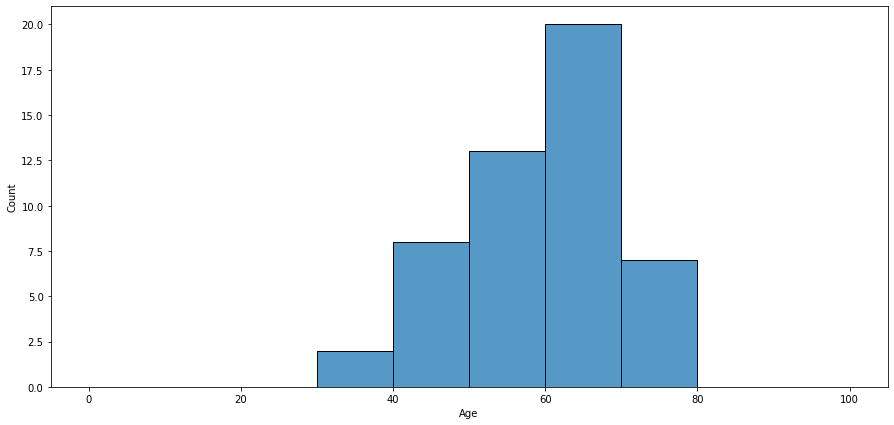

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(data=filtered_brats_df,x="Age",  binwidth=10, binrange=(0,100))

In [ ]:
filtered_df[["IXI_ID", "SEX_ID"]].head()

,IXI_ID,SEX_ID
0,60,1
1,428,2
2,429,2
3,430,2
4,431,2


In [ ]:
filtered_brats_df.columns 

Index(['Brats20ID', 'Age', 'Survival_days', 'Extent_of_Resection',
       'our_brats_id', 'scanner_name', 'contrast_type', 'file_path',
       'age_disc'],
      dtype='object')

In [ ]:
filtered_brats_df.columns = ['IXI_ID', 'AGE', 'Survival_days', 'Extent_of_Resection',
       'our_brats_id', 'scanner_name', 'contrast_type', 'file_path',
       'age_disc']

In [ ]:
concatenated_df = pd.concat(
    objs=[filtered_df[[ "IXI_ID", "AGE", "age_disc", "scanner_name", "contrast_type", "file_path"  ]] , filtered_brats_df[[ "IXI_ID", "AGE", "age_disc", "scanner_name", "contrast_type", "file_path"  ]] ],
    axis=0,
    join="outer",
    ignore_index=True
)

In [ ]:
concatenated_df.describe()

,AGE
count,242.000000
mean,56.284540
std,14.625150
min,24.876112
25%,44.635751
50%,59.961670
75%,67.750171
max,86.318960


In [ ]:
concatenated_df.head()

,IXI_ID,AGE,age_disc,scanner_name,contrast_type,file_path
0,60,30.699521,30-40,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...
1,428,55.540041,50-60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...
2,429,55.540041,50-60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...
3,430,72.005476,70-80,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...
4,431,58.781656,50-60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...


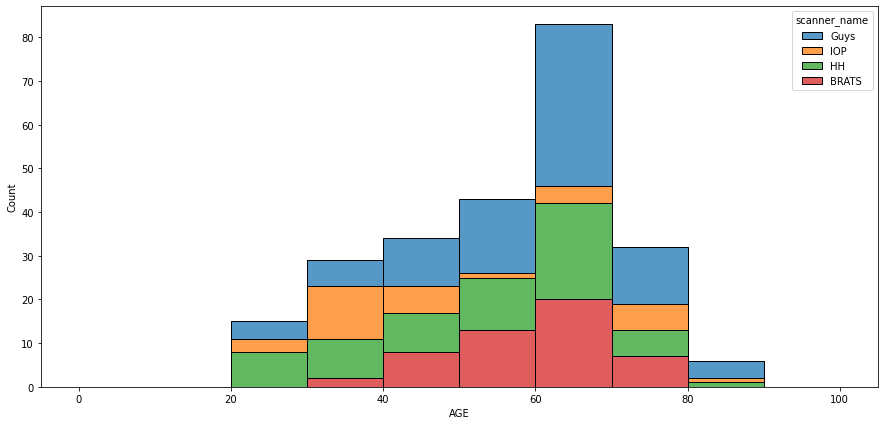

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(data=concatenated_df,x="AGE", hue="scanner_name", multiple="stack", binwidth=10, binrange=(0,100))

# Analyses of datasets

* T1 and T2 are in equal numbers and are of same subject. This would help to visualize contrast related biases in encoder.
* For contrast removal since everything is equal we can shuffle and sample without much problems.

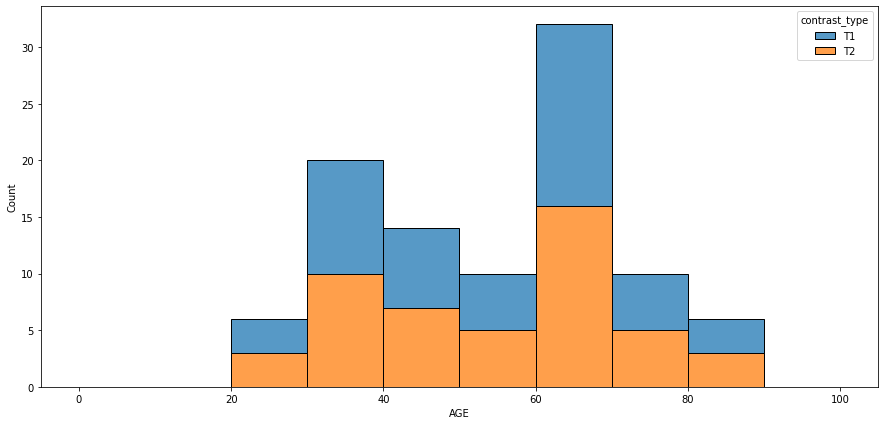

* HH has highest scans at 50 and Guys at 35 rest 10 are with IOP. 
* Guys and HH follow same normal distribution that peaks for age 50-60, whilst IOP has very less data.
* Maybe we need to use IOP only in unlearning or make sure that all scanners image is present in each batch, but for now we will simply shuffle and pick without much consideration
* Hence loss function must be weighted accordingly.


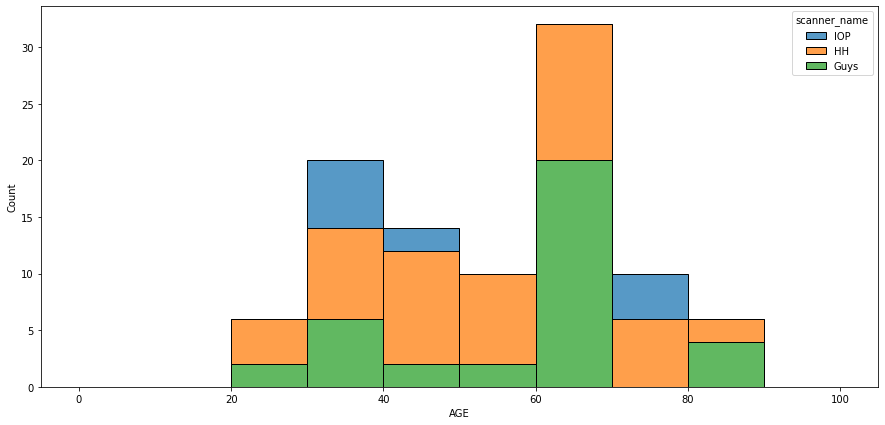


Females - 0, Male - 1

* There are around 45 males and 55 females in the dataset and they seem to have spread equally across ages.
* There are no women for age 60-70 and no men for early age MRI. But these numbers are small and peaks coincide at 50-60 years and both men and women have some presence in 40-60 age groups. Hence We will try to uniform random sample across both categories. 


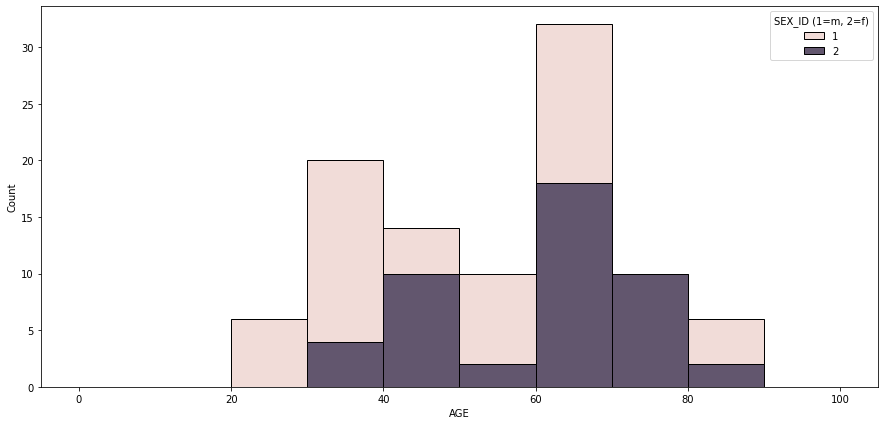

IOP has very few scans and should be handled with care during unlearning according to its age distribution

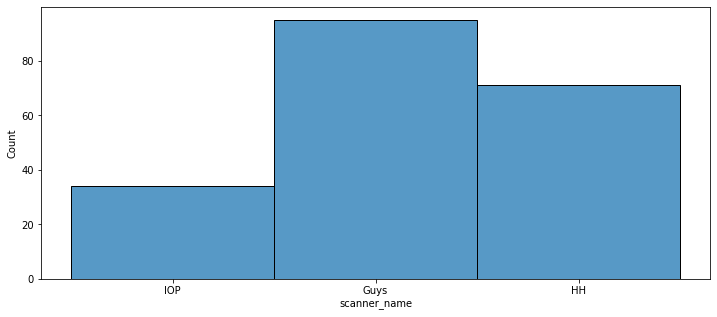

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(data=our_df, x="scanner_name")

As we can see below all 2 scanners Guys and HH have similar distribution and have lot of scans between 50-70 age. In other terms they have almost equal distribution and we do not need to worry about what to keep or not keep in our learning-unlearning datasets. 

IOP on the other hand has less scans(40 scans) and most of its scans are from younger people with peak at 30 years. How to choose train and test now as we have two equally distributed datasets and IOP as skewed?

* Pick randomly into train learning, train unlearning and validation bucket from Guys and HH as they seem to be equally distributed.
* From IOP, there are 5 scans between 50-70. Put all of them into train unlearning bucket. We dont need to learn much from these images hence dont add them to learning bucket. These 5 scans are important as they lie in same age range peak as that of Guys, HH so must be used for unlearning.
* From rest of IOP (29 remaining) randomly sample 5 of them into validation. rest 24 of them must be used during training learning.


Use the above while building dataset class



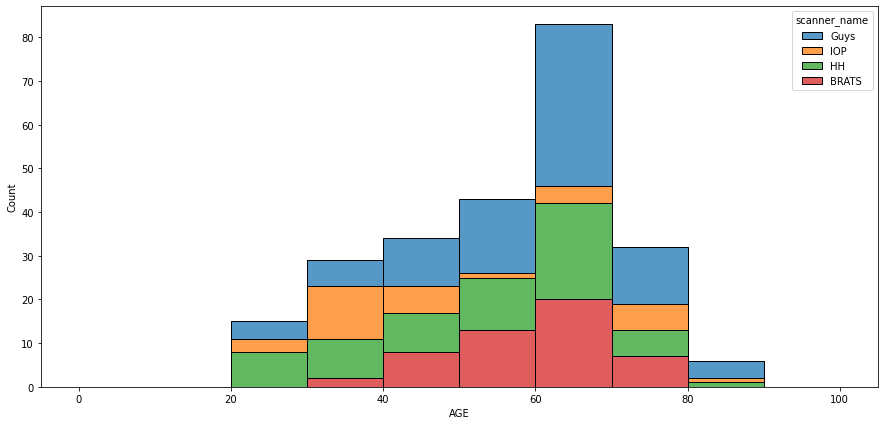

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(data=concatenated_df,x="AGE", hue="scanner_name", multiple="stack", binwidth=10, binrange=(0,100))

As expected both T1 and T2 follow same distribution and has max at 60-70 age, This was expected as T2 has only data from Guys and HH. It doesn't have from IOP.

We will remove IOP data and train once and another time with IOP data.

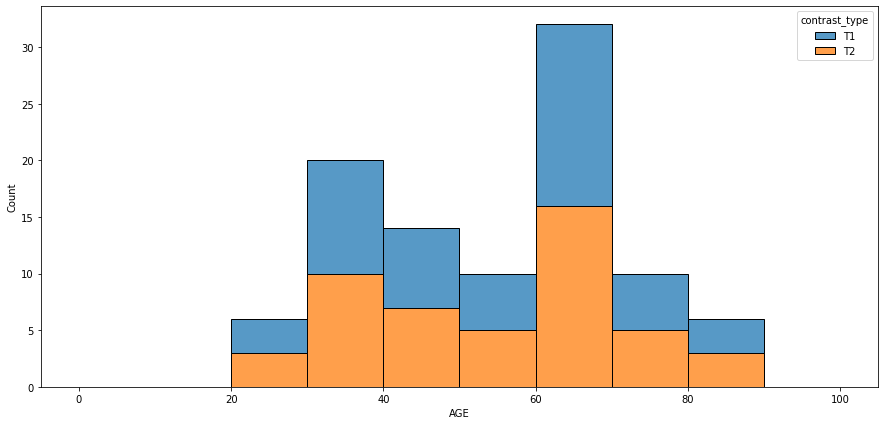

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(data=filtered_df,x="AGE", hue="contrast_type", multiple="stack", binwidth=10, binrange=(0,100))

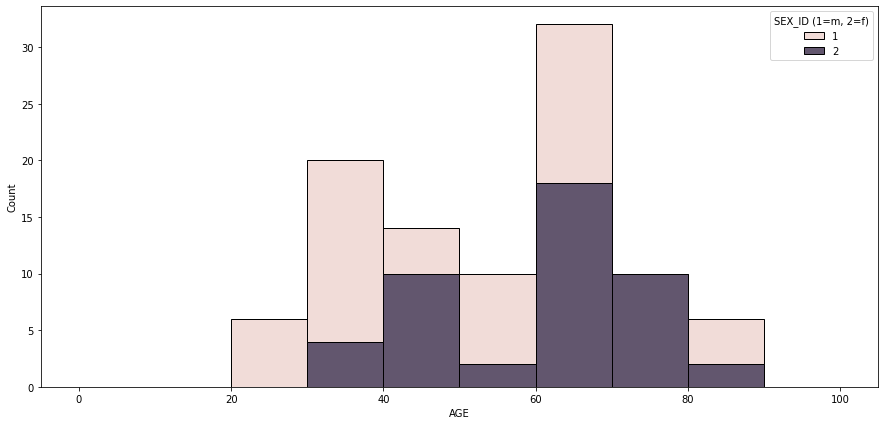

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(data=filtered_df,x="AGE", hue="SEX_ID (1=m, 2=f)", multiple="stack", binwidth=10, binrange=(0,100))

In [ ]:
filtered_df.groupby(["SEX_ID (1=m, 2=f)"]).count()

,IXI_ID,HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,our_ixi_id,scanner_name,contrast_type,file_path,age_disc
"SEX_ID (1=m, 2=f)",,,,,,,,,,,,,,,,
1,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52
2,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46


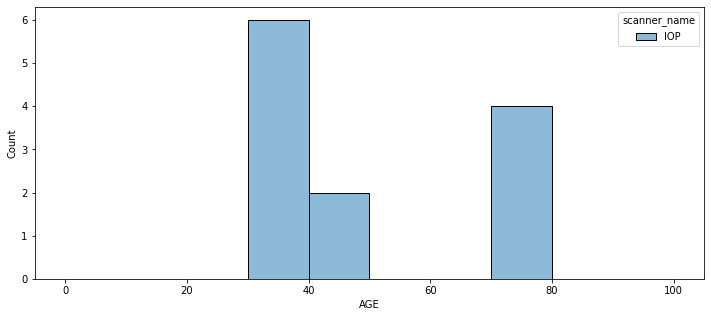

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(data=filtered_df[filtered_df["scanner_name"] == "IOP"],x="AGE", hue="scanner_name", binwidth=10, binrange=(0,100))

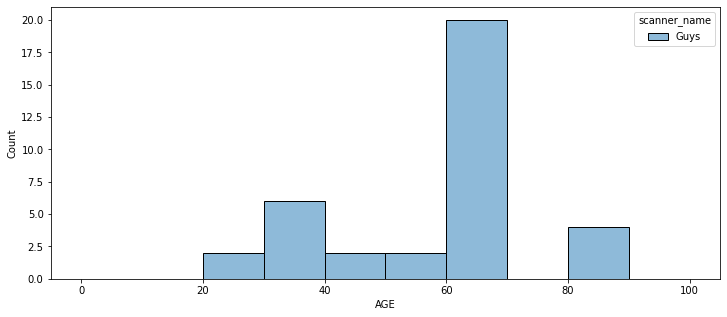

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(data=filtered_df[filtered_df["scanner_name"] == "Guys"],x="AGE", hue="scanner_name", binwidth=10, binrange=(0,100))

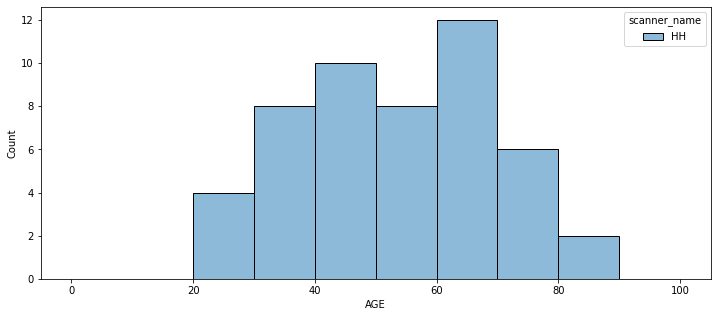

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(data=filtered_df[filtered_df["scanner_name"] == "HH"],x="AGE", hue="scanner_name", binwidth=10, binrange=(0,100))

# Dataset Creation

* We are aiming for contrast removal and make sure we have almost equal number of T1, T2 in training, validation

* We would also be doing scanner removal for 50 T1 images where around 7 are from IOP, 25 from HH and 18 from Guys. The loss function must be weighted accordingly.

* We don't need a separate unlearning dataset that is different than learning dataset as we have labels for all and numbers are equal.

* We can see that we have 30 T2 and 45 T1 in training almost 40/60 split which could be treated as almost equal number of labels. We can simply shuffle the images and no need to have special considerations for having one of each in every batch.

* The dataset has only 32 slices in Z direction as mentioned in paper. This helps to reduce compute required although with 64 slices one can improve accuracy and converge faster.

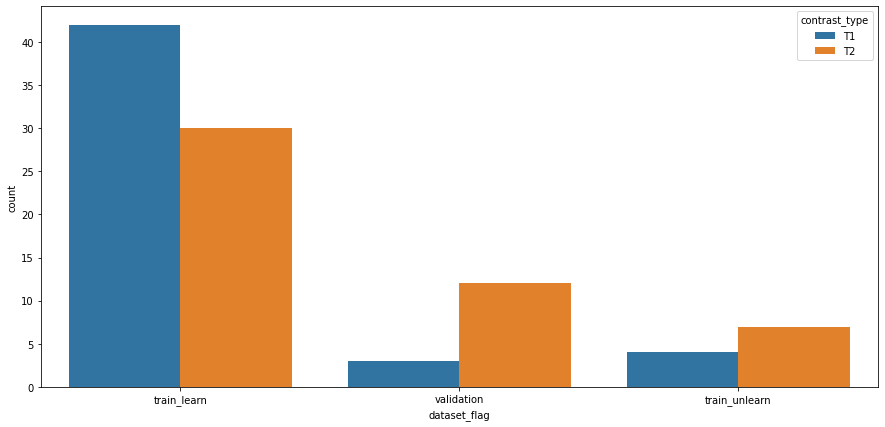

In [ ]:
def place_into_buckets(age_disc, scanner_name, contrast_type, SEX_ID):
    """ 
    flag 0,1,2 = learn, unlearn, validation
    - From IOP if its between 50-70 put it in unlearn bucket
    - From IOP if its not between 50-70 put it learn and validation bucket with probs of 0.75 and 0.25
    - From others put it in learn with 0.4, in unlearn with 0.3, in validation with 0.3 prob
    """
    """
    - After addition of T2 images we removed the above conditionals,
    - We will remove IOP from dataset as its distribution is completely different than other two.
    - Use flag = 3 as no train/test/validation bucket to place IOP data.
    - Later another test IOP will be added and above conditionals will be used
    """

    # if ((scanner_name == "IOP")):
    #   flag = np.random.choice(a=[0, 1, 2], p=[0.8, 0.1, 0.1] )
    # if ((contrast_type == "T2")):
    #   #flag = np.random.choice(a=[0, 1, 2], p=[0.8, 0.1, 0.1] )
    #   flag = -1
    # else:
    #   flag = np.random.choice(a=[0, 1, 2], p=[0.94, 0.01, 0.05] )

    flag = np.random.choice(a=[0, 1, 2], p=[0.75, 0.05, 0.2] )

    if (flag == 0):
      return "train_learn"
    elif (flag == 1):
      return "train_unlearn"
    elif (flag == 2):
        return "validation"
    else:
      return "nouse"

    # if ((scanner_name == "IOP") and (age_disc in ["50-60", "60-70"]) ):
    #   flag = 1
    # elif ((scanner_name == "IOP") and (age_disc not in ["50-60", "60-70"]) ):
    #   flag = np.random.choice(a=[0, 2], p= [0.75, 0.25])
    # else:
    #   flag = np.random.choice(a=[0, 1, 2], p=[0.5, 0.3, 0.2] )

    # if (flag == 0):
    #   return "train_learn"
    # elif (flag == 1):
    #   return "train_unlearn"
    # else:
    #     return "validation"
        


In [ ]:
def categorize_scanner( scanner_name):
    """ 
    flag 0,1,2 = IOP, Guys, HH
    """
    
    if (scanner_name == "HH") :
      flag = 0
    elif (scanner_name == "Guys"):
      flag = 1
    elif (scanner_name == "IOP"):
      flag = 2
    else:
      flag = 3

    return flag

In [ ]:
def categorize_contrast(contrast_type):
    """ 
    flag 0,1 = T1, T2
    
    """
    
    if (contrast_type == "T1") :
      flag = 0
    elif (contrast_type == "T2"):
      flag = 1
    else:
      flag = -1

    return flag

In [ ]:
def categorize_sex( SEX_ID):
    """ 
    flag 1,2 = F, M
    """
    
    if (SEX_ID == 1) :
      flag = 0
    elif (SEX_ID == 2):
      flag = 1
    else:
      flag = -1

    return flag

In [ ]:
labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90", "90-100"]

In [ ]:
def categorize_age( AGE):
    # print(AGE)
    if (AGE == "0-10") :
      flag = 0
    elif (AGE == "10-20"):
      flag = 1
    elif (AGE == "20-30"):
      flag = 2
    elif (AGE == "30-40"):
      flag = 3    
    elif (AGE == "40-50"):
      flag = 4
    elif (AGE == "50-60"):
      flag = 5
    elif (AGE == "60-70"):
      flag = 6    
    elif (AGE == "70-80"):
      flag = 7   
    elif (AGE == "80-90"):
      flag = 8
    elif (AGE == "90-100"):
      flag = 9
    else:
      flag = -1

    return flag

In [ ]:
concatenated_df[concatenated_df["AGE"].isnull() == True]

,IXI_ID,AGE,age_disc,scanner_name,contrast_type,file_path
8,435,NaN,NaN,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...
171,623,NaN,NaN,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...


In [ ]:
concatenated_df['AGE'] = concatenated_df['AGE'].fillna((concatenated_df['AGE'].mean()))

In [ ]:
concatenated_df[concatenated_df["AGE"].isnull() == True]

,IXI_ID,AGE,age_disc,scanner_name,contrast_type,file_path


In [ ]:
concatenated_df['dataset_flag'] = concatenated_df.apply(lambda x: place_into_buckets(x['age_disc'],x['scanner_name'], x['contrast_type'],"M" ),axis=1) #x["SEX_ID"]

In [ ]:
concatenated_df["scanner_flag"] = concatenated_df.apply(lambda x: categorize_scanner(x['scanner_name']),axis=1)

In [ ]:
concatenated_df["contrast_flag"] = concatenated_df.apply(lambda x: categorize_contrast(x['contrast_type']),axis=1)

In [ ]:
concatenated_df["age_flag"] = concatenated_df.apply(lambda x: categorize_age(x['age_disc']),axis=1)

In [ ]:
concatenated_df["sex_flag"] = concatenated_df.apply(lambda x: categorize_sex(x['SEX_ID']),axis=1)

In [ ]:
concatenated_df = concatenated_df[concatenated_df["age_flag"] != -1]

In [ ]:
concatenated_df.head()

,IXI_ID,AGE,age_disc,scanner_name,contrast_type,file_path,dataset_flag,scanner_flag,contrast_flag,age_flag
0,60,30.699521,30-40,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,validation,1,0,3
1,428,55.540041,50-60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,validation,1,0,5
2,429,55.540041,50-60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,1,0,5
3,430,72.005476,70-80,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,validation,2,0,7
4,431,58.781656,50-60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,1,0,5


In [ ]:
concatenated_df.describe()

,AGE,scanner_flag,contrast_flag,age_flag
count,242.000000,242.000000,242.0,242.000000
mean,56.284540,1.272727,0.0,5.115702
std,14.625150,1.081723,0.0,1.506225
min,24.876112,0.000000,0.0,2.000000
25%,44.635751,0.000000,0.0,4.000000
50%,59.961670,1.000000,0.0,5.500000
75%,67.750171,2.000000,0.0,6.000000
max,86.318960,3.000000,0.0,8.000000


In [ ]:
concatenated_df.value_counts(["scanner_name"])

scanner_name
Guys            92
HH              67
BRATS           50
IOP             33
dtype: int64

In [ ]:
concatenated_df.value_counts(["age_flag"])

age_flag
6           83
5           43
4           34
7           32
3           29
2           15
8            6
dtype: int64

Almost equal number of men and women in train set.

Although there are 55 womena and 45 men in whole dataset, loss function must be weighted accordingly

In [ ]:
plt.figure(figsize=(15, 7))
sns.countplot(x="dataset_flag", data=concatenated_df, hue="sex_flag")

From below count plot it is evident that

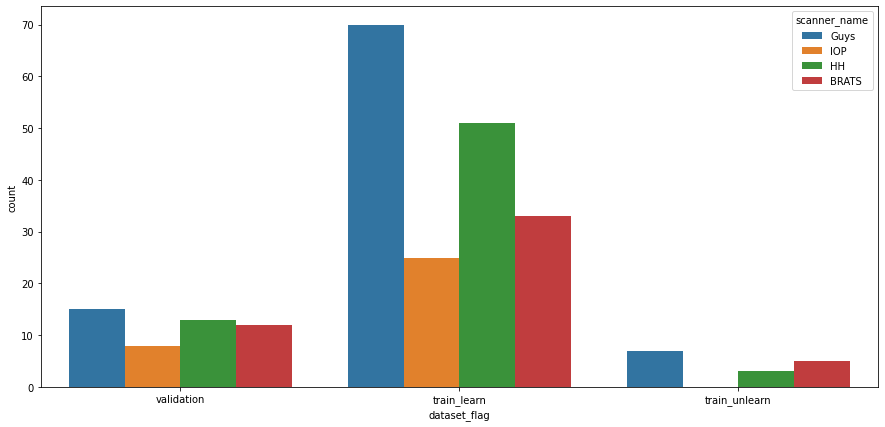

In [ ]:
plt.figure(figsize=(15, 7))
sns.countplot(x="dataset_flag", data=concatenated_df, hue="scanner_name")

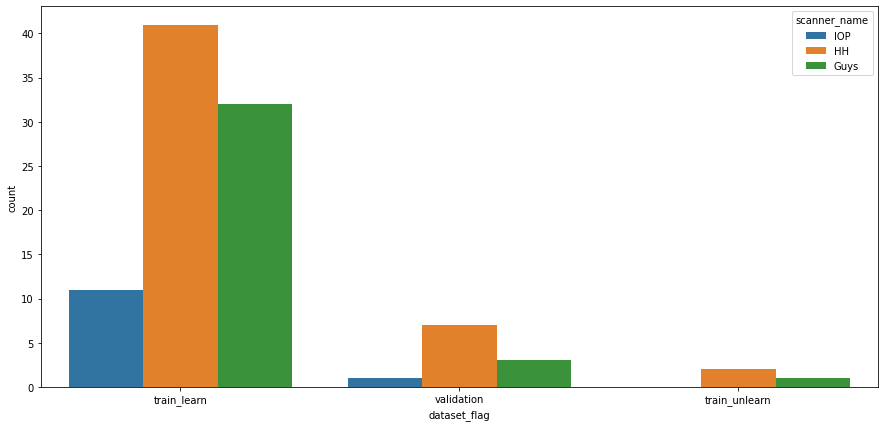

In [ ]:
plt.figure(figsize=(15, 7))
sns.countplot(x="dataset_flag", data=filtered_df, hue="scanner_name")

In [ ]:
plt.figure(figsize=(15, 7))
sns.countplot(x="dataset_flag", data=filtered_df, hue="contrast_type")

<Figure size 1440x720 with 0 Axes>

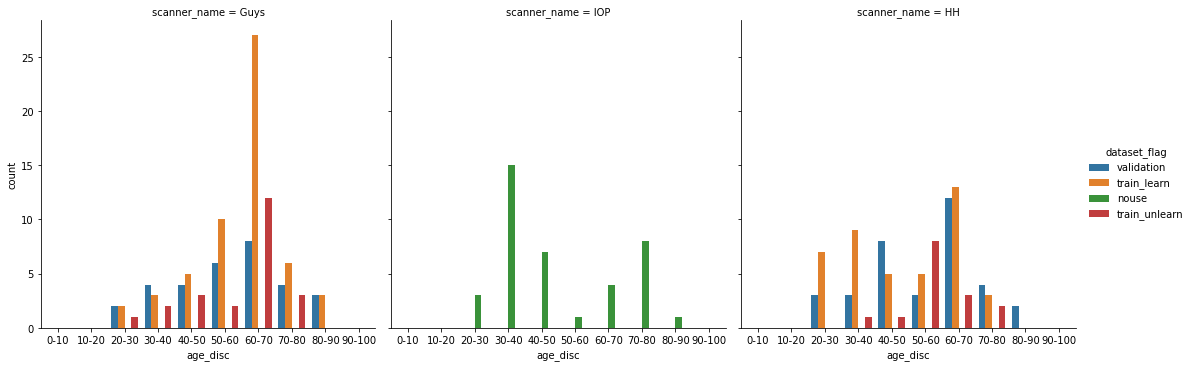

In [ ]:
plt.figure(figsize=(20, 10))
sns.catplot(x="age_disc", data=filtered_df, col="scanner_name", hue="dataset_flag", kind="count")

<Figure size 1440x720 with 0 Axes>

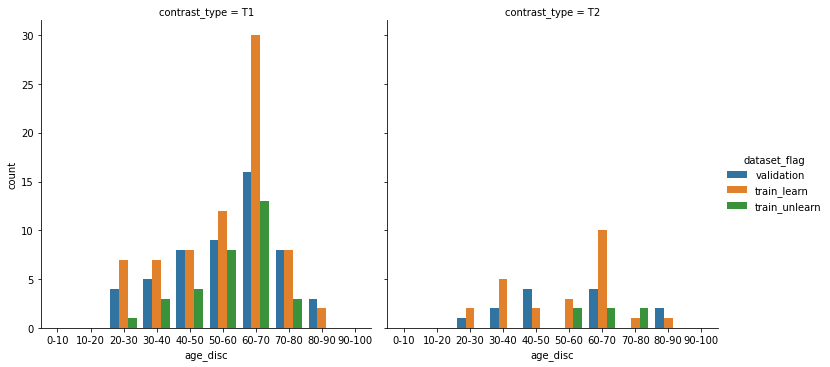

In [ ]:
plt.figure(figsize=(20, 10))
sns.catplot(x="age_disc", data=filtered_df[filtered_df["scanner_name"] != "IOP"], col="contrast_type", hue="dataset_flag", kind="count")

In [ ]:
filtered_df.count()

IXI_ID              98
SEX_ID              98
HEIGHT              98
WEIGHT              98
ETHNIC_ID           98
MARITAL_ID          98
OCCUPATION_ID       98
QUALIFICATION_ID    98
DOB                 98
DATE_AVAILABLE      98
STUDY_DATE          98
AGE                 98
our_ixi_id          98
scanner_name        98
contrast_type       98
file_path           98
age_disc            98
dataset_flag        98
scanner_flag        98
contrast_flag       98
sex_flag            98
dtype: int64

In [ ]:
train_learn_df = filtered_df[filtered_df["dataset_flag"] == "train_learn"]
train_unlearn_df = filtered_df[filtered_df["dataset_flag"] == "train_unlearn"]
validation_df = filtered_df[filtered_df["dataset_flag"] == "validation"]

In [ ]:
train_learn_df = concatenated_df[concatenated_df["dataset_flag"] == "train_learn"]
train_unlearn_df = concatenated_df[concatenated_df["dataset_flag"] == "train_unlearn"]
validation_df = concatenated_df[concatenated_df["dataset_flag"] == "validation"]

In [ ]:
print(train_learn_df.shape)
print(train_unlearn_df.shape)
print(validation_df.shape)

(179, 10)
(15, 10)
(48, 10)


In [ ]:
train_learn_df[train_learn_df["scanner_flag"] == 2]

,IXI_ID,AGE,age_disc,scanner_name,contrast_type,file_path,dataset_flag,scanner_flag,contrast_flag,age_flag
6,433,73.900068,70-80,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,2,0,7
7,434,67.241615,60-70,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,2,0,6
15,442,61.366188,60-70,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,2,0,6
34,462,75.077344,70-80,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,2,0,7
35,463,70.143737,70-80,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,2,0,7
36,464,86.318960,80-90,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,2,0,8
40,469,32.837782,30-40,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,2,0,3
41,470,35.983573,30-40,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,2,0,3
43,474,34.012320,30-40,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,2,0,3
46,477,46.425736,40-50,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,2,0,4


In [ ]:
z_64_slices = []
for i in range(0, 128, 2):
  z_64_slices.append(i)

In [ ]:
z_32_slices = []
for i in range(0, 128, 4):
  z_32_slices.append(i)

In [ ]:
z_64_slices[0:4]

[0, 2, 4, 6]

In [ ]:
def load_4D(name, sf):
        #model_np = np.zeros(shape=(128, 128, 128))
        resamplng_shape = (128, 128, 128)
        X_nb = nb.load(name)
        #print(X_nb)
        X_np = X_nb.dataobj
        #print(X_np)
        x_dim, y_dim, z_dim = X_np.shape
        X_np = np.array(X_np)
        # print(sf)
        #use min to remove error due to normalization
        model_np = np.full((128, 128, 128), X_np.min())

        #print(x_dim, y_dim, z_dim)
        x_ltail = (resamplng_shape[0] - x_dim)//2 
        y_ltail = (resamplng_shape[1] - y_dim)//2
        z_ltail = (resamplng_shape[2] - z_dim)//2
        #print(x_ltail,y_ltail,z_ltail)

        x_rtail = resamplng_shape[0] - x_ltail - 1
        y_rtail = resamplng_shape[1] - y_ltail - 1
        if (sf == 3):
          z_rtail = resamplng_shape[2] - z_ltail
        else:
          z_rtail = resamplng_shape[2] - z_ltail - 1
        #print(x_rtail,y_rtail,z_rtail)
        model_np[x_ltail:x_rtail, y_ltail:y_rtail, z_ltail:z_rtail] = X_np[:, :, :]
        #z_32_slices = [3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 99, 103, 107, 111, 115, 119, 123, 127]
        model_np = model_np[:, :, z_32_slices]
        model_np = np.expand_dims(model_np, axis=0)
        #print(model_np.shape)
        #print(model_np)
        return model_np

def imgnorm(N_I,index1=0.0001,index2=0.0001):
    I_sort = np.sort(N_I.flatten())
    I_min = I_sort[int(index1*len(I_sort))]
    I_max = I_sort[-int(index2*len(I_sort))]
    N_I =1.0*(N_I-I_min)/(I_max-I_min)
    N_I[N_I>1.0]=1.0
    N_I[N_I<0.0]=0.0
    N_I2 = N_I.astype(np.float32)
    return N_I2

def Norm_Zscore(img):
    img= (img-np.mean(img))/np.std(img) 
    return img

def save_img(I_img,savename):
    I2 = sitk.GetImageFromArray(I_img,isVector=False)
    sitk.WriteImage(I2,savename)

In [ ]:
class Dataset(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, df = filtered_df, iterations =1, norm=True):
        self.df = df #[ df["scanner_flag"] == 3]
        self.norm = norm
        self.iterations = iterations
        
  def __len__(self):
        'Denotes the total number of samples'
        return self.df.shape[0] * self.iterations

  def __getitem__(self, step):
        'Generates one sample of data'
        # index_pair = np.random.permutation(len(self.names)) [0:4]
        """
        fp = filtered_df["file_path"].iloc[step]
        sn = filtered_df["scanner_name"].iloc[step]
        dafl = filtered_df["dataset_flag"].iloc[step]
        agdi = filtered_df["age_disc"].iloc[step]
        """

        

        fp = self.df["file_path"].iloc[step]
        sf = self.df["scanner_flag"].iloc[step]
        age = self.df["AGE"].iloc[step]
        cf = self.df["contrast_flag"].iloc[step]
        af = self.df["age_flag"].iloc[step]
        # sexf = self.df["sex_flag"].iloc[step]

        img = load_4D(fp, sf)   
        
        if self.norm:
            # return  Norm_Zscore(imgnorm(img_A)) , Norm_Zscore(imgnorm(img_B))
            return  imgnorm(img), age, sf, cf, af #, sexf
        else:
            return img, age, sf, cf, af #, sexf

In [ ]:
training_generator = Data.DataLoader(Dataset(train_learn_df, 1, True), batch_size=10,shuffle=True, drop_last=True)

In [ ]:
for  X, Y, Z, A, B in training_generator:
  print(torch.max(X))
  print(X.shape)
  print(Y, Z, A, B)
  del X, Y, Z, A, B
  break

tensor(1.)
torch.Size([10, 1, 128, 128, 32])
tensor([59.2635, 44.4160, 64.7502, 42.9897, 68.1232, 66.8583, 68.2850, 46.4257,
        39.0680, 65.6674], dtype=torch.float64) tensor([1, 3, 1, 1, 1, 1, 3, 2, 3, 1]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor([5, 4, 6, 4, 6, 6, 6, 4, 3, 6])


# Model Building

* Initialize Age predictor network which is VGG based. CNN output of VGG is falltened into Fully connected embeddings
* We have regressor network that takes the embeddings and predicts age
* The domain predictor network output are categories of domains that needs to be removed

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.feature = nn.Sequential()      # Define the feature extractor
        self.feature.add_module('f_conv1_1', nn.Conv3d(1, 32, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_1_1', nn.ReLU(True))
        self.feature.add_module('f_bn1_1', nn.BatchNorm3d(32))
        self.feature.add_module('f_conv1_2', nn.Conv3d(32, 32, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_1_2', nn.ReLU(True))
        self.feature.add_module('f_bn1_2', nn.BatchNorm3d(32))
        self.feature.add_module('f_pool1', nn.MaxPool3d(2))

        self.feature.add_module('f_conv2_1', nn.Conv3d(32, 64, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_2_1', nn.ReLU(True))
        self.feature.add_module('f_bn2_1', nn.BatchNorm3d(64))
        self.feature.add_module('f_conv2_2', nn.Conv3d(64, 64, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_2_2', nn.ReLU(True))
        self.feature.add_module('f_bn2_2', nn.BatchNorm3d(64))
        self.feature.add_module('f_pool2', nn.MaxPool3d(2))

        self.feature.add_module('f_conv3_1', nn.Conv3d(64, 64, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_3_1', nn.ReLU(True))
        self.feature.add_module('f_bn3_1', nn.BatchNorm3d(64))
        self.feature.add_module('f_conv3_2', nn.Conv3d(64, 64, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_3_2', nn.ReLU(True))
        self.feature.add_module('f_bn3_2', nn.BatchNorm3d(64))
        self.feature.add_module('f_pool3', nn.MaxPool3d(2))

        self.feature.add_module('f_conv4_1', nn.Conv3d(64, 96, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_4_1', nn.ReLU(True))
        self.feature.add_module('f_bn4_1', nn.BatchNorm3d(96))
        self.feature.add_module('f_conv4_2', nn.Conv3d(96, 96, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_4_2', nn.ReLU(True))
        self.feature.add_module('f_bn4_2', nn.BatchNorm3d(96))
        self.feature.add_module('f_conv4_3', nn.Conv3d(96, 96, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_4_3', nn.ReLU(True))
        self.feature.add_module('f_bn4_3', nn.BatchNorm3d(96))
        self.feature.add_module('f_pool4', nn.MaxPool3d(2))

        self.feature.add_module('f_conv5_1', nn.Conv3d(96, 96, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_5_1', nn.ReLU(True))
        self.feature.add_module('f_bn5_1', nn.BatchNorm3d(96))
        self.feature.add_module('f_conv5_2', nn.Conv3d(96, 96, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_5_2', nn.ReLU(True))
        self.feature.add_module('f_bn5_2', nn.BatchNorm3d(96))
        self.feature.add_module('f_conv5_3', nn.Conv3d(96, 96, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_5_3', nn.ReLU(True))
        self.feature.add_module('f_bn5_3', nn.BatchNorm3d(96))
        self.feature.add_module('f_pool5', nn.MaxPool3d(2))

        self.feature.add_module('f_conv6_1', nn.Conv3d(96, 96, kernel_size=(3,3,1), padding=1))
        self.feature.add_module('f_relu_6_1', nn.ReLU(True))
        self.feature.add_module('f_bn6_1', nn.BatchNorm3d(96))
        self.feature.add_module('f_conv6_2', nn.Conv3d(96, 96, kernel_size=(3,3,1), padding=1))
        self.feature.add_module('f_relu_6_2', nn.ReLU(True))
        self.feature.add_module('f_bn6_2', nn.BatchNorm3d(96))
        self.feature.add_module('f_conv6_3', nn.Conv3d(96, 96, kernel_size=(3,3,1), padding=1))
        self.feature.add_module('f_relu_6_3', nn.ReLU(True))
        self.feature.add_module('f_bn6_3', nn.BatchNorm3d(96))
        self.feature.add_module('f_pool6', nn.MaxPool3d(2))

        """
        self.feature.add_module('f_conv7_1', nn.Conv3d(96, 96, kernel_size=(3,3,1), padding=1))
        self.feature.add_module('f_relu_7_1', nn.ReLU(True))
        self.feature.add_module('f_bn7_1', nn.BatchNorm3d(96))
        self.feature.add_module('f_features', nn.MaxPool3d(2))
        """
        

        self.embeddings = nn.Sequential()
        self.embeddings.add_module('r_fc1', nn.Linear(1152, 96))
        self.embeddings.add_module('r_relu1', nn.ReLU(True))


    def forward(self, x):
        batch_size = x.shape[0]
        feats = self.feature(x)
        #print(feature.shape)

        #Changed below code from feature.view(-1, 1152)
        feats = feats.view(batch_size, -1)
        #print(feature.shape)
        feature_embedding = self.embeddings(feats)
        return feature_embedding

class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()

        self.regressor = nn.Sequential()
        self.regressor.add_module('r_fc2', nn.Linear(96, 32))
        self.regressor.add_module('r_relu2', nn.ReLU(True))
        self.regressor.add_module('r_pred', nn.Linear(32, 1))
        self.regressor.add_module('r_sigmoid', nn.Sigmoid())

    def forward(self, x):
        regression = self.regressor(x)
        return regression

class DomainPredictor(nn.Module):
    def __init__(self, nodes=3):
        super(DomainPredictor, self).__init__()
        self.nodes = nodes
        self.domain = nn.Sequential()
        self.domain.add_module('d_fc2', nn.Linear(96, 32))
        self.domain.add_module('d_relu2', nn.ReLU(True))
        self.domain.add_module('r_dropout', nn.Dropout3d(p=0.2))
        self.domain.add_module('d_fc3', nn.Linear(32, nodes))
        self.domain.add_module('d_pred', nn.Softmax(dim=1))

    def forward(self, x):
        domain_pred = self.domain(x)
        return domain_pred


In [ ]:
#del encoder, regressor, domain_predictor
#torch.cuda.empty_cache()

encoder = Encoder().to("cuda")
regressor = Regressor().to("cuda")
domain_predictor = DomainPredictor(nodes=3).to("cuda")

RuntimeError: ignored

In [ ]:
encoder = Encoder()
regressor = Regressor()
domain_predictor = DomainPredictor(nodes=3)

In [ ]:
del encoder, regressor, domain_predictor
torch.cuda.empty_cache()

In [ ]:
for  X, Y, Z, A in training_generator:
  #X = X.to("cuda")

  print(X.shape)
  enc_feats = encoder(X)
  print(enc_feats.shape)
  regressor_op = regressor(enc_feats)
  print(regressor_op.shape)
  dp_op = domain_predictor(enc_feats)
  print(dp_op.shape)
  del enc_feats, regressor_op, dp_op, X , Y, Z, A
  torch.cuda.empty_cache()
  break

torch.Size([7, 1, 128, 128, 32])
torch.Size([7, 96, 2, 2, 3])
torch.Size([7, 96])
torch.Size([7, 1])
torch.Size([7, 3])


# Loss Functions and Miscellaneous

* Initialize confusion loss that aims to confuse the domain predictor by trying to make its softmax output equal

In [ ]:
class confusion_loss(nn.Module):
    def __init__(self, task=0):
        super(confusion_loss, self).__init__()
        self.task = task

    def forward(self, x, target):
        # We only care about x
        #print(x)
        log = torch.log(x)
        #print(log)
        log_sum = torch.sum(log, dim=1)
        #print(log_sum)
        normalised_log_sum = torch.div(log_sum,  x.size()[1])
        #print(normalised_log_sum)
        loss = torch.mul(torch.sum(normalised_log_sum, dim=0), -1)
        return loss

In [ ]:
criteron = nn.MSELoss()     # Change this to DANN_loss normal
domain_criterion = nn.CrossEntropyLoss()
contrast_criterion = nn.CrossEntropyLoss()
cnf_loss = confusion_loss()
sftmax = nn.Softmax(dim=1)
mytnsr = torch.randn(size=(3, 2))
mytnsr_same = torch.Tensor([[0.6, 0.4], [0.4, 0.6], [0.6, 0.4]])
mytnsr_opposite = torch.Tensor([[0.8, 0.2], [0.2, 0.8], [0.8, 0.2]])
mytnsr1 = torch.Tensor([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]])
labels = torch.Tensor([[0, 1], [1, 0], [0, 1]])
#labels = torch.empty(3, dtype=torch.long).random_(2)
#print(mytnsr)
#print(sftmax(mytnsr))
#print(labels)

#print(cnf_loss(sftmax(mytnsr), labels))
print(cnf_loss(sftmax(mytnsr_same), labels))
print()
print(cnf_loss(sftmax(mytnsr_opposite), labels))
print()
print(cnf_loss(sftmax(mytnsr1), labels))

tensor(2.0944)

tensor(2.2125)

tensor(2.0794)


In [ ]:
criteron( torch.Tensor( [[10.0], [1.0], [6.0]] ),  torch.Tensor( [[5.0], [0.0], [10.0]]  ) )

tensor(14.)

# contrast classification

* Just building a simple contrast classifier to test out whether there is enough bias of contrast that could be removed. We are able to clearly differentiate between contrasts with almost 100% accuracy. This means there is enough bias of contrast


In [ ]:
del encoder_cc, contrast_predictor_cc
torch.cuda.empty_cache()

In [ ]:
encoder_cc = Encoder().to("cuda")
contrast_predictor_cc = DomainPredictor(nodes=2).to("cuda")

In [ ]:
contrast_criterion_loss_cc = nn.CrossEntropyLoss()
lr=1e-4

In [ ]:
optimizer = torch.optim.Adam(list(encoder_cc.parameters()) + list(contrast_predictor_cc.parameters()) , lr=lr ) 
model_dir = '/content/drive/My Drive/Image_Registration_Project/mri_harmonization'

LOSS_PATH = "/content/drive/My Drive/Image_Registration_Project/mri_harmonization"
if not os.path.isdir(model_dir):
  os.mkdir(model_dir)


In [ ]:
checkpoint = torch.load("/content/drive/My Drive/Image_Registration_Project/mri_harmonization/just_encoder.pth")
encoder_wou.load_state_dict(checkpoint["encoder_wou_model"])
regressor_wou.load_state_dict(checkpoint["regressor_wou_model"])

encoder_wou.eval()
regressor_wou.eval()

In [ ]:
def run_one_epoch(epoch = 1):
  example_number = 0
  co_loss_lst = []
  contrast_accuracy_lst = []
  for X, Y, Z, A in training_generator:
    X = X.to("cuda").float()
    Y = Y.to("cuda").float()
    Z = Z.to("cuda").long()
    A = A.to("cuda").long()
    
    encoder_feats = encoder_cc(X)

    contrast_op_tnsr = contrast_predictor_cc(encoder_feats)
    co_loss = contrast_criterion_loss_cc(contrast_op_tnsr, A)

    optimizer.zero_grad()          
    co_loss.backward() 
    optimizer.step()

    co_loss_lst.append(co_loss.detach().cpu().numpy().item())
    contrast_op_np = np.argmax(contrast_op_tnsr.detach().cpu().numpy(), axis=1)

    contrast_acc = accuracy_score(A.detach().cpu().numpy(), contrast_op_np)
    contrast_accuracy_lst.append(contrast_acc.item())
    
    del X, Y, Z, A, encoder_feats, contrast_op_tnsr
    torch.cuda.empty_cache()
    example_number = example_number + 1

  if (epoch%2 == 0):
      modelname = model_dir + '/' + "just_cc_" + str(epoch+0) + '.pth'
      torch.save({"encoder_cc_model": encoder_cc.state_dict(), "contrast_predictor_cc": contrast_predictor_cc.state_dict()}, modelname)
      print("epoch: {}".format(epoch))

      print("Losses for contrast : {}".format( sum(contrast_accuracy_lst)/len(contrast_accuracy_lst)))
      print("Saving model checkpoints")
      print("======= =============== ===========")
      print()
  
  return co_loss_lst, contrast_accuracy_lst



In [ ]:
epochs = 21
co_lst = []
c_lst = []

for e in range(epochs):
  co, c = run_one_epoch(epoch=e)
  co_lst.append(co)
  c_lst.append(c)

epoch: 0
Losses for contrast : 1.0
Saving model checkpoints
======= =============== ===========

epoch: 2
Losses for contrast : 1.0
Saving model checkpoints
======= =============== ===========

epoch: 4
Losses for contrast : 1.0
Saving model checkpoints
======= =============== ===========

epoch: 6
Losses for contrast : 1.0
Saving model checkpoints
======= =============== ===========

epoch: 8
Losses for contrast : 1.0
Saving model checkpoints
======= =============== ===========

epoch: 10
Losses for contrast : 1.0
Saving model checkpoints
======= =============== ===========

epoch: 12
Losses for contrast : 0.987012987012987
Saving model checkpoints
======= =============== ===========

epoch: 14
Losses for contrast : 1.0
Saving model checkpoints
======= =============== ===========

epoch: 16
Losses for contrast : 1.0
Saving model checkpoints
======= =============== ===========

epoch: 18
Losses for contrast : 0.9740259740259741
Saving model checkpoints
======= =============== =========

# Scanner classification

* Just building a simple scanner classifier to test out whether there is enough bias of contrast that could be removed. We are able to clearly differentiate between contrasts with almost 90% accuracy.

* This means there is enough scanner information in the system that could be extracted and removed or impact if left alone





In [ ]:
encoder_sc = Encoder().to("cuda")
scanner_predictor_sc = DomainPredictor(nodes=3).to("cuda")

In [ ]:
scanner_criterion_loss_sc = nn.CrossEntropyLoss( weight=torch.Tensor([0.1, 0.3, 0.6]).to("cuda") )
lr=1e-4

In [ ]:
optimizer = torch.optim.Adam(list(encoder_sc.parameters()) + list(scanner_predictor_sc.parameters()) , lr=lr ) 
model_dir = '/content/drive/My Drive/Image_Registration_Project/mri_harmonization'

LOSS_PATH = "/content/drive/My Drive/Image_Registration_Project/mri_harmonization"
if not os.path.isdir(model_dir):
  os.mkdir(model_dir)


In [ ]:
def run_one_epoch(epoch = 1):
  example_number = 0
  sc_loss_lst = []
  scanner_accuracy_lst = []
  for X, Y, Z, A in training_generator:
    X = X.to("cuda").float()
    Y = Y.to("cuda").float()
    Z = Z.to("cuda").long()
    A = A.to("cuda").long()
    
    encoder_feats = encoder_sc(X)

    scanner_op_tnsr = scanner_predictor_sc(encoder_feats)
    sc_loss = scanner_criterion_loss_sc(scanner_op_tnsr, Z)

    optimizer.zero_grad()          
    sc_loss.backward() 
    optimizer.step()

    sc_loss_lst.append(sc_loss.detach().cpu().numpy().item())
    scanner_op_np = np.argmax(scanner_op_tnsr.detach().cpu().numpy(), axis=1)

    scanner_acc = accuracy_score(Z.detach().cpu().numpy(), scanner_op_np)
    scanner_accuracy_lst.append(scanner_acc.item())
    
    del X, Y, Z, A, encoder_feats, scanner_op_tnsr
    torch.cuda.empty_cache()
    example_number = example_number + 1

  if (epoch%2 == 0):
      modelname = model_dir + '/' + "scanner_predictor_" + str(epoch+22) + '.pth'
      torch.save({"encoder_sc_model": encoder_sc.state_dict(), "scanner_predictor_sc": scanner_predictor_sc.state_dict()}, modelname)
      print("epoch: {}".format(epoch+22))

      print("Losses for contrast : {}".format( sum(scanner_accuracy_lst)/len(scanner_accuracy_lst)))
      print("Saving model checkpoints")
      print("======= =============== ===========")
      print()
  
  return sc_loss_lst, scanner_accuracy_lst



In [ ]:
epochs = 11
co_lst = []
c_lst = []

for e in range(epochs):
  co, c = run_one_epoch(epoch=e)
  co_lst.append(co)
  c_lst.append(c)

epoch: 22
Losses for contrast : 0.8857142857142858
Saving model checkpoints
======= =============== ===========

epoch: 24
Losses for contrast : 0.8785714285714284
Saving model checkpoints
======= =============== ===========

epoch: 26
Losses for contrast : 0.8785714285714284
Saving model checkpoints
======= =============== ===========

epoch: 28
Losses for contrast : 0.7500000000000001
Saving model checkpoints
======= =============== ===========

epoch: 30
Losses for contrast : 0.8357142857142857
Saving model checkpoints
======= =============== ===========

epoch: 32
Losses for contrast : 0.9142857142857143
Saving model checkpoints
======= =============== ===========



In [ ]:
co_lst

# Sex classification

* Just building a simple sex classifiewr to see if the network can differentiate between sexes based on images of brain. If yes then there is enough information on sex bias that could be removed. If we see poor accuracy then the information of sex bias is very little and could be ignored maybe.

In [ ]:
encoder_sc = Encoder().to("cuda")
sex_predictor_sc = DomainPredictor(nodes=2).to("cuda")

In [ ]:
sex_criterion_loss_sc = nn.CrossEntropyLoss( weight=torch.Tensor([0.45, 0.55]).to("cuda") )
lr=1e-4

In [ ]:
optimizer = torch.optim.Adam(list(encoder_sc.parameters()) + list(sex_predictor_sc.parameters()) , lr=lr ) 
model_dir = '/content/drive/My Drive/Image_Registration_Project/mri_harmonization'

LOSS_PATH = "/content/drive/My Drive/Image_Registration_Project/mri_harmonization"
if not os.path.isdir(model_dir):
  os.mkdir(model_dir)



In [ ]:
def run_one_epoch(epoch = 1):
  example_number = 0
  sex_loss_lst = []
  sex_accuracy_lst = []
  for X, Y, Z, A, B in training_generator:
    X = X.to("cuda").float()
    Y = Y.to("cuda").float()
    Z = Z.to("cuda").long()
    A = A.to("cuda").long()
    B = B.to("cuda").long()
    
    encoder_feats = encoder_sc(X)

    sex_op_tnsr = sex_predictor_sc(encoder_feats)
    sex_loss = sex_criterion_loss_sc(sex_op_tnsr, B)

    optimizer.zero_grad()          
    sex_loss.backward() 
    optimizer.step()

    sex_loss_lst.append(sex_loss.detach().cpu().numpy().item())
    sex_op_np = np.argmax(sex_op_tnsr.detach().cpu().numpy(), axis=1)

    sex_acc = accuracy_score(B.detach().cpu().numpy(), sex_op_np)
    sex_accuracy_lst.append(sex_acc.item())
    
    del X, Y, Z, A, B, encoder_feats, sex_op_tnsr
    torch.cuda.empty_cache()
    example_number = example_number + 1

  if (epoch%2 == 0):
      modelname = model_dir + '/' + "sex_predictor_" + str(epoch+22) + '.pth'
      torch.save({"encoder_sc_model": encoder_sc.state_dict(), "sex_predictor_sc": sex_predictor_sc.state_dict()}, modelname)
      print("epoch: {}".format(epoch+22))

      print("Losses for contrast : {}".format( sum(sex_accuracy_lst)/len(sex_accuracy_lst)))
      print("Saving model checkpoints")
      print("======= =============== ===========")
      print()
  
  return sex_loss_lst, sex_accuracy_lst

In [ ]:
epochs = 21
#co_lst = []
#c_lst = []

for e in range(epochs):
  co, c = run_one_epoch(epoch=e)
  co_lst.append(co)
  c_lst.append(c)

epoch: 22
Losses for contrast : 0.7714285714285715
Saving model checkpoints
======= =============== ===========

epoch: 24
Losses for contrast : 0.8857142857142858
Saving model checkpoints
======= =============== ===========

epoch: 26
Losses for contrast : 0.9142857142857143
Saving model checkpoints
======= =============== ===========

epoch: 28
Losses for contrast : 0.8095238095238095
Saving model checkpoints
======= =============== ===========

epoch: 30
Losses for contrast : 0.7666666666666665
Saving model checkpoints
======= =============== ===========

epoch: 32
Losses for contrast : 0.8
Saving model checkpoints
======= =============== ===========

epoch: 34
Losses for contrast : 0.8428571428571427
Saving model checkpoints
======= =============== ===========

epoch: 36
Losses for contrast : 0.9142857142857143
Saving model checkpoints
======= =============== ===========

epoch: 38
Losses for contrast : 0.8976190476190476
Saving model checkpoints
======= =============== ===========

# Pretraining - Try to learn only age whilst keep an eye on contrast, scanner, sex

* We tried to pretrain the model upto 70 epochs with both scanner and contrast. However scanner classification seems to have almost random chance if not included in pretrainining.
* If scanner is included in pretraining then we can see the separation in feature space. Nicola dinsdale has included scanner prediction inside pretraining, but The originial paper authors of Simultaneous domain unlearning and task learning 2015 have not included. 
* Contrast, we are able to clearly distinguish and get high accuracy both if included or not included in pretraining. Hence we will remove contrast during unlearning.
* This could mean that some biases like scanner should be pulled out of system during pretraining and then unlearned later on. Unlike scanner, Contrast info is clearly separable even without pretraining and much effort.

In [ ]:
del encoder_wou, regressor_wou,  contrast_predictor_wou ,scanner_predictor_wou,
torch.cuda.empty_cache()

In [ ]:
encoder_wou = Encoder().to("cuda")
regressor_wou = Regressor().to("cuda")
age_predictor = DomainPredictor(nodes=10).to("cuda")
contrast_predictor_wou = DomainPredictor(nodes=2).to("cuda")
scanner_predictor_wou = DomainPredictor(nodes=4).to("cuda")


In [ ]:
encoder_wou = Encoder()
regressor_wou = Regressor()
contrast_predictor_wou = DomainPredictor(nodes=2)

In [ ]:
regressor_loss_wou = nn.MSELoss() 
age_criterion_loss_wou = nn.CrossEntropyLoss(weight=torch.Tensor([0.01, 0.01, 0.18, 0.14, 0.13, 0.063, 0.025, 0.14, 0.282, 0.02 ]).to("cuda") ) 
scanner_criterion_loss_wou = nn.CrossEntropyLoss(weight=torch.Tensor([0.2, 0.1, 0.4, 0.3]).to("cuda") ) 
contrast_criterion_loss_wou = nn.CrossEntropyLoss( weight=torch.Tensor([0.45, 0.55]).to("cuda"))
lr=1e-4
#domain_criterion_wou = nn.CrossEntropyLoss()

In [ ]:
#optimizer = torch.optim.Adam(list(encoder_wou.parameters()) + list(regressor_wou.parameters()) + 
#                             list(scanner_predictor_wou.parameters()) + list(contrast_predictor_wou.parameters()) , lr=lr ) 
optimizer = torch.optim.Adam(list(encoder_wou.parameters()) + list(regressor_wou.parameters()) + list(scanner_predictor_wou.parameters()) + list(age_predictor.parameters()) , lr=lr ) 

optimizer_scanner = torch.optim.Adam(list(scanner_predictor_wou.parameters()), lr=lr)
model_dir = '/content/drive/My Drive/Image_Registration_Project/mri_harmonization'

LOSS_PATH = "/content/drive/My Drive/Image_Registration_Project/mri_harmonization"
if not os.path.isdir(model_dir):
  os.mkdir(model_dir)


In [ ]:
checkpoint = torch.load("/content/drive/My Drive/Image_Registration_Project/mri_harmonization/pretrained_age_28.pth")
encoder_wou.load_state_dict(checkpoint["encoder_wou_model"])
regressor_wou.load_state_dict(checkpoint["regressor_wou_model"])

#encoder_wou.eval()
#regressor_wou.eval()

<All keys matched successfully>

In [ ]:
def run_one_epoch(epoch = 1):
  example_number = 0
  age_prediction_mse_lst = []
  total_loss_lst = []
  contrast_accuracy_lst = []
  contrast_loss_lst = []
  scanner_loss_lst = []
  scanner_accuracy_lst = []
  age_bucket_loss_lst = []
  for X, Y, Z, A, B in training_generator:
    X = X.to("cuda").float()
    Y = Y.to("cuda").float()
    Z = Z.to("cuda").long()
    A = A.to("cuda").long()
    B = B.to("cuda").long()
    

    optimizer.zero_grad() 
    encoder_feats = encoder_wou(X)
    predicted_age_bucket = age_predictor(encoder_feats)
    predicted_age_ratio = regressor_wou(encoder_feats)
    predicted_age = torch.mul(predicted_age_bucket, predicted_age_ratio) * 10.0 + 1e-8
    # print(X.shape)
    # print(predicted_age_bucket.shape)
    # print(predicted_age_ratio.shape)
    # print(predicted_age.shape)
    # print(Y.shape)
    # print()
    regressor_loss = regressor_loss_wou(Y, predicted_age)  
    age_bucket_loss = age_criterion_loss_wou(predicted_age_bucket, B)

    scanner_op_tnsr = scanner_predictor_wou(encoder_feats)
    # print(Z.shape)
    # print(scanner_op_tnsr.shape)
    # print(" ========= ========== ========= ")
    scanner_loss = scanner_criterion_loss_wou(scanner_op_tnsr, Z) 

    main_task_loss = regressor_loss + 1.0 * scanner_loss + 1000.0 * age_bucket_loss

    # contrast_op_tnsr = contrast_predictor_wou(encoder_feats)
    # contrast_loss = contrast_criterion_loss_wou(contrast_op_tnsr, A) 
    # main_task_loss = regressor_loss + 100.0 * contrast_loss 

    main_task_loss.backward() 
    optimizer.step()

    # optimizer_contrast.zero_grad() 
    # contrast_op_tnsr = contrast_predictor_wou(encoder_feats.detach())
    # co_loss = contrast_criterion_loss_wou(contrast_op_tnsr, A)        
    # co_loss.backward() 
    # optimizer_contrast.step()

    age_prediction_mse_lst.append(main_task_loss.detach().cpu().numpy().item())
    age_bucket_loss_lst.append(age_bucket_loss.detach().cpu().numpy().item())

    # contrast_loss_lst.append(contrast_loss.detach().cpu().numpy().item())
    # contrast_op_np = np.argmax(contrast_op_tnsr.detach().cpu().numpy(), axis=1)
    # contrast_acc = accuracy_score(A.detach().cpu().numpy(), contrast_op_np)
    # contrast_accuracy_lst.append(contrast_acc.item())


    scanner_loss_lst.append(scanner_loss.detach().cpu().numpy().item())
    scanner_op_np = np.argmax(scanner_op_tnsr.detach().cpu().numpy(), axis=1)
    scanner_acc = accuracy_score(Z.detach().cpu().numpy(), scanner_op_np)
    scanner_accuracy_lst.append(scanner_acc.item())

    del X, Y, Z, A, B, encoder_feats, predicted_age , scanner_op_tnsr, scanner_loss
    torch.cuda.empty_cache()
    example_number = example_number + 1

  if (epoch%5 == 0):
      modelname = model_dir + '/' + "pretrained_age_sc_brats_v1_" + str(epoch + 0) + '.pth'
      torch.save({"encoder_wou_model": encoder_wou.state_dict(), "regressor_wou_model": regressor_wou.state_dict(), "contrast_predictor_wou": contrast_predictor_wou.state_dict(),
      "scanner_predictor_wou": scanner_predictor_wou.state_dict()}, modelname)
      print("epoch: {}".format(epoch + 0))

      print("Losses for main task, contrast loss and accuracy : {}, {}, {}, {}".format(sum(age_prediction_mse_lst)/len(age_prediction_mse_lst), sum(scanner_loss_lst)/len(scanner_loss_lst) , 
                                                       sum(scanner_accuracy_lst)/len(scanner_accuracy_lst), sum(age_bucket_loss_lst)/len(age_bucket_loss_lst) ))
      #print("Losses for main task, contrast loss and accuracy : {}".format(sum(age_prediction_mse_lst)/len(age_prediction_mse_lst)))
      print("Saving model checkpoints")
      print("======= =============== ===========")
      print()
  elif(epoch%2 == 0):
      print("epoch: {}".format(epoch + 0))
      print("Losses for main task, contrast loss and accuracy : {}, {}, {}, {}".format(sum(age_prediction_mse_lst)/len(age_prediction_mse_lst), sum(scanner_loss_lst)/len(scanner_loss_lst) , 
                                                       sum(scanner_accuracy_lst)/len(scanner_accuracy_lst), sum(age_bucket_loss_lst)/len(age_bucket_loss_lst) ))
      print("======= =============== ===========")
      print()
  
  return age_prediction_mse_lst, contrast_loss_lst, contrast_accuracy_lst



In [ ]:
epochs = 31
a_lst = []
co_loss_lst = []
co_acc_lst = []
for e in range(epochs):
  a, b, c = run_one_epoch(epoch=e)
  a_lst.append(a)
  co_loss_lst.append(b)
  co_acc_lst.append(c)


epoch: 0
Losses for main task, contrast loss and accuracy : 5534.88809742647, 1.3880299610250137, 0.2235294117647059, 2.2919247711406037
Saving model checkpoints
======= =============== ===========

epoch: 2
Losses for main task, contrast loss and accuracy : 5433.843319163603, 1.402903304380529, 0.17058823529411768, 2.2266457501579735
======= =============== ===========

epoch: 4
Losses for main task, contrast loss and accuracy : 5465.826803768382, 1.405769846018623, 0.1705882352941177, 2.215948890237247
======= =============== ===========

epoch: 5
Losses for main task, contrast loss and accuracy : 5455.064797794118, 1.3920015447279985, 0.1941176470588235, 2.2098588943481445
Saving model checkpoints
======= =============== ===========

epoch: 6
Losses for main task, contrast loss and accuracy : 5420.733743106618, 1.378322958946228, 0.19411764705882356, 2.1778840878430534
======= =============== ===========



In [ ]:
def run_one_epoch(epoch = 1):
  example_number = 0
  age_prediction_mse_lst = []
  total_loss_lst = []
  sc_loss_lst = []
  co_loss_lst = []
  scanner_accuracy_lst = []
  contrast_accuracy_lst = []
  for X, Y, Z, A in training_generator:
    X = X.to("cuda").float()
    Y = Y.to("cuda").float()
    Z = Z.to("cuda").long()
    A = A.to("cuda").long()
    
    encoder_feats = encoder_wou(X)

    predicted_age = regressor_wou(encoder_feats)

    main_task_loss = regressor_loss_wou(Y, predicted_age)

    scanner_op_tnsr = scanner_predictor_wou(encoder_feats)
    sc_loss = scanner_criterion_loss_wou(scanner_op_tnsr, Z)

    contrast_op_tnsr = contrast_predictor_wou(encoder_feats)
    co_loss = contrast_criterion_loss_wou(contrast_op_tnsr, A)

    total_loss = main_task_loss + sc_loss + co_loss

    optimizer.zero_grad()          
    total_loss.backward() 
    optimizer.step()

    age_prediction_mse_lst.append(main_task_loss.detach().cpu().numpy().item())
    sc_loss_lst.append(sc_loss.detach().cpu().numpy().item())
    co_loss_lst.append(co_loss.detach().cpu().numpy().item())

    total_loss_lst.append(total_loss.detach().cpu().numpy())

    scanner_op_np = np.argmax(scanner_op_tnsr.detach().cpu().numpy(), axis=1)

    contrast_op_np = np.argmax(contrast_op_tnsr.detach().cpu().numpy(), axis=1)

    scanner_acc = accuracy_score(Z.detach().cpu().numpy(), scanner_op_np)
    scanner_accuracy_lst.append(scanner_acc.item())

    contrast_acc = accuracy_score(A.detach().cpu().numpy(), contrast_op_np)
    contrast_accuracy_lst.append(contrast_acc.item())    

    del X, Y, Z, A, encoder_feats, predicted_age, scanner_op_tnsr, contrast_op_tnsr
    torch.cuda.empty_cache()
    example_number = example_number + 1

  if (epoch%2 == 0):
      modelname = model_dir + '/' + "firstpart_" + str(epoch+0) + '.pth'
      torch.save({"encoder_wou_model": encoder_wou.state_dict(), "regressor_wou_model": regressor_wou.state_dict(), 
                  "scanner_predictor_wou": scanner_predictor_wou.state_dict(), "contrast_predictor_wou": contrast_predictor_wou.state_dict()}, modelname)
      print("epoch: {}".format(epoch))

      print("Losses for main task and total, accuracy of scanner and contrast : {}, {}, {}, {}, {}, {}".format(sum(age_prediction_mse_lst)/len(age_prediction_mse_lst), 
                                           sum(sc_loss_lst)/len(sc_loss_lst), sum(co_loss_lst)/len(co_loss_lst), total_loss, 
                                           sum(scanner_accuracy_lst)/len(scanner_accuracy_lst), 
                                           sum(contrast_accuracy_lst)/len(contrast_accuracy_lst)))
      print("Saving model checkpoints")
      print("======= =============== ===========")
      print()
  
  return age_prediction_mse_lst, sc_loss_lst, co_loss_lst, total_loss_lst, scanner_accuracy_lst, contrast_accuracy_lst



In [ ]:
epochs = 29
a_lst = []
sc_lst = []
co_lst = []
s_lst = []
c_lst = []
m_lst = []
for e in range(epochs):
  a, sc, co, m, s, c = run_one_epoch(epoch=e)
  a_lst.append(a)
  sc_lst.append(sc)
  co_lst.append(co)
  m_lst.append(m)
  s_lst.append(s)
  c_lst.append(c)

epoch: 0
Losses for main task and total, accuracy of scanner and contrast : 53.981172735040836, 1.103314833207564, 0.6698071306402033, 57.571495056152344, 0.4259740259740259, 0.535064935064935
Saving model checkpoints
======= =============== ===========

epoch: 2
Losses for main task and total, accuracy of scanner and contrast : 48.399113741788, 1.0863028006120161, 0.5574968971989371, 36.081905364990234, 0.5194805194805194, 0.7532467532467532
Saving model checkpoints
======= =============== ===========

epoch: 4
Losses for main task and total, accuracy of scanner and contrast : 40.36282920837402, 1.100270076231523, 0.5614663714712317, 43.052162170410156, 0.49610389610389605, 0.761038961038961
Saving model checkpoints
======= =============== ===========

epoch: 6
Losses for main task and total, accuracy of scanner and contrast : 27.56604610789906, 1.1878132115710864, 0.6785768107934431, 37.71833801269531, 0.42077922077922075, 0.6051948051948052
Saving model checkpoints
======= =========

# Pretraining for sex

In [ ]:
del encoder_wou, regressor_wou, sex_predictor_wou
torch.cuda.empty_cache()

In [ ]:
encoder_wou = Encoder().to("cuda")
regressor_wou = Regressor().to("cuda")
sex_predictor_wou = DomainPredictor(nodes=2).to("cuda")

In [ ]:
regressor_loss_wou = nn.MSELoss() 
sex_criterion_loss_wou = nn.CrossEntropyLoss( weight=torch.Tensor([0.45, 0.55]).to("cuda") )
lr=1e-4

In [ ]:
optimizer = torch.optim.Adam(list(encoder_wou.parameters()) + list(regressor_wou.parameters()) + list(sex_predictor_wou.parameters()) , lr=lr ) 

optimizer_sex = torch.optim.Adam(list(sex_predictor_wou.parameters()), lr=lr)
model_dir = '/content/drive/My Drive/Image_Registration_Project/mri_harmonization'

LOSS_PATH = "/content/drive/My Drive/Image_Registration_Project/mri_harmonization"
if not os.path.isdir(model_dir):
  os.mkdir(model_dir)


In [ ]:
def run_one_epoch(epoch = 1):
  example_number = 0
  age_prediction_mse_lst = []
  total_loss_lst = []
  sex_loss_lst = []
  sex_accuracy_lst = []
  for X, Y, Z, A, B in training_generator:
    X = X.to("cuda").float()
    Y = Y.to("cuda").float()
    Z = Z.to("cuda").long()
    A = A.to("cuda").long()
    B = B.to("cuda").long()

    optimizer.zero_grad() 
    encoder_feats = encoder_wou(X)
    predicted_age = regressor_wou(encoder_feats)
    regressor_loss = regressor_loss_wou(Y, predicted_age)  
    sex_op_tnsr = sex_predictor_wou(encoder_feats)
    sex_loss = sex_criterion_loss_wou(sex_op_tnsr, B) 
    main_task_loss = regressor_loss + 600.0 * sex_loss          
    main_task_loss.backward() 
    optimizer.step()

    # optimizer_contrast.zero_grad() 
    # contrast_op_tnsr = contrast_predictor_wou(encoder_feats.detach())
    # co_loss = contrast_criterion_loss_wou(contrast_op_tnsr, A)        
    # co_loss.backward() 
    # optimizer_contrast.step()

    age_prediction_mse_lst.append(main_task_loss.detach().cpu().numpy().item())
    sex_loss_lst.append(sex_loss.detach().cpu().numpy().item())
    sex_op_np = np.argmax(sex_op_tnsr.detach().cpu().numpy(), axis=1)
    sex_acc = accuracy_score(B.detach().cpu().numpy(), sex_op_np)
    sex_accuracy_lst.append(sex_acc.item())

    del X, Y, Z, A, B, encoder_feats, predicted_age, sex_op_tnsr, sex_loss
    torch.cuda.empty_cache()
    example_number = example_number + 1

  if (epoch%2 == 0):
      modelname = model_dir + '/' + "pretrained_age_se_" + str(epoch + 44) + '.pth'
      torch.save({"encoder_wou_model": encoder_wou.state_dict(), "regressor_wou_model": regressor_wou.state_dict(), "sex_predictor_wou": sex_predictor_wou.state_dict()}, modelname)
      print("epoch: {}".format(epoch + 44))

      print("Losses for main task, sex loss and accuracy : {}, {}, {}".format(sum(age_prediction_mse_lst)/len(age_prediction_mse_lst), sum(sex_loss_lst)/len(sex_loss_lst) , 
                                                       sum(sex_accuracy_lst)/len(sex_accuracy_lst)))
      print("Saving model checkpoints")
      print("======= =============== ===========")
      print()
  
  return age_prediction_mse_lst, sex_loss_lst, sex_accuracy_lst

In [ ]:
epochs = 21
#a_lst = []
#co_loss_lst = []
#co_acc_lst = []
for e in range(epochs):
  a, b, c = run_one_epoch(epoch=e)
  a_lst.append(a)
  co_loss_lst.append(b)
  co_acc_lst.append(c)

epoch: 44
Losses for main task, sex loss and accuracy : 460.24052734375, 0.3520763397216797, 0.9714285714285715
Saving model checkpoints
======= =============== ===========

epoch: 46
Losses for main task, sex loss and accuracy : 449.5234741210937, 0.34253035485744476, 0.9714285714285715
Saving model checkpoints
======= =============== ===========

epoch: 48
Losses for main task, sex loss and accuracy : 554.861929321289, 0.5062529593706131, 0.8238095238095238
Saving model checkpoints
======= =============== ===========

epoch: 50
Losses for main task, sex loss and accuracy : 507.72657775878906, 0.4388192743062973, 0.8833333333333334
Saving model checkpoints
======= =============== ===========

epoch: 52
Losses for main task, sex loss and accuracy : 507.20306701660155, 0.43492999076843264, 0.8976190476190476
Saving model checkpoints
======= =============== ===========

epoch: 54
Losses for main task, sex loss and accuracy : 452.42689208984376, 0.3461309224367142, 0.9714285714285715
Savi

# Pretraining - Feature extraction for scanner and contrast

* Extract feature representaion of VGG network to visualize in next step.

In [ ]:
validation_generator = Data.DataLoader(Dataset(train_learn_df, 1, True), batch_size=5,shuffle=False)

In [ ]:
del encoder_wou_val, regressor_wou_val
torch.cuda.empty_cache()


In [ ]:
encoder_wou_val = Encoder().to("cuda")
regressor_wou_val = Regressor().to("cuda")
scanner_predictor_wou_val = DomainPredictor(nodes=4).to("cuda")
contrast_predictor_wou_val = DomainPredictor(nodes=2).to("cuda")

In [ ]:
#checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/mri_harmonization/just_encoder_28.pth')
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/mri_harmonization/pretrained_age_sc_brats_100.pth')
encoder_wou_val.load_state_dict(checkpoint['encoder_wou_model'])
regressor_wou_val.load_state_dict(checkpoint['regressor_wou_model'])
scanner_predictor_wou_val.load_state_dict(checkpoint["scanner_predictor_wou"])
contrast_predictor_wou_val.load_state_dict(checkpoint["contrast_predictor_wou"])

encoder_wou_val.eval()
regressor_wou_val.eval()
#scanner_predictor_wou_val.eval()
#contrast_predictor_wou_val.eval()

Regressor(
  (regressor): Sequential(
    (r_fc2): Linear(in_features=96, out_features=32, bias=True)
    (r_relu2): ReLU(inplace=True)
    (r_pred): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
def run_one_epoch_val( epoch = 1):
  batch_num = 0
  batch_size = 5
  embedding_dim = 96
  out_np = np.zeros((batch_size, embedding_dim))
  for X, Y, Z, A in validation_generator:
    X = X.to("cuda").float()
    Y = Y.to("cuda").float()
    Z = Z.to("cuda").long()
    A = A.to("cuda").long()
    # B = B.to("cuda").long()
    encoder_feats = encoder_wou_val(X)

    #predicted_age = regressor_wou_val(encoder_feats)

    encoder_feats_cpu = encoder_feats.detach().to("cpu")
    encoder_feats_np = encoder_feats_cpu.numpy()

    #print(encoder_feats_np.shape)
    #print(batch_num * batch_size)

    del X, Y, Z, A,  encoder_feats, encoder_feats_cpu

    out_np = np.append(out_np, encoder_feats_np, axis=0)

    batch_num = batch_num + 1    

    del encoder_feats_np
    torch.cuda.empty_cache()
    
    print("Batch_number: ", batch_num)
  
  return out_np



In [ ]:
epochs = 1
for e in range(epochs):
  mynp = run_one_epoch_val(epoch=e)

Batch_number:  1
Batch_number:  2
Batch_number:  3
Batch_number:  4
Batch_number:  5
Batch_number:  6
Batch_number:  7
Batch_number:  8
Batch_number:  9
Batch_number:  10
Batch_number:  11
Batch_number:  12
Batch_number:  13
Batch_number:  14
Batch_number:  15
Batch_number:  16
Batch_number:  17
Batch_number:  18
Batch_number:  19
Batch_number:  20
Batch_number:  21
Batch_number:  22
Batch_number:  23
Batch_number:  24
Batch_number:  25
Batch_number:  26
Batch_number:  27
Batch_number:  28
Batch_number:  29
Batch_number:  30
Batch_number:  31
Batch_number:  32
Batch_number:  33
Batch_number:  34
Batch_number:  35
Batch_number:  36


In [ ]:
mynp.shape

(183, 96)

In [ ]:
mynp1 = mynp[5:, :]

In [ ]:
df_subset = pd.DataFrame(mynp1)

In [ ]:
df_subset.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,0.0,29.273970,42.917358,0.0,0.0,0.0,0.0,45.920395,45.421558,0.0,0.0,0.0,21.860157,25.014849,33.175419,0.0,36.633236,35.833740,40.689903,0.0,0.0,0.0,0.0,0.0,34.036415,37.587330,21.867817,0.0,0.0,0.0,35.270615,0.0,38.211697,42.887875,0.0,33.312675,0.0,40.820938,39.581707,30.298717,...,0.0,0.0,40.561329,0.0,0.0,0.0,0.0,36.669380,0.0,29.819111,27.477089,28.946692,0.0,29.575546,29.283384,0.0,0.0,0.0,31.239004,0.0,0.0,0.0,34.916523,0.0,0.0,0.0,0.0,30.570927,0.0,0.0,0.0,31.162983,0.0,33.305164,0.0,0.0,0.0,0.0,31.116571,40.149471
1,0.0,29.581236,42.820183,0.0,0.0,0.0,0.0,46.008404,45.117138,0.0,0.0,0.0,21.219355,24.823839,33.330479,0.0,36.605362,35.676125,40.325428,0.0,0.0,0.0,0.0,0.0,34.040173,37.587715,21.815432,0.0,0.0,0.0,35.619442,0.0,38.226734,42.336090,0.0,33.670044,0.0,40.523788,39.306988,30.539417,...,0.0,0.0,40.935223,0.0,0.0,0.0,0.0,37.145180,0.0,29.840881,26.842905,29.104700,0.0,29.565519,29.529573,0.0,0.0,0.0,31.135578,0.0,0.0,0.0,35.111557,0.0,0.0,0.0,0.0,31.256617,0.0,0.0,0.0,31.069906,0.0,33.659462,0.0,0.0,0.0,0.0,30.974947,40.158638
2,0.0,29.338142,42.858887,0.0,0.0,0.0,0.0,45.838749,45.600079,0.0,0.0,0.0,21.749435,24.832664,33.053429,0.0,36.739941,36.169445,40.688305,0.0,0.0,0.0,0.0,0.0,33.819805,37.650028,21.874548,0.0,0.0,0.0,34.856606,0.0,37.674438,42.903584,0.0,33.061413,0.0,40.875271,39.899441,30.291874,...,0.0,0.0,40.229298,0.0,0.0,0.0,0.0,36.489407,0.0,29.689432,27.596352,29.230770,0.0,29.377878,29.336748,0.0,0.0,0.0,30.860981,0.0,0.0,0.0,34.776413,0.0,0.0,0.0,0.0,30.094488,0.0,0.0,0.0,31.378241,0.0,33.121983,0.0,0.0,0.0,0.0,31.061304,39.783314
3,0.0,29.171572,42.799957,0.0,0.0,0.0,0.0,45.761337,45.171906,0.0,0.0,0.0,21.378626,25.088104,32.949852,0.0,36.521908,35.717640,40.464050,0.0,0.0,0.0,0.0,0.0,33.702518,37.528320,21.864061,0.0,0.0,0.0,35.040230,0.0,37.927448,42.549412,0.0,33.331562,0.0,40.555038,39.615791,30.300737,...,0.0,0.0,40.582607,0.0,0.0,0.0,0.0,36.710365,0.0,29.789331,27.281971,28.845995,0.0,29.583975,29.287090,0.0,0.0,0.0,31.116714,0.0,0.0,0.0,34.855942,0.0,0.0,0.0,0.0,30.606293,0.0,0.0,0.0,31.231834,0.0,33.054230,0.0,0.0,0.0,0.0,30.787594,39.705986
4,0.0,34.056206,39.000504,0.0,0.0,0.0,0.0,46.040787,36.577988,0.0,0.0,0.0,1.113230,27.707958,37.294140,0.0,36.230865,31.217264,34.407143,0.0,0.0,0.0,0.0,0.0,27.036438,33.289936,28.868975,0.0,0.0,0.0,38.682030,0.0,37.115650,33.955505,0.0,40.854843,0.0,32.449406,35.953674,34.153568,...,0.0,0.0,51.128067,0.0,0.0,0.0,0.0,46.416862,0.0,36.301300,15.523667,22.891424,0.0,25.789635,29.967627,0.0,0.0,0.0,31.712055,0.0,0.0,0.0,42.366257,0.0,0.0,0.0,0.0,44.615139,0.0,0.0,0.0,23.606653,0.0,37.130806,0.0,0.0,0.0,0.0,30.854900,33.737682
5,0.0,34.206829,37.381596,0.0,0.0,0.0,0.0,45.573971,33.688919,0.0,0.0,0.0,0.000000,29.181234,37.861477,0.0,35.164349,30.045525,32.480518,0.0,0.0,0.0,0.0,0.0,24.021877,31.781898,30.728952,0.0,0.0,0.0,38.694374,0.0,36.532665,31.964937,0.0,42.302208,0.0,30.157612,34.866833,34.737549,...,0.0,0.0,53.425117,0.0,0.0,0.0,0.0,47.612461,0.0,37.878799,12.545586,21.141108,0.0,24.157839,29.259598,0.0,0.0,0.0,31.083927,0.0,0.0,0.0,44.601456,0.0,0.0,0.0,0.0,46.898289,0.0,0.0,0.0,21.326607,0.0,36.580158,0.0,0.0,0.0,0.0,30.398827,30.224770
6,0.0,34.506886,42.503956,0.0,0.0,0.0,0.0,46.383247,43.403599,0.0,0.0,0.0,21.282661,12.958103,35.715588,0.0,35.771671,29.330193,31.507448,0.0,0.0,0.0,0.0,0.0,40.487152,34.579754,14.697021,0.0,0.0,0.0,44.247196,0.0,40.620277,37.614979,0.0,37.930542,0.0,37.200092,35.370525,32.222992,...,0.0,0.0,40.743805,0.0,0.0,0.0,0.0,42.119839,0.0,28.804880,18.737602,31.325838,0.0,22.954203,34.021961,0.0,0.0,0.0,28.352249,0.0,0.0,0.0,38.730801,0.0,0.0,0.0,0.0,38.645798,0.0,0.0,0.0,24.957232,0.0,39.253872,0.0,0.0,0.0,0.0,35.164307,52.903034
7,0.0,34.090893,42.159218,0.0,0.0,0.0,0.0,46.070705,42.95

In [ ]:
train_learn_df.reset_index(inplace=True)

In [ ]:
train_learn_df.head()

,index,IXI_ID,AGE,age_disc,scanner_name,contrast_type,file_path,dataset_flag,scanner_flag,contrast_flag
0,0,60,30.699521,30-40,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,1,0
1,1,428,55.540041,50-60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,1,0
2,2,429,55.540041,50-60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,1,0
3,5,432,57.738535,50-60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,1,0
4,6,433,73.900068,70-80,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,2,0


In [ ]:
validation_df.reset_index(inplace=True)

In [ ]:
validation_df.head()

,index,IXI_ID,AGE,age_disc,scanner_name,contrast_type,file_path,dataset_flag,scanner_flag,contrast_flag
0,3,430,72.005476,70-80,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,validation,2,0
1,4,431,58.781656,50-60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,validation,1,0
2,7,434,67.241615,60-70,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,validation,2,0
3,9,436,28.347707,20-30,HH,T1,/content/drive/My Drive/Image_Registration_Pro...,validation,0,0
4,11,438,63.676934,60-70,HH,T1,/content/drive/My Drive/Image_Registration_Pro...,validation,0,0


In [ ]:
result = pd.merge(left=train_learn_df, right=df_subset, how="inner", left_index=True, right_index=True, validate="one_to_one")

# Pretraining - Feature extraction added for sexual bias

In [ ]:
validation_generator = Data.DataLoader(Dataset(train_learn_df, 1, True), batch_size=5,shuffle=False)

In [ ]:
encoder_wou_val = Encoder().to("cuda")
regressor_wou_val = Regressor().to("cuda")
sex_predictor_wou_val = DomainPredictor(nodes=2).to("cuda")

In [ ]:
#checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/mri_harmonization/just_encoder_28.pth')
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/mri_harmonization/pretrained_age_se_60.pth')
encoder_wou_val.load_state_dict(checkpoint['encoder_wou_model'])
regressor_wou_val.load_state_dict(checkpoint['regressor_wou_model'])
#scanner_predictor_wou_val.load_state_dict(checkpoint["scanner_predictor_wou"])
sex_predictor_wou_val.load_state_dict(checkpoint["sex_predictor_wou"])

encoder_wou_val.eval()
regressor_wou_val.eval()
#scanner_predictor_wou_val.eval()
sex_predictor_wou_val.eval()

DomainPredictor(
  (domain): Sequential(
    (d_fc2): Linear(in_features=96, out_features=32, bias=True)
    (d_relu2): ReLU(inplace=True)
    (r_dropout): Dropout3d(p=0.2, inplace=False)
    (d_fc3): Linear(in_features=32, out_features=2, bias=True)
    (d_pred): Softmax(dim=1)
  )
)

In [ ]:
def run_one_epoch_val( epoch = 1):
  batch_num = 0
  batch_size = 5
  embedding_dim = 96
  out_np = np.zeros((batch_size, embedding_dim))
  for X, Y, Z, A, B in validation_generator:
    X = X.to("cuda").float()
    Y = Y.to("cuda").float()
    Z = Z.to("cuda").long()
    A = A.to("cuda").long()
    B = B.to("cuda").long()

    encoder_feats = encoder_wou_val(X)

    #predicted_age = regressor_wou_val(encoder_feats)

    encoder_feats_cpu = encoder_feats.detach().to("cpu")
    encoder_feats_np = encoder_feats_cpu.numpy()

    #print(encoder_feats_np.shape)
    #print(batch_num * batch_size)

    del X, Y, Z, A, B, encoder_feats, encoder_feats_cpu

    out_np = np.append(out_np, encoder_feats_np, axis=0)

    batch_num = batch_num + 1    

    del encoder_feats_np
    torch.cuda.empty_cache()
    
    print("Batch_number: ", batch_num)
  
  return out_np


In [ ]:
epochs = 1
for e in range(epochs):
  mynp = run_one_epoch_val(epoch=e)

Batch_number:  1
Batch_number:  2
Batch_number:  3
Batch_number:  4
Batch_number:  5
Batch_number:  6
Batch_number:  7
Batch_number:  8
Batch_number:  9
Batch_number:  10
Batch_number:  11
Batch_number:  12
Batch_number:  13
Batch_number:  14


In [ ]:
mynp1 = mynp[5:, :]

In [ ]:
df_subset = pd.DataFrame(mynp1)

In [ ]:
train_learn_df.reset_index(inplace=True)
validation_df.reset_index(inplace=True)

In [ ]:
result = pd.merge(left=train_learn_df, right=df_subset, how="inner", left_index=True, right_index=True, validate="one_to_one")

In [ ]:
result.head()

,level_0,index,IXI_ID,SEX_ID,HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,our_ixi_id,scanner_name,contrast_type,file_path,age_disc,dataset_flag,scanner_flag,contrast_flag,sex_flag,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,0,0,430,2,166,70,1,4,5,5,1934-07-02,1,2006-07-04,72.005476,430,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,70-80,train_learn,2,0,1,0.0,35.453400,41.297531,11.976132,0.0,41.109344,0.0,43.580639,0.0,0.0,14.678089,5.935269,41.414639,0.0,0.0,21.658571,0.0,...,0.0,0.0,0.0,38.518787,28.302217,36.428627,0.0,29.987473,38.826885,0.0,19.408989,8.847453,37.628620,0.0,0.0,0.0,0.000000,39.825867,44.395458,8.624007,0.0,13.471068,9.918204,27.918247,0.0,19.195240,0.0,32.239067,28.798702,0.0,36.480698,0.0,42.402111,0.0,0.0,21.179129,0.0,35.890362,27.730616,0.0
1,1,2,438,1,180,72,3,2,5,4,1942-09-20,1,2006-05-25,63.676934,438,HH,T1,/content/drive/My Drive/Image_Registration_Pro...,60-70,train_learn,0,0,0,0.0,29.343714,33.765491,0.057935,0.0,38.587814,0.0,37.791492,0.0,0.0,17.032240,1.195984,44.007275,0.0,0.0,30.888676,0.0,...,0.0,0.0,0.0,37.128677,30.467941,32.605507,0.0,34.597382,33.073032,0.0,11.631757,0.000000,33.671803,0.0,0.0,0.0,8.492701,39.370476,40.069386,16.225838,0.0,0.000000,14.839507,33.256638,0.0,23.996519,0.0,34.685211,17.563448,0.0,31.658480,0.0,35.185909,0.0,0.0,30.166498,0.0,30.165514,30.828842,0.0
2,2,5,439,2,158,67,1,2,1,2,1962-06-03,1,2006-05-04,43.917864,439,HH,T2,/content/drive/My Drive/Image_Registration_Pro...,40-50,train_learn,0,1,1,0.0,34.864086,40.391533,11.366249,0.0,40.707664,0.0,43.194992,0.0,0.0,14.719351,5.670220,40.928707,0.0,0.0,21.595757,0.0,...,0.0,0.0,0.0,38.231178,27.750616,35.966064,0.0,29.315121,38.279644,0.0,19.317947,8.798602,37.137779,0.0,0.0,0.0,0.000000,39.482311,43.883404,8.404699,0.0,13.050784,9.897164,27.387856,0.0,18.922129,0.0,31.804117,28.594847,0.0,35.429932,0.0,42.330807,0.0,0.0,21.280806,0.0,35.294998,27.197693,0.0
3,3,6,441,2,159,69,1,1,1,5,1958-04-18,1,2006-05-25,48.101300,441,HH,T1,/content/drive/My Drive/Image_Registration_Pro...,40-50,train_learn,0,0,1,0.0,34.550934,40.852127,11.273008,0.0,41.147072,0.0,42.480148,0.0,0.0,14.987266,5.368782,41.494320,0.0,0.0,21.960037,0.0,...,0.0,0.0,0.0,38.161877,28.742085,35.891201,0.0,29.328087,38.443607,0.0,18.306503,7.958922,37.046993,0.0,0.0,0.0,0.000000,39.475441,43.783642,8.962761,0.0,12.714265,10.003246,28.410957,0.0,19.414778,0.0,32.563469,27.896614,0.0,35.510269,0.0,41.563038,0.0,0.0,21.690695,0.0,35.565437,27.526251,0.0
4,4,8,451,2,160,60,1,1,1,5,1965-06-09,1,2006-07-27,41.130732,451,HH,T1,/content/drive/My Drive/Image_Registration_Pro...,40-50,train_learn,0,0,1,0.0,33.731922,38.446346,10.659373,0.0,38.687996,0.0,41.125381,0.0,0.0,14.203567,5.249730,40.079716,0.0,0.0,21.413790,0.0,...,0.0,0.0,0.0,36.578533,27.670986,34.759624,0.0,29.053902,37.036400,0.0,18.308233,8.469872,36.091015,0.0,0.0,0.0,0.000000,38.158871,42.549007,8.420117,0.0,12.192962,9.766182,26.533327,0.0,18.720028,0.0,31.023371,27.040600,0.0,34.708168,0.0,39.937847,0.0,0.0,21.424042,0.0,33.920769,26.555239,0.0


# Visualization of features


* Scanner type has little to no effect on age prediction and there seems to be not that much scanner non-biological info that could impact other tasks. There is no clear separation found between Guys and HH scanners from IXI encoder features without pretraining.

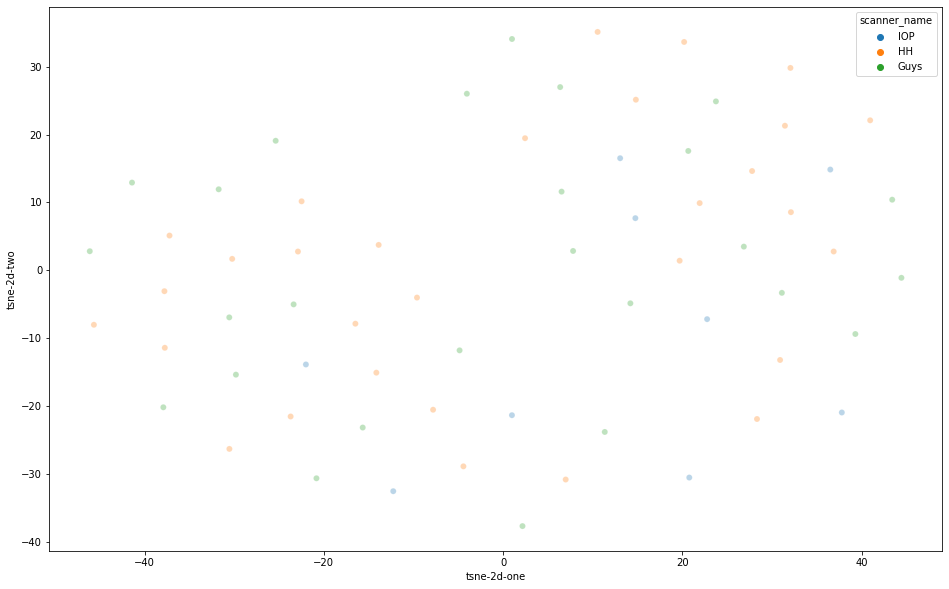

* This may be also due to excess preprocessing we did on these images that were not mentioned in the paper. We had done some preprocessing like bias field correction, voxel resolution normalization to around 1 mm . But shapes are same as paper (128, 128, 32 ).

However if we pretrain the scanner predictor along with the age predictor as done by Nicola Dinsdale, We can clearly see the separation between them

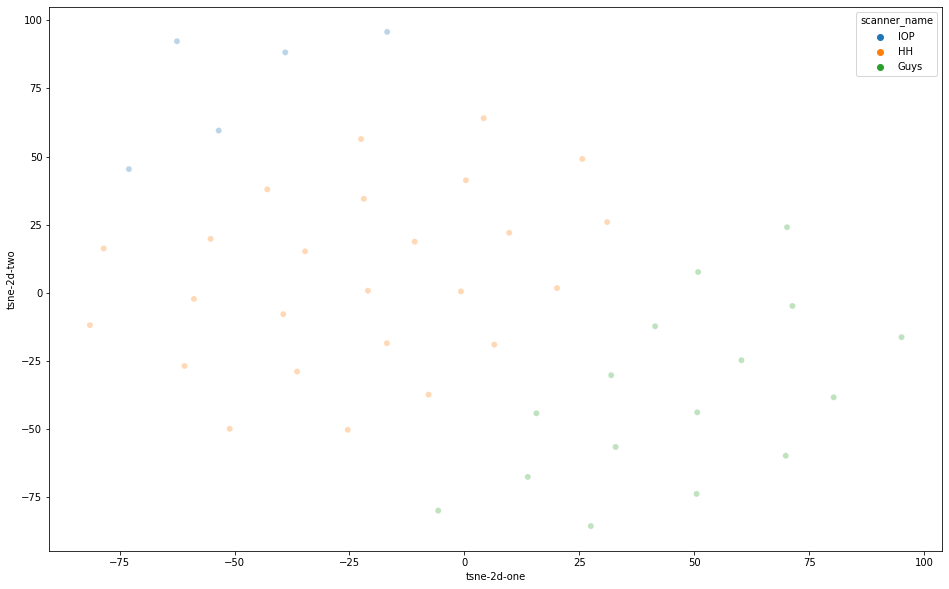

Scanner information indistinguishable if it is not included in pretraining

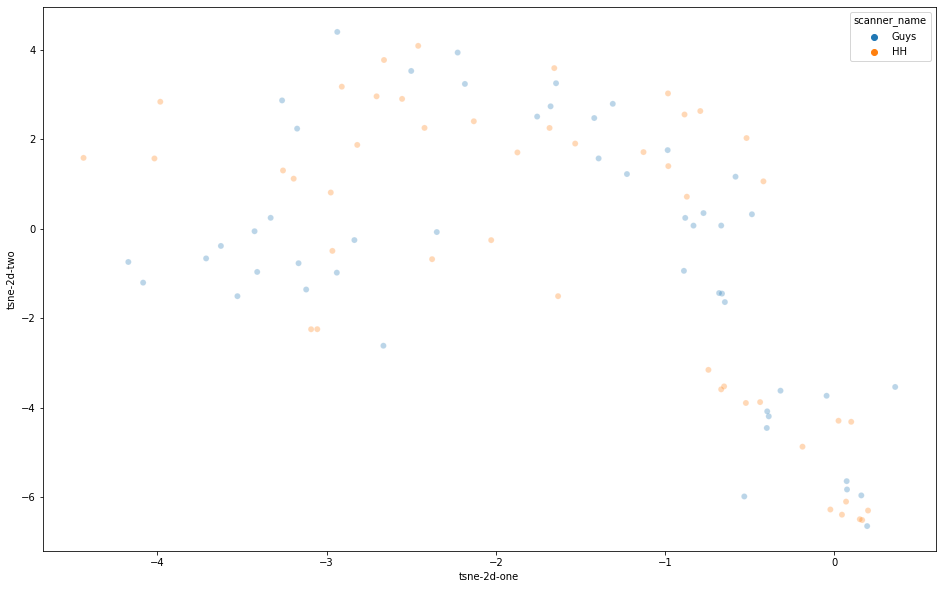

* On the other hand there is a clear grouping between contrast, One can see that T1 and T2 are clearly sepearable barring couple of outliers. Clear linearly separable features barring couple of outliers found for contrast

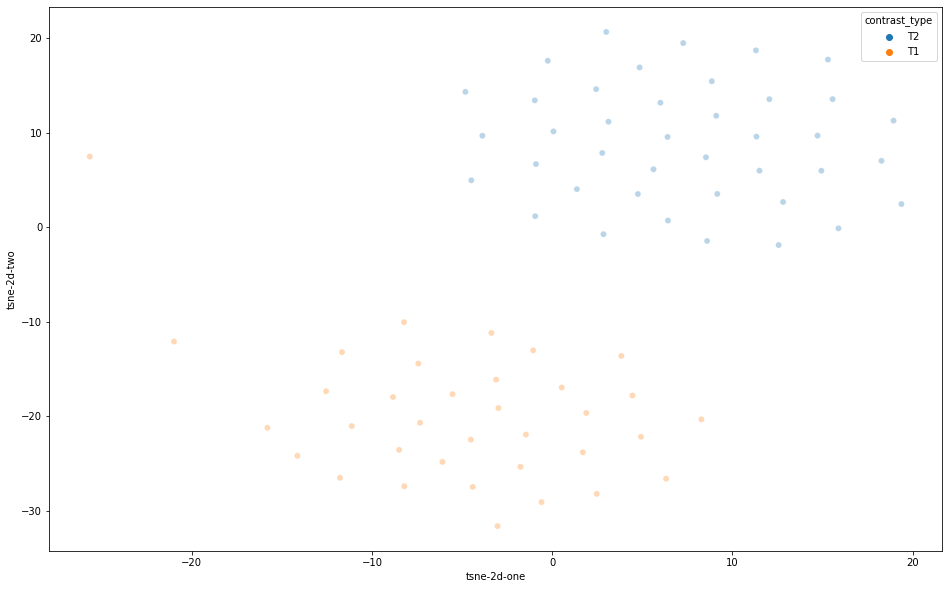


Sexual bias clearly visible as separtation between male and female brains that can be removed. The sex classifier is pretrained as done with Dinsdale et.al

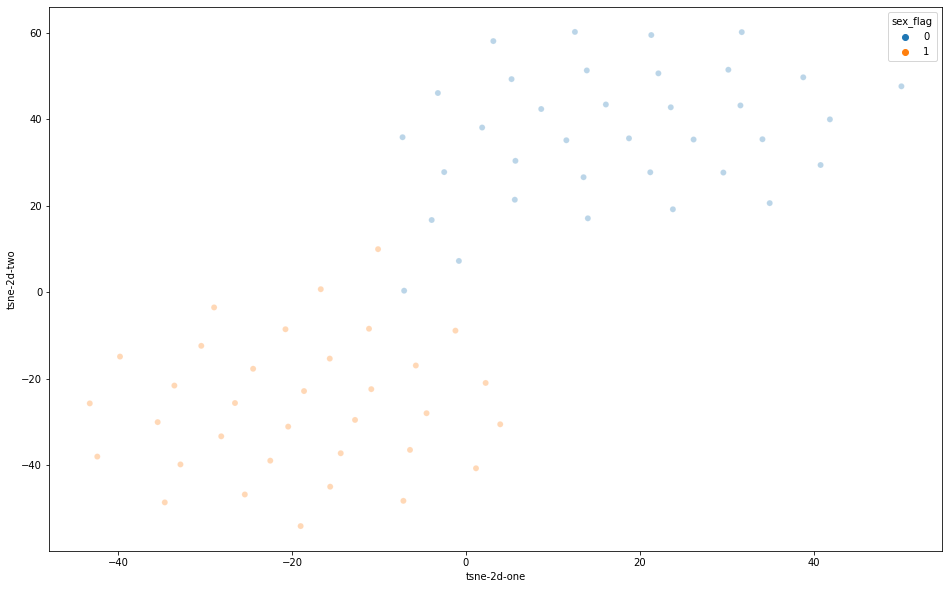

In [ ]:
sample_np = np.random.randn(100, 384)

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)

In [ ]:
tsne_results = tsne.fit_transform(mynp1)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.864559
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.991768
[t-SNE] KL divergence after 500 iterations: 0.039386
t-SNE done! Time elapsed: 1.3665122985839844 seconds


In [ ]:
df_subset = pd.DataFrame(tsne_results, columns = ['tsne-2d-one','tsne-2d-two'])

In [ ]:
result["tsne-2d-one"] = tsne_results[:, 0]
result["tsne-2d-two"] = tsne_results[:, 1]

In [ ]:
result.head(10)

,index,IXI_ID,AGE,age_disc,scanner_name,contrast_type,file_path,dataset_flag,scanner_flag,contrast_flag,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,tsne-2d-one,tsne-2d-two
0,0,60,30.699521,30-40,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,1,0,0.0,29.273970,42.917358,0.0,0.0,0.0,0.0,45.920395,45.421558,0.0,0.0,0.0,21.860157,25.014849,33.175419,0.0,36.633236,35.833740,40.689903,0.0,0.0,0.0,0.0,0.0,34.036415,37.587330,21.867817,0.0,0.0,0.0,...,40.561329,0.0,0.0,0.0,0.0,36.669380,0.0,29.819111,27.477089,28.946692,0.0,29.575546,29.283384,0.0,0.0,0.0,31.239004,0.0,0.0,0.0,34.916523,0.0,0.0,0.0,0.0,30.570927,0.0,0.0,0.0,31.162983,0.0,33.305164,0.0,0.0,0.0,0.0,31.116571,40.149471,-5.812913,-7.116330
1,1,428,55.540041,50-60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,1,0,0.0,29.581236,42.820183,0.0,0.0,0.0,0.0,46.008404,45.117138,0.0,0.0,0.0,21.219355,24.823839,33.330479,0.0,36.605362,35.676125,40.325428,0.0,0.0,0.0,0.0,0.0,34.040173,37.587715,21.815432,0.0,0.0,0.0,...,40.935223,0.0,0.0,0.0,0.0,37.145180,0.0,29.840881,26.842905,29.104700,0.0,29.565519,29.529573,0.0,0.0,0.0,31.135578,0.0,0.0,0.0,35.111557,0.0,0.0,0.0,0.0,31.256617,0.0,0.0,0.0,31.069906,0.0,33.659462,0.0,0.0,0.0,0.0,30.974947,40.158638,-6.924762,-6.663151
2,2,429,55.540041,50-60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,1,0,0.0,29.338142,42.858887,0.0,0.0,0.0,0.0,45.838749,45.600079,0.0,0.0,0.0,21.749435,24.832664,33.053429,0.0,36.739941,36.169445,40.688305,0.0,0.0,0.0,0.0,0.0,33.819805,37.650028,21.874548,0.0,0.0,0.0,...,40.229298,0.0,0.0,0.0,0.0,36.489407,0.0,29.689432,27.596352,29.230770,0.0,29.377878,29.336748,0.0,0.0,0.0,30.860981,0.0,0.0,0.0,34.776413,0.0,0.0,0.0,0.0,30.094488,0.0,0.0,0.0,31.378241,0.0,33.121983,0.0,0.0,0.0,0.0,31.061304,39.783314,-5.122900,-7.007329
3,5,432,57.738535,50-60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,1,0,0.0,29.171572,42.799957,0.0,0.0,0.0,0.0,45.761337,45.171906,0.0,0.0,0.0,21.378626,25.088104,32.949852,0.0,36.521908,35.717640,40.464050,0.0,0.0,0.0,0.0,0.0,33.702518,37.528320,21.864061,0.0,0.0,0.0,...,40.582607,0.0,0.0,0.0,0.0,36.710365,0.0,29.789331,27.281971,28.845995,0.0,29.583975,29.287090,0.0,0.0,0.0,31.116714,0.0,0.0,0.0,34.855942,0.0,0.0,0.0,0.0,30.606293,0.0,0.0,0.0,31.231834,0.0,33.054230,0.0,0.0,0.0,0.0,30.787594,39.705986,-5.845221,-6.509959
4,6,433,73.900068,70-80,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,2,0,0.0,34.056206,39.000504,0.0,0.0,0.0,0.0,46.040787,36.577988,0.0,0.0,0.0,1.113230,27.707958,37.294140,0.0,36.230865,31.217264,34.407143,0.0,0.0,0.0,0.0,0.0,27.036438,33.289936,28.868975,0.0,0.0,0.0,...,51.128067,0.0,0.0,0.0,0.0,46.416862,0.0,36.301300,15.523667,22.891424,0.0,25.789635,29.967627,0.0,0.0,0.0,31.712055,0.0,0.0,0.0,42.366257,0.0,0.0,0.0,0.0,44.615139,0.0,0.0,0.0,23.606653,0.0,37.130806,0.0,0.0,0.0,0.0,30.854900,33.737682,-7.710677,0.686345
5,8,435,56.284540,NaN,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,2,0,0.0,34.206829,37.381596,0.0,0.0,0.0,0.0,45.573971,33.688919,0.0,0.0,0.0,0.000000,29.181234,37.861477,0.0,35.164349,30.045525,32.480518,0.0,0.0,0.0,0.0,0.0,24.021877,31.781898,30.728952,0.0,0.0,0.0,...,53.425117,0.0,0.0,0.0,0.0,47.612461,0.0,37.878799,12.545586,21.141108,0.0,24.157839,29.259598,0.0,0.0,0.0,31.083927,0.0,0.0,0.0,44.601456,0.0,0.0,0.0,0.0,46.898289,0.0,0.0,0.0,21.326607,0.0,36.580158,0.0,0.0,0.0,0.0,30.398827,30.224770,-7.918170,0.959269
6,10,437,55.597536,50-60,HH,T1,/content/drive/My Drive/Image_Registration_Pro...,train_learn,0,0,0.0,34.506886,42.503956,0.0,0.0,0.0,0.0,46.383247,43.403599,0.0,0.0,0.0,21.282661,12.958103,35.715588,0.0,35.771671,29.330193,31.507448,0.0,0.0,0.0,0.0,0.0,40.487152,34.579754,14.697021,0.0,0.0,0.0,...,40.743805,0.0,0.0,0.0,0.0,42.119839,0.0,28.80488

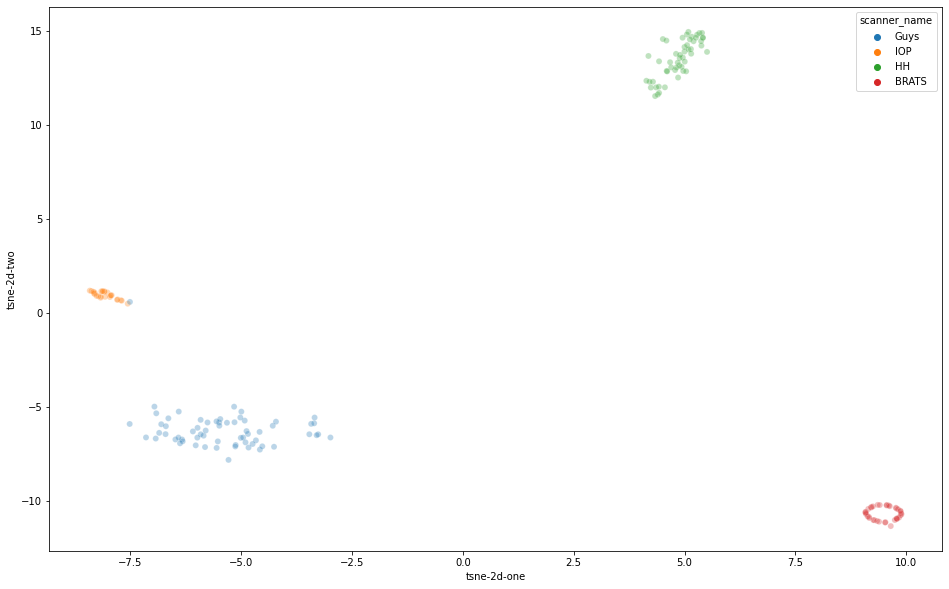

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "scanner_name", data=result, legend="full", alpha=0.3)

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "sex_flag", data=result, legend="full", alpha=0.3)

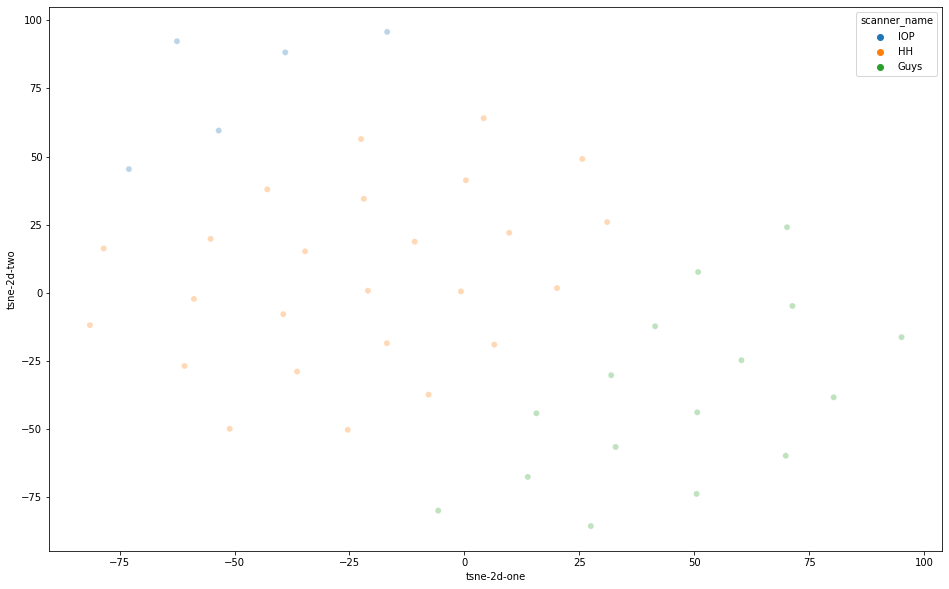

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "scanner_name", data=result, legend="full", alpha=0.3)

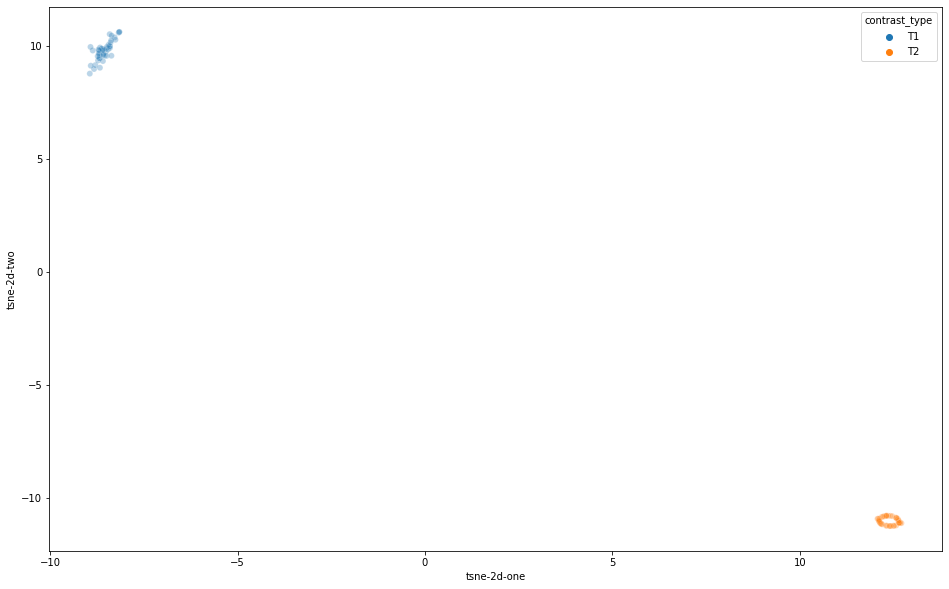

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type", data=result, legend="full", alpha=0.3)

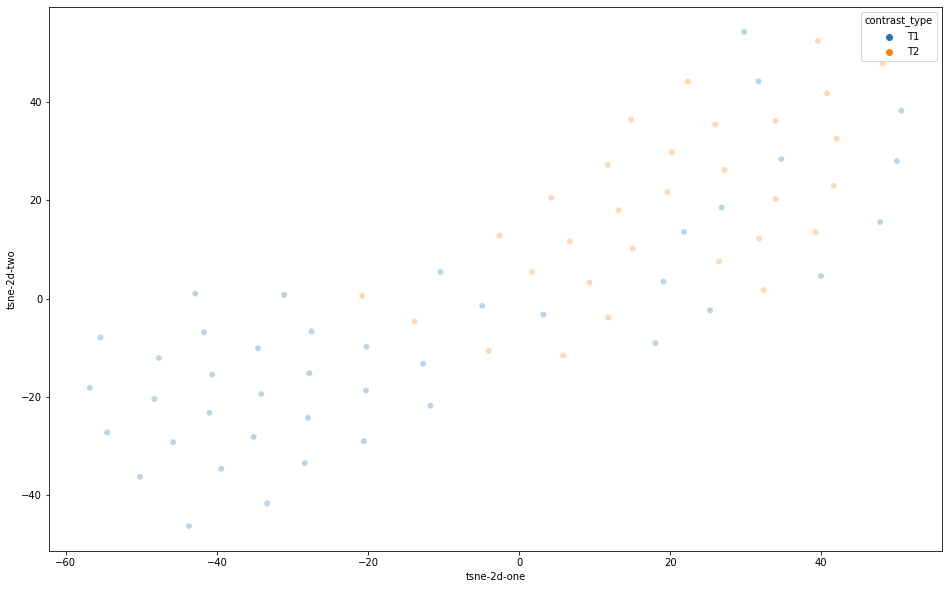

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type", data=result, legend="full", alpha=0.3)

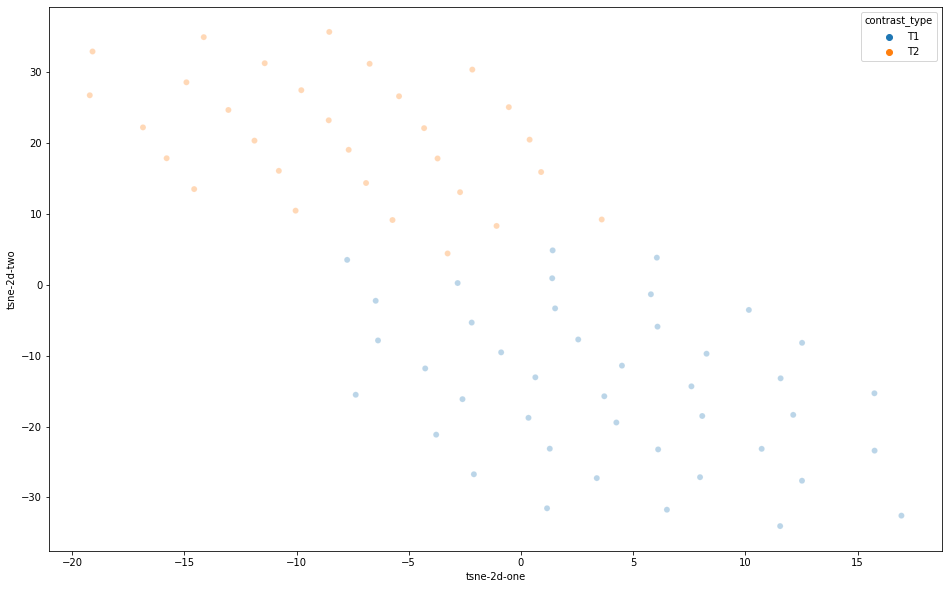

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type", data=result, legend="full", alpha=0.3)

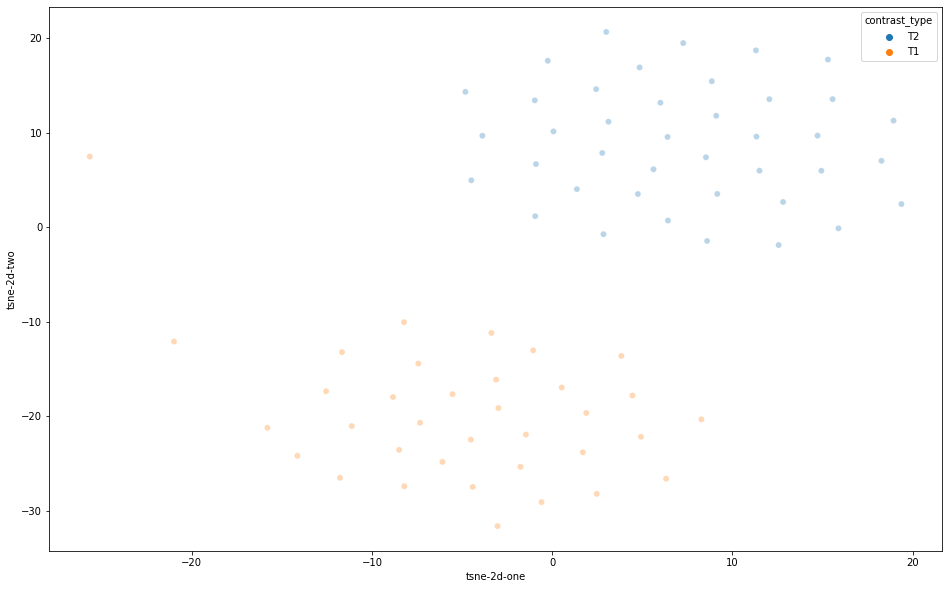

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

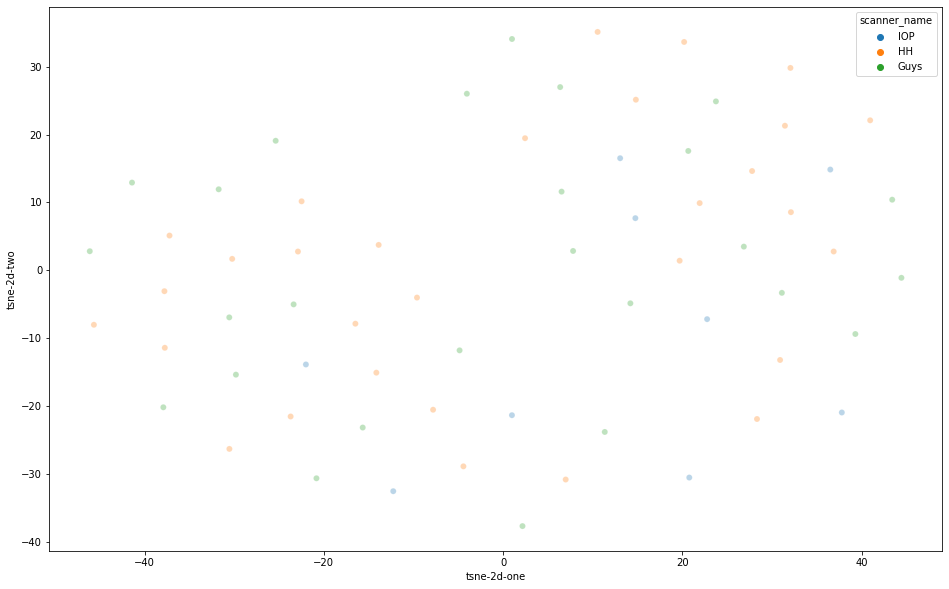

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "scanner_name",
    data=result,
    legend="full",
    alpha=0.3)

As we can see from both above and below

* Scanner type has little to no effect on age prediction and there seems to be not that much scanner non-biological info that could impact other tasks

* On the other hand there is a clear grouping between contrast, One can see that T1 and T2 are clearly sepearable barring couple of outliers

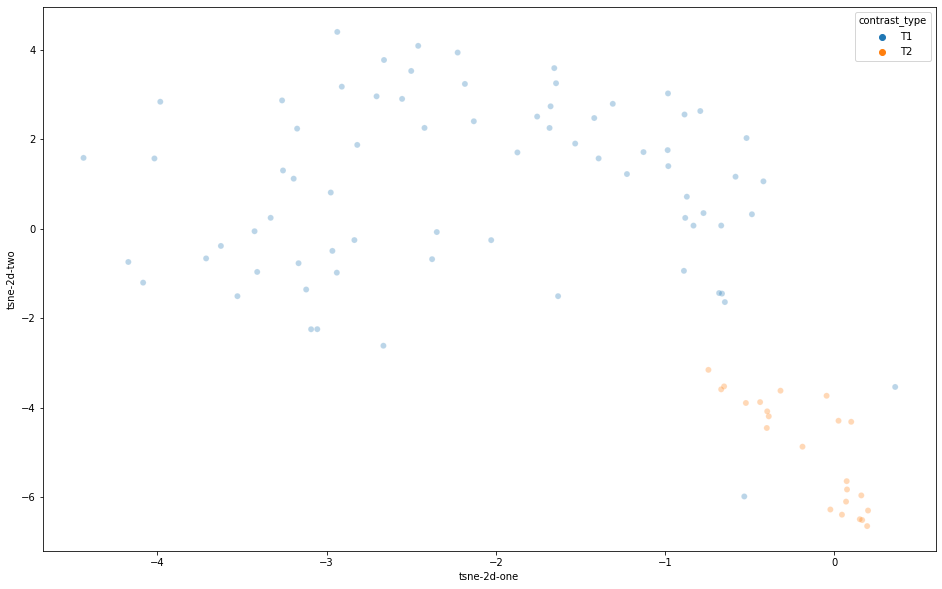

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

# Unlearning - Training

In [ ]:
unlearn_generator = Data.DataLoader(Dataset(train_learn_df, 1, True), batch_size=15,shuffle=True)

In [ ]:
del encoder_wu_val, regressor_wu_val, scanner_predictor_wu_val, contrast_predictor_wu_val
torch.cuda.empty_cache()

In [ ]:
encoder_wu_val = Encoder().to("cuda")
regressor_wu_val = Regressor().to("cuda")
scanner_predictor_wu_val = DomainPredictor(nodes=3).to("cuda")
contrast_predictor_wu_val = DomainPredictor(nodes=2).to("cuda")
sex_predictor_wu_val = DomainPredictor(nodes=2).to("cuda")

RuntimeError: ignored

In [ ]:
#checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/mri_harmonization/just_encoder_wu_112.pth')
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/mri_harmonization/pretrained_age_co_80.pth')
encoder_wu_val.load_state_dict(checkpoint['encoder_wou_model'])
regressor_wu_val.load_state_dict(checkpoint['regressor_wou_model'])
contrast_predictor_wu_val.load_state_dict(checkpoint["contrast_predictor_wou"])
#sex_predictor_wu_val.load_state_dict(checkpoint["sex_predictor_wou"])

<All keys matched successfully>

In [ ]:
#checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/mri_harmonization/just_encoder_wu_112.pth')
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/mri_harmonization/scanner_unlearning_70.pth')
encoder_wu_val.load_state_dict(checkpoint['encoder_wu_model'])
regressor_wu_val.load_state_dict(checkpoint['regressor_wu_model'])
scanner_predictor_wu_val.load_state_dict(checkpoint["scanner_predictor_wu"])
#contrast_predictor_wu_val.load_state_dict(checkpoint["contrast_predictor_wu"])

<All keys matched successfully>

In [ ]:
#checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/mri_harmonization/just_encoder_wu_112.pth')
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/mri_harmonization/pretrained_age_se_60.pth')
encoder_wu_val.load_state_dict(checkpoint['encoder_wou_model'])
regressor_wu_val.load_state_dict(checkpoint['regressor_wou_model'])
#scanner_predictor_wu_val.load_state_dict(checkpoint["scanner_predictor_wu"])
sex_predictor_wu_val.load_state_dict(checkpoint["sex_predictor_wou"])

<All keys matched successfully>

In [ ]:
#checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/mri_harmonization/just_encoder_wu_112.pth')
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/mri_harmonization/sex_unlearning_74.pth')
encoder_wu_val.load_state_dict(checkpoint['encoder_wu_model'])
regressor_wu_val.load_state_dict(checkpoint['regressor_wu_model'])
#scanner_predictor_wu_val.load_state_dict(checkpoint["scanner_predictor_wu"])
sex_predictor_wu_val.load_state_dict(checkpoint["sex_predictor_wu"])

<All keys matched successfully>

In [ ]:
regressor_loss_wu = nn.MSELoss() 
scanner_criterion_loss_wu = nn.CrossEntropyLoss(weight=torch.Tensor([0.1, 0.3, 0.6]).to("cuda") ) 
contrast_criterion_loss_wu = nn.CrossEntropyLoss()
sex_criterion_loss_wu = nn.CrossEntropyLoss(weight=torch.Tensor([0.45, 0.55]).to("cuda") ) 
contrast_confusion_loss_wu = confusion_loss()
scanner_confusion_loss_wu = confusion_loss()
sex_confusion_loss_wu = confusion_loss()

In [ ]:
lr = 3e-6

In [ ]:
optimizer = torch.optim.Adam(list(encoder_wu_val.parameters()) + list(regressor_wu_val.parameters())  , lr=1e-6 ) 

optimizer_dm = torch.optim.Adam(list(scanner_predictor_wu_val.parameters()) , lr=2e-7 )

optimizer_conf = torch.optim.Adam(encoder_wu_val.parameters() , lr=2e-7)

model_dir = '/content/drive/My Drive/Image_Registration_Project/mri_harmonization'

LOSS_PATH = "/content/drive/My Drive/Image_Registration_Project/mri_harmonization"
if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

In [ ]:
optimizer = torch.optim.Adam(list(encoder_wu_val.parameters()) + list(regressor_wu_val.parameters())  , lr=1e-6 ) 

optimizer_dm = torch.optim.Adam(list(sex_predictor_wu_val.parameters()) , lr=2e-7 )

optimizer_conf = torch.optim.Adam(encoder_wu_val.parameters() , lr=2e-7)

model_dir = '/content/drive/My Drive/Image_Registration_Project/mri_harmonization'

LOSS_PATH = "/content/drive/My Drive/Image_Registration_Project/mri_harmonization"
if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

In [ ]:
myiptnsr = torch.randn(size=(7,1,128,128,32)).to("cuda")
encf = encoder_wu_val(myiptnsr)
ccf = contrast_predictor_wu_val(encf)
make_dot(ccf)

In [ ]:
def run_one_epoch(epoch = 1):
  example_number = 0
  age_prediction_mse_lst = []
  total_loss_lst = []
  sc_loss_lst = []
  co_loss_lst = []
  sc_cnf_loss_lst = []
  co_cnf_loss_lst = []
  scanner_accuracy_lst = []
  contrast_accuracy_lst = []
  for X, Y, Z, A in unlearn_generator:
    X = X.to("cuda").float()
    Y = Y.to("cuda").float()
    Z = Z.to("cuda").long()
    A = A.to("cuda").long()
    # B = B.to("cuda").long()
    X, Y, Z, A = Variable(X), Variable(Y), Variable(Z), Variable(A)
    torch.autograd.set_detect_anomaly(True)

    optimizer.zero_grad() 
    encoder_feats = encoder_wu_val(X)
    predicted_age = regressor_wu_val(encoder_feats)
    main_task_loss = regressor_loss_wu(Y, predicted_age)
    total_loss = main_task_loss          
    total_loss.backward(retain_graph=True) 
    

    optimizer_dm.zero_grad()
    frozen_representation = encoder_feats.detach()
    # contrast_op_tnsr = contrast_predictor_wu_val(frozen_representation)
    # co_loss = contrast_criterion_loss_wu(contrast_op_tnsr, A)
    scanner_op_tnsr = scanner_predictor_wu_val(frozen_representation)
    sc_loss = scanner_criterion_loss_wu(scanner_op_tnsr, Z)
    loss_dm = 2.0 * (sc_loss)
    loss_dm.backward()
    

    optimizer_conf.zero_grad()
    scanner_op_tnsr = scanner_predictor_wu_val(encoder_feats)
    sc_cnf_loss = scanner_confusion_loss_wu(scanner_op_tnsr, Z)
    #print( torch.equal(encoder_feats, frozen_representation) )
    # contrast_op_tnsr = contrast_predictor_wu_val(encoder_feats)    
    # co_cnf_loss = contrast_confusion_loss_wu(contrast_op_tnsr, A)
    #make_dot(contrast_op_tnsr)
    loss_conf = 20.0 * (sc_cnf_loss)
    loss_conf.backward(retain_graph=False)


    # https://discuss.pytorch.org/t/solved-pytorch1-5-runtimeerror-one-of-the-variables-needed-for-gradient-computation-has-been-modified-by-an-inplace-operation/90256
    # From pytorch 1.15 (Jun 2020 onwards) they have fixed the test for optimizers
    # Using nicola dinsdales code of optimizer.step after totla loss will update the weight of the encoder nework
    # While updating confusion loss on encoder it demands that it sees older weights and not updates weights in last step
    
    optimizer.step()
    optimizer_dm.step()
    optimizer_conf.step()
   
    age_prediction_mse_lst.append(main_task_loss.detach().cpu().numpy().item())
    sc_loss_lst.append(sc_loss.detach().cpu().numpy().item())
    # co_loss_lst.append(co_loss.detach().cpu().numpy().item())
    sc_cnf_loss_lst.append(sc_cnf_loss.detach().cpu().numpy().item())
    # co_cnf_loss_lst.append(co_cnf_loss.detach().cpu().numpy().item())
    #print(co_cnf_loss.detach().cpu().numpy().item())

    total_loss_lst.append(total_loss.detach().cpu().numpy())

    scanner_op_np = np.argmax(scanner_op_tnsr.detach().cpu().numpy(), axis=1)    
    scanner_acc = accuracy_score(Z.detach().cpu().numpy(), scanner_op_np)
    scanner_accuracy_lst.append(scanner_acc.item())

    # contrast_op_np = np.argmax(contrast_op_tnsr.detach().cpu().numpy(), axis=1)
    # contrast_acc = accuracy_score(A.detach().cpu().numpy(), contrast_op_np)
    # contrast_accuracy_lst.append(contrast_acc.item())
    

    del X, Y, Z, A, encoder_feats, predicted_age, frozen_representation , scanner_op_tnsr # contrast_op_tnsr #scanner_op_tnsr #,contrast_op_tnsr,
    torch.cuda.empty_cache()
    example_number = example_number + 1
    
  print()
  if (epoch%10 == 0):
      modelname = model_dir + '/' + "scanner_unlearning_" + str(epoch+70) + '.pth'
      torch.save({"encoder_wu_model": encoder_wu_val.state_dict(), "regressor_wu_model": regressor_wu_val.state_dict(), 
                  "scanner_predictor_wu": scanner_predictor_wu_val.state_dict(), "contrast_predictor_wu": contrast_predictor_wu_val.state_dict()}, modelname)
      print("epoch: {}".format(epoch+70))

      print("Losses for main task and total, accuracy of scanner : {}, {}, {}, {}, {}".format(sum(age_prediction_mse_lst)/len(age_prediction_mse_lst), 
                                            sum(scanner_accuracy_lst)/len(scanner_accuracy_lst), sum(sc_loss_lst)/len(sc_loss_lst), 
                                            sum(sc_cnf_loss_lst)/len(sc_cnf_loss_lst), total_loss))
      print("Saving model checkpoints")
      print("======= =============== ===========")
      print()
  elif (epoch%2 == 0):
      print("epoch: {}".format(epoch+70))
      print("Losses for main task and total, accuracy of scanner : {}, {}, {}, {}, {}".format(sum(age_prediction_mse_lst)/len(age_prediction_mse_lst), 
                                            sum(scanner_accuracy_lst)/len(scanner_accuracy_lst), sum(sc_loss_lst)/len(sc_loss_lst), 
                                            sum(sc_cnf_loss_lst)/len(sc_cnf_loss_lst), total_loss))
      print("======= =============== ===========")
      print()
  
  return age_prediction_mse_lst, sc_loss_lst, sc_cnf_loss_lst, total_loss_lst, scanner_accuracy_lst



In [ ]:
epochs = 21
a_lst = []
sc_lst = []
co_lst = []
sc_cnf_lst = []
co_cnf_lst = []
s_lst = []
c_lst = []
m_lst = []
for e in range(epochs):
  a, co,  cocnf, m, c = run_one_epoch(epoch=e)
  a_lst.append(a)
  co_lst.append(co)
  co_cnf_lst.append(cocnf)
  m_lst.append(m)
  c_lst.append(c)

RuntimeError: ignored

In [ ]:
epochs = 21
a_lst = []
sc_lst = []
co_lst = []
sc_cnf_lst = []
co_cnf_lst = []
s_lst = []
c_lst = []
m_lst = []
for e in range(epochs):
  a, co,  cocnf, m, c = run_one_epoch(epoch=e)
  a_lst.append(a)
  co_lst.append(co)
  co_cnf_lst.append(cocnf)
  m_lst.append(m)
  c_lst.append(c)


epoch: 40
Losses for main task and total, accuracy of scanner : 236.0410392067649, 0.39696969696969703, 1.0453726757656445, 22.108971682461824, 300.37738037109375
Saving model checkpoints
======= =============== ===========



epoch: 42
Losses for main task and total, accuracy of scanner : 238.70254516601562, 0.45833333333333337, 1.0709428787231445, 21.170418045737527, 333.3441467285156
======= =============== ===========



epoch: 44
Losses for main task and total, accuracy of scanner : 233.10780473188922, 0.43787878787878787, 1.076274189082059, 21.300534508445047, 224.2256622314453
======= =============== ===========



epoch: 46
Losses for main task and total, accuracy of scanner : 235.31688343394887, 0.3446969696969697, 1.0648750933733853, 21.28902357274836, 264.8202209472656
======= =============== ===========



epoch: 48
Losses for main task and total, accuracy of scanner : 234.10144320401278, 0.40227272727272717, 1.086235989223827, 20.94556357643821, 231.79420471191406
=======

In [ ]:
epochs = 71
a_lst = []
sc_lst = []
co_lst = []
sc_cnf_lst = []
co_cnf_lst = []
s_lst = []
c_lst = []
m_lst = []
for e in range(epochs):
  a, co,  cocnf, m, c = run_one_epoch(epoch=e)
  a_lst.append(a)
  co_lst.append(co)
  co_cnf_lst.append(cocnf)
  m_lst.append(m)
  c_lst.append(c)


epoch: 128
Losses for main task and total, accuracy of contrast : 269.9060923258464, 0.3925925925925926, 0.7189102570215861, 12.51286506652832, 296.7762756347656
Saving model checkpoints
======= =============== ===========



epoch: 130
Losses for main task and total, accuracy of contrast : 265.5693893432617, 0.48148148148148157, 0.7009940445423126, 12.649362564086914, 227.12220764160156
Saving model checkpoints
======= =============== ===========



epoch: 132
Losses for main task and total, accuracy of contrast : 270.5906575520833, 0.4185185185185185, 0.6743015348911285, 13.757558345794678, 301.854736328125
Saving model checkpoints
======= =============== ===========



epoch: 134
Losses for main task and total, accuracy of contrast : 260.41492462158203, 0.5, 0.7426385780175527, 12.958743413289389, 157.0489959716797
Saving model checkpoints
======= =============== ===========



epoch: 136
Losses for main task and total, accuracy of contrast : 266.7447255452474, 0.48888888888888893,

In [ ]:
epochs = 21
a_lst = []
sc_lst = []
co_lst = []
sc_cnf_lst = []
co_cnf_lst = []
s_lst = []
c_lst = []
m_lst = []
for e in range(epochs):
  a, co,  cocnf, m, c = run_one_epoch(epoch=e)
  a_lst.append(a)
  co_lst.append(co)
  co_cnf_lst.append(cocnf)
  m_lst.append(m)
  c_lst.append(c)


epoch: 66
Losses for main task and total, accuracy of contrast : 28.82696429165927, 0.461038961038961, 0.6819037144834345, 4.65909463709051, 47.23410415649414
Saving model checkpoints
======= =============== ===========



epoch: 68
Losses for main task and total, accuracy of contrast : 30.607865420254793, 0.44155844155844143, 0.6834268569946289, 4.628529169342735, 37.249298095703125
Saving model checkpoints
======= =============== ===========



epoch: 70
Losses for main task and total, accuracy of contrast : 33.5127027684992, 0.48701298701298695, 0.6977915655482899, 4.578363852067427, 54.548622131347656
Saving model checkpoints
======= =============== ===========



epoch: 72
Losses for main task and total, accuracy of contrast : 32.5765684301203, 0.6103896103896104, 0.6970517256043174, 4.562316872856834, 24.814491271972656
Saving model checkpoints
======= =============== ===========



epoch: 74
Losses for main task and total, accuracy of contrast : 34.40133129466664, 0.38311688311

In [ ]:
def run_one_epoch(epoch = 1):
  example_number = 0
  age_prediction_mse_lst = []
  total_loss_lst = []
  sc_loss_lst = []
  co_loss_lst = []
  sex_loss_lst = []
  sc_cnf_loss_lst = []
  co_cnf_loss_lst = []
  sex_cnf_loss_lst = []
  scanner_accuracy_lst = []
  contrast_accuracy_lst = []
  sex_accuracy_lst = []
  for X, Y, Z, A, B in training_generator:
    X = X.to("cuda").float()
    Y = Y.to("cuda").float()
    Z = Z.to("cuda").long()
    A = A.to("cuda").long()
    B = B.to("cuda").long()
    X, Y, Z, A, B = Variable(X), Variable(Y), Variable(Z), Variable(A), Variable(B)
    torch.autograd.set_detect_anomaly(True)

    optimizer.zero_grad() 
    encoder_feats = encoder_wu_val(X)
    predicted_age = regressor_wu_val(encoder_feats)
    main_task_loss = regressor_loss_wu(Y, predicted_age)
    total_loss = main_task_loss          
    total_loss.backward(retain_graph=True) 
    

    optimizer_dm.zero_grad()
    frozen_representation = encoder_feats.detach()
    # contrast_op_tnsr = contrast_predictor_wu_val(frozen_representation)
    # co_loss = contrast_criterion_loss_wu(contrast_op_tnsr, A)
    sex_op_tnsr = sex_predictor_wu_val(frozen_representation)
    sex_loss = sex_criterion_loss_wu(sex_op_tnsr, B)
    loss_dm = 4.0 * (sex_loss)
    loss_dm.backward()
    

    optimizer_conf.zero_grad()
    sex_op_tnsr = sex_predictor_wu_val(encoder_feats)
    sex_cnf_loss = sex_confusion_loss_wu(sex_op_tnsr, B)
    loss_conf = 40.0 * (sex_cnf_loss)
    loss_conf.backward(retain_graph=False)


    # https://discuss.pytorch.org/t/solved-pytorch1-5-runtimeerror-one-of-the-variables-needed-for-gradient-computation-has-been-modified-by-an-inplace-operation/90256
    # From pytorch 1.15 (Jun 2020 onwards) they have fixed the test for optimizers
    # Using nicola dinsdales code of optimizer.step after totla loss will update the weight of the encoder nework
    # While updating confusion loss on encoder it demands that it sees older weights and not updates weights in last step
    
    optimizer.step()
    optimizer_dm.step()
    optimizer_conf.step()
   
    age_prediction_mse_lst.append(main_task_loss.detach().cpu().numpy().item())
    sex_loss_lst.append(sex_loss.detach().cpu().numpy().item())
    sex_cnf_loss_lst.append(sex_cnf_loss.detach().cpu().numpy().item())
    total_loss_lst.append(total_loss.detach().cpu().numpy())

    sex_op_np = np.argmax(sex_op_tnsr.detach().cpu().numpy(), axis=1)    
    sex_acc = accuracy_score(B.detach().cpu().numpy(), sex_op_np)
    sex_accuracy_lst.append(sex_acc.item())

    del X, Y, Z, A, B, encoder_feats, predicted_age, frozen_representation , sex_op_tnsr #scanner_op_tnsr #,contrast_op_tnsr,
    torch.cuda.empty_cache()
    example_number = example_number + 1
    
  print()
  if (epoch%2 == 0):
      modelname = model_dir + '/' + "sex_unlearning_" + str(epoch+72) + '.pth'
      torch.save({"encoder_wu_model": encoder_wu_val.state_dict(), "regressor_wu_model": regressor_wu_val.state_dict(), 
                  "sex_predictor_wu": sex_predictor_wu_val.state_dict()}, modelname)
      print("epoch: {}".format(epoch+72))

      print("Losses for main task and total, accuracy of contrast : {}, {}, {}, {}, {}".format(sum(age_prediction_mse_lst)/len(age_prediction_mse_lst), 
                                            sum(sex_accuracy_lst)/len(sex_accuracy_lst), sum(sex_loss_lst)/len(sex_loss_lst), 
                                            sum(sex_cnf_loss_lst)/len(sex_cnf_loss_lst), total_loss))
      print("Saving model checkpoints")
      print("======= =============== ===========")
      print()
  
  return age_prediction_mse_lst, sex_loss_lst, sex_cnf_loss_lst, total_loss_lst, sex_accuracy_lst



In [ ]:
epochs = 21
a_lst = []
sc_lst = []
co_lst = []
sc_cnf_lst = []
co_cnf_lst = []
s_lst = []
c_lst = []
m_lst = []
for e in range(epochs):
  a, co,  cocnf, m, c = run_one_epoch(epoch=e)
  a_lst.append(a)
  co_lst.append(co)
  co_cnf_lst.append(cocnf)
  m_lst.append(m)
  c_lst.append(c)


epoch: 72
Losses for main task and total, accuracy of contrast : 254.69589080810547, 0.5314285714285714, 0.699014562368393, 5.219869089126587, 288.69244384765625
Saving model checkpoints
======= =============== ===========



epoch: 74
Losses for main task and total, accuracy of contrast : 250.67148132324218, 0.48857142857142855, 0.7081895530223846, 5.118755292892456, 126.25091552734375
Saving model checkpoints
======= =============== ===========



epoch: 76
Losses for main task and total, accuracy of contrast : 253.70608215332032, 0.5885714285714286, 0.7272077918052673, 5.063962841033936, 240.8735809326172
Saving model checkpoints
======= =============== ===========



epoch: 78
Losses for main task and total, accuracy of contrast : 257.9263717651367, 0.6257142857142858, 0.7066257536411286, 5.139138913154602, 366.1871032714844
Saving model checkpoints
======= =============== ===========



epoch: 80
Losses for main task and total, accuracy of contrast : 254.79875640869142, 0.4771428

Trying joint removal of scanner and contrast information. Will be tried out in another notebook

In [ ]:
def run_one_epoch(epoch = 1):
  example_number = 0
  age_prediction_mse_lst = []
  total_loss_lst = []
  sc_loss_lst = []
  co_loss_lst = []
  sc_cnf_loss_lst = []
  co_cnf_loss_lst = []
  scanner_accuracy_lst = []
  contrast_accuracy_lst = []
  for X, Y, Z, A in training_generator:
    X = X.to("cuda").float()
    Y = Y.to("cuda").float()
    Z = Z.to("cuda").long()
    A = A.to("cuda").long()
    X, Y, Z, A = Variable(X), Variable(Y), Variable(Z), Variable(A)
    torch.autograd.set_detect_anomaly(True)

    optimizer.zero_grad() 
    encoder_feats = encoder_wu_val(X)
    predicted_age = regressor_wu_val(encoder_feats)
    main_task_loss = regressor_loss_wu(Y, predicted_age)
    total_loss = main_task_loss          
    total_loss.backward(retain_graph=True) 
    optimizer.step()

    optimizer_dm.zero_grad()
    scanner_op_tnsr = scanner_predictor_wu_val(encoder_feats.detach())
    sc_loss = scanner_criterion_loss_wu(scanner_op_tnsr, Z)
    contrast_op_tnsr = contrast_predictor_wu_val(encoder_feats.detach())
    co_loss = contrast_criterion_loss_wu(contrast_op_tnsr, A)
    loss_dm = 2.0 * (sc_loss + co_loss)
    loss_dm.backward()
    optimizer_dm.step()

    optimizer_conf.zero_grad()
    scanner_op_tnsr = scanner_predictor_wu_val(encoder_feats)
    contrast_op_tnsr = contrast_predictor_wu_val(encoder_feats)
    sc_cnf_loss = scanner_confusion_loss_wu(scanner_op_tnsr, Z)
    co_cnf_loss = contrast_confusion_loss_wu(contrast_op_tnsr, A)
    loss_conf = 20.0 * (sc_cnf_loss + co_cnf_loss)
    loss_conf.backward(retain_graph=False)
    optimizer_conf.step()

    age_prediction_mse_lst.append(main_task_loss.detach().cpu().numpy().item())
    sc_loss_lst.append(sc_loss.detach().cpu().numpy().item())
    co_loss_lst.append(co_loss.detach().cpu().numpy().item())
    sc_cnf_loss_lst.append(sc_cnf_loss.detach().cpu().numpy().item())
    co_cnf_loss_lst.append(co_cnf_loss.detach().cpu().numpy().item())
    print(co_cnf_loss.detach().cpu().numpy().item())

    total_loss_lst.append(total_loss.detach().cpu().numpy())

    scanner_op_np = np.argmax(scanner_op_tnsr.detach().cpu().numpy(), axis=1)

    contrast_op_np = np.argmax(contrast_op_tnsr.detach().cpu().numpy(), axis=1)

    scanner_acc = accuracy_score(Z.detach().cpu().numpy(), scanner_op_np)
    scanner_accuracy_lst.append(scanner_acc.item())

    contrast_acc = accuracy_score(A.detach().cpu().numpy(), contrast_op_np)
    contrast_accuracy_lst.append(contrast_acc.item())
    

    del X, Y, Z, A, encoder_feats, predicted_age, scanner_op_tnsr, contrast_op_tnsr
    torch.cuda.empty_cache()
    example_number = example_number + 1
    
  print()
  if (epoch%2 == 0):
      modelname = model_dir + '/' + "firstpart_wu_" + str(epoch+0) + '.pth'
      torch.save({"encoder_wu_model": encoder_wu_val.state_dict(), "regressor_wu_model": regressor_wu_val.state_dict(), 
                  "scanner_predictor_wu": scanner_predictor_wu_val.state_dict(), "contrast_predictor_wu": contrast_predictor_wu_val.state_dict()}, modelname)
      print("epoch: {}".format(epoch))

      print("Losses for main task and total, accuracy of scanner and contrast : {}, {}, {}, {}, {}, {}, {}, {}".format(sum(age_prediction_mse_lst)/len(age_prediction_mse_lst), 
                                           sum(scanner_accuracy_lst)/len(scanner_accuracy_lst), sum(contrast_accuracy_lst)/len(contrast_accuracy_lst),                                                                            
                                           sum(sc_loss_lst)/len(sc_loss_lst), sum(co_loss_lst)/len(co_loss_lst), 
                                           sum(sc_cnf_loss_lst)/len(sc_cnf_loss_lst), sum(co_cnf_loss_lst)/len(co_cnf_loss_lst),
                                           total_loss))
      print("Saving model checkpoints")
      print("======= =============== ===========")
      print()
  
  return age_prediction_mse_lst, sc_loss_lst, co_loss_lst, sc_cnf_loss_lst, co_cnf_loss_lst, total_loss_lst, scanner_accuracy_lst, contrast_accuracy_lst



In [ ]:
epochs = 3
a_lst = []
sc_lst = []
co_lst = []
sc_cnf_lst = []
co_cnf_lst = []
s_lst = []
c_lst = []
m_lst = []
for e in range(epochs):
  a, sc, co, sccnf, cocnf, m, s, c = run_one_epoch(epoch=e)
  a_lst.append(a)
  sc_lst.append(sc)
  co_lst.append(co)
  sc_cnf_lst.append(sccnf)
  co_cnf_lst.append(cocnf)
  m_lst.append(m)
  s_lst.append(s)
  c_lst.append(c)

RuntimeError: ignored

In [ ]:
co_cnf_lst[0:2]

# Unlearning - Feature extraction and Visualization

* We are able successfully mixup the scanner information back and make sure it is around random chance. This removes the bias of scanner. The Age MSE loss also have not increases too much during unlearning. During pretraining it was around 230 and in unlearning settled around 250. The accuracy of scanner predictor went down to near 50 % which is random chance considering three scanners {HH, Guys, IOP} present at {0.6, 0.4, 0.1} proportion. If they are present at equal proportion then random chance would be 34 %.

* Training during unlearning, learning rates and the loss weights have huge impact on how the info is unlearnt. If we increase learning rate then age predictor becomes destabilized and mse error increases. If loss weights are not proper and also annealing properly then we fail to remove the bias.

* Sex information was unlearnt

* If we do joint removal of multiple confunders then we need to be really careful of the learning rates and loss weights used.

* Below picture shows the bias of scanner has been removed from feature space

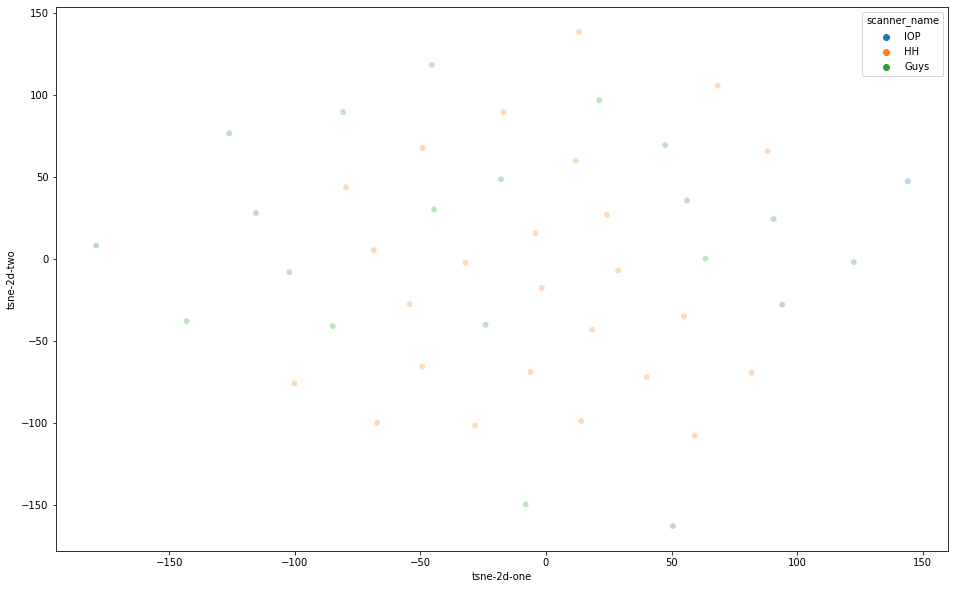


* We face the problem with contrast. It could be seen that contrast is an extremely strong bias that is difficult to be removed from the system with the simplistic VGG network. The bias persists even if we ran and age predicton mse loss increased beyond 300 making it unstable. 

* Maybe more powerful network must be used tried to remove the contrast 

* Contrast removal started but unstable unlearning causing main task error increase

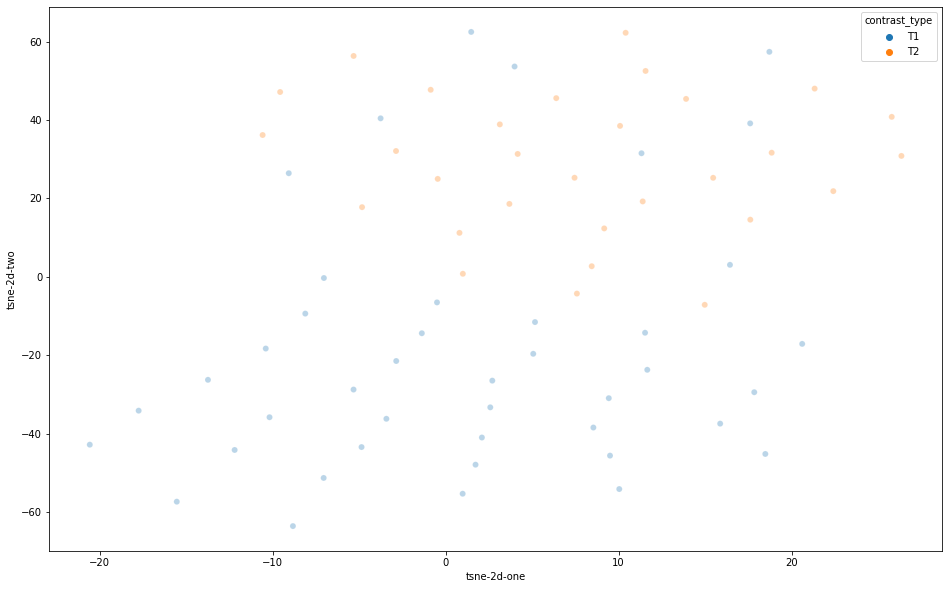


* Persisting Bias from contrast
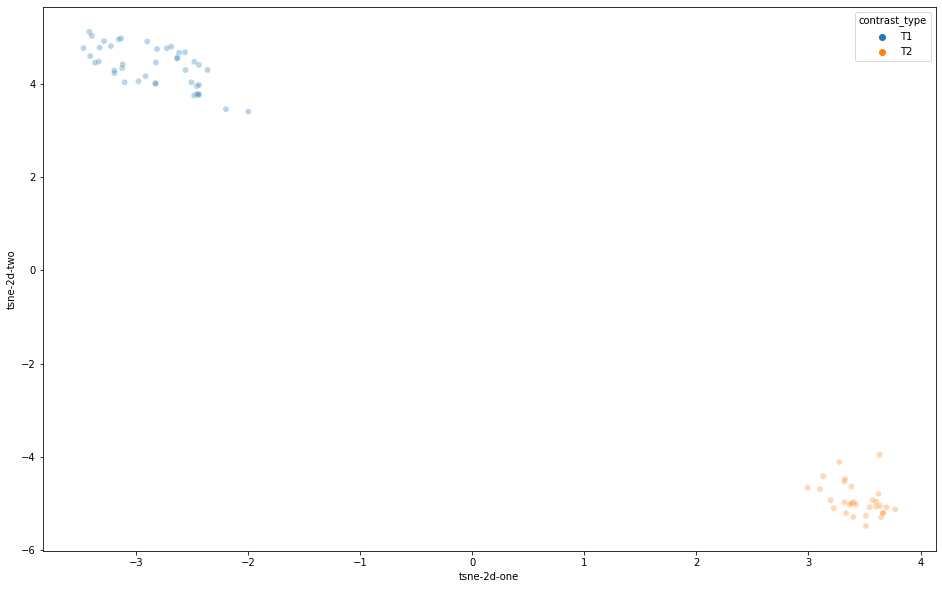


* Sexual bias has been unlearnt properly as we can see clear mixing of male and female in feature space.
* At around 50th epoch we can see still some amount of divide is present.
* However as we unlearn more at 90th epcoh the network unlearns male and female info and the feature space parameters are not easily discriminated into male and female


At 50th epoch 

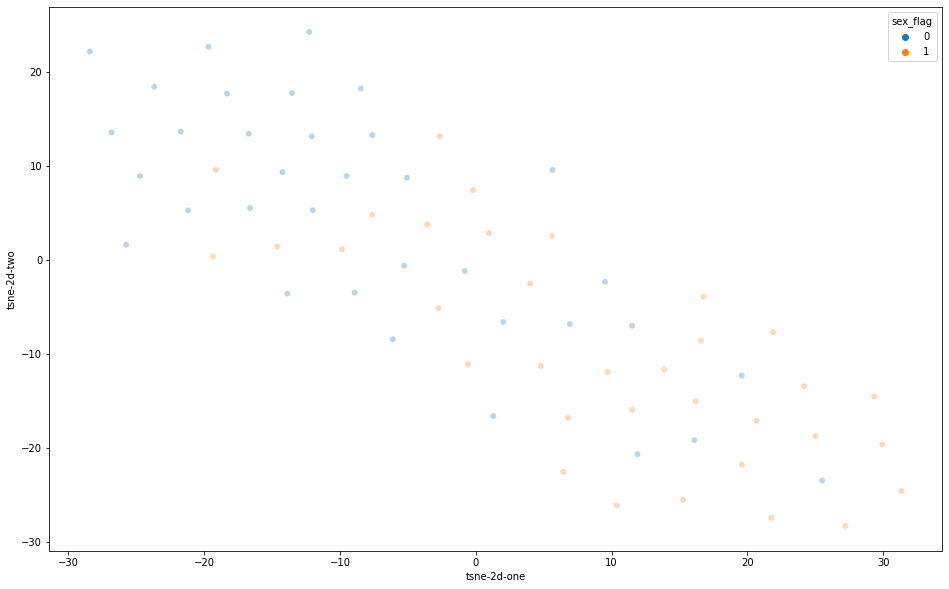


At 90th epoch

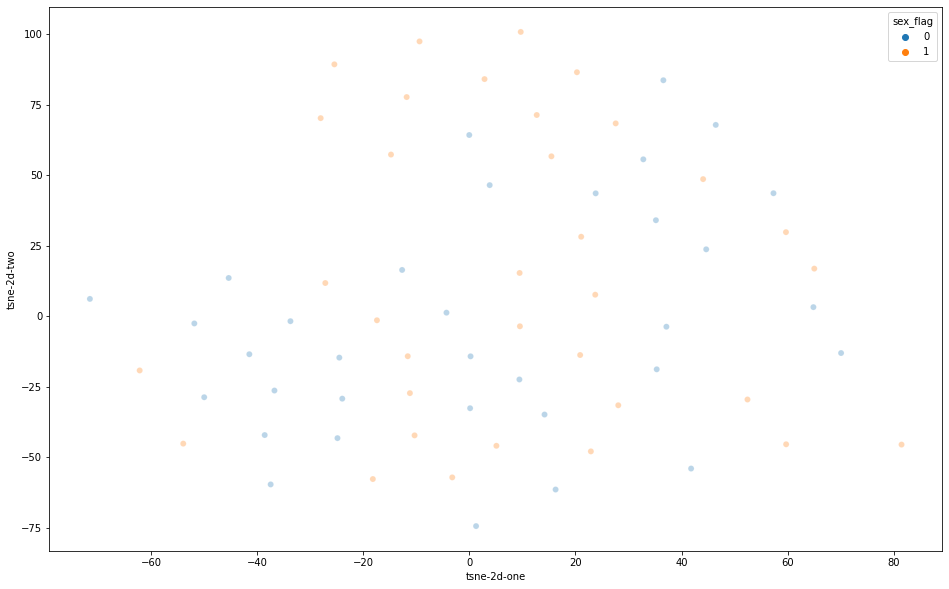

In [ ]:
del encoder_wu_valx, regressor_wu_valx, scanner_predictor_wu_valx, contrast_predictor_wu_valx
torch.cuda.empty_cache()

In [ ]:
validation_generator = Data.DataLoader(Dataset(train_learn_df, 1, True), batch_size=10,shuffle=False)

In [ ]:
encoder_wu_valx = Encoder().to("cuda")
regressor_wu_valx = Regressor().to("cuda")
scanner_predictor_wu_valx = DomainPredictor(nodes=3).to("cuda")
contrast_predictor_wu_valx = DomainPredictor(nodes=2).to("cuda")
sex_predictor_wu_valx = DomainPredictor(nodes=2).to("cuda")

In [ ]:
#checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/mri_harmonization/just_encoder_wu_214.pth')
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/mri_harmonization/scanner_unlearning_70.pth')
encoder_wu_valx.load_state_dict(checkpoint['encoder_wu_model'])
regressor_wu_valx.load_state_dict(checkpoint['regressor_wu_model'])
scanner_predictor_wu_valx.load_state_dict(checkpoint["scanner_predictor_wu"])
contrast_predictor_wu_valx.load_state_dict(checkpoint["contrast_predictor_wu"])

encoder_wu_valx.eval()
regressor_wu_valx.eval()
scanner_predictor_wu_valx.eval()
contrast_predictor_wu_valx.eval()

DomainPredictor(
  (domain): Sequential(
    (d_fc2): Linear(in_features=96, out_features=32, bias=True)
    (d_relu2): ReLU(inplace=True)
    (r_dropout): Dropout3d(p=0.2, inplace=False)
    (d_fc3): Linear(in_features=32, out_features=2, bias=True)
    (d_pred): Softmax(dim=1)
  )
)

In [ ]:
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/mri_harmonization/sex_unlearning_90.pth')
encoder_wu_valx.load_state_dict(checkpoint['encoder_wu_model'])
regressor_wu_valx.load_state_dict(checkpoint['regressor_wu_model'])
sex_predictor_wu_valx.load_state_dict(checkpoint["sex_predictor_wu"])

encoder_wu_valx.eval()
regressor_wu_valx.eval()
sex_predictor_wu_valx.eval()


DomainPredictor(
  (domain): Sequential(
    (d_fc2): Linear(in_features=96, out_features=32, bias=True)
    (d_relu2): ReLU(inplace=True)
    (r_dropout): Dropout3d(p=0.2, inplace=False)
    (d_fc3): Linear(in_features=32, out_features=2, bias=True)
    (d_pred): Softmax(dim=1)
  )
)

In [ ]:
def run_one_epoch_val( epoch = 1):
  batch_num = 0
  batch_size = 5
  embedding_dim = 96
  out_np = np.zeros((batch_size, embedding_dim))
  for X, Y, Z, A in validation_generator:
    X = X.to("cuda").float()
    Y = Y.to("cuda").float()
    Z = Z.to("cuda").long()
    A = A.to("cuda").long()
    # B = B.to("cuda").long()

    #print(X.shape)
    encoder_feats = encoder_wu_valx(X)

    #predicted_age = regressor_wou_val(encoder_feats)

    encoder_feats_cpu = encoder_feats.detach().to("cpu")
    encoder_feats_np = encoder_feats_cpu.numpy()

    predicted_age = regressor_wu_valx(encoder_feats)

    main_task_loss = regressor_loss_wou(Y, predicted_age)
    print(main_task_loss)

    #print(encoder_feats_np.shape)
    #print(batch_num * batch_size)

    del X, Y, Z, A, encoder_feats, encoder_feats_cpu

    out_np = np.append(out_np, encoder_feats_np, axis=0)

    batch_num = batch_num + 1    

    del encoder_feats_np
    torch.cuda.empty_cache()
    
    print("Batch_number: ", batch_num)
  
  return out_np

In [ ]:
epochs = 1
for e in range(epochs):
  mynp = run_one_epoch_val(epoch=e)

tensor(225.9996, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  1
tensor(136.1452, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  2
tensor(331.3570, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  3
tensor(232.8692, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  4
tensor(239.2343, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  5
tensor(270.3291, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  6
tensor(203.0782, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  7
tensor(212.3971, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  8
tensor(221.3757, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  9
tensor(240.5345, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  10
tensor(177.4473, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  11
tensor(193.1498, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  12
tensor(357.1077, device='cuda:0', grad_fn=<MseLossBackward>)


In [ ]:
epochs = 1
for e in range(epochs):
  mynp = run_one_epoch_val(epoch=e)

tensor(112.1220, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  1
tensor(82.4877, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  2
tensor(224.0690, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  3
tensor(202.3841, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  4


In [ ]:
epochs = 1
for e in range(epochs):
  mynp = run_one_epoch_val(epoch=e)

tensor(225.9996, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  1
tensor(136.1452, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  2
tensor(331.3570, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  3
tensor(232.8692, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  4
tensor(239.2343, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  5
tensor(270.3291, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  6
tensor(203.0782, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  7
tensor(212.3971, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  8
tensor(221.3757, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  9
tensor(240.5345, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  10
tensor(177.4473, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  11
tensor(193.1498, device='cuda:0', grad_fn=<MseLossBackward>)
Batch_number:  12
tensor(357.1077, device='cuda:0', grad_fn=<MseLossBackward>)


In [ ]:
mynp1 = mynp[5:, :]
df_subset = pd.DataFrame(mynp1)

In [ ]:
df_subset.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,23.008112,0.0,20.537962,0.0,26.208889,12.304988,0.0,24.450846,46.203918,24.298786,32.945648,18.838902,0.0,0.0,40.743149,0.0,35.027737,0.0,0.0,50.373138,23.641758,0.0,45.420757,0.0,0.0,3.538807,12.975589,22.209726,0.0,0.0,7.118945,0.0,33.264526,6.726375,30.103729,37.309708,33.739758,12.947130,31.441935,0.0,...,17.898357,0.0,13.438631,35.210018,11.715356,10.426527,6.028967,0.0,25.990820,35.910423,4.330492,0.0,0.0,0.0,14.539721,0.0,0.0,0.0,0.0,0.0,39.746807,0.0,0.0,0.0,28.462570,43.965286,35.134418,0.0,14.024339,0.0,0.0,45.309334,42.924324,0.0,0.0,3.311195,28.026884,4.851478,4.030828,19.827776
1,23.299959,0.0,20.565384,0.0,26.291979,12.555282,0.0,24.815580,46.734344,24.456560,33.374474,19.220716,0.0,0.0,41.231064,0.0,35.544281,0.0,0.0,50.749287,23.823111,0.0,46.017448,0.0,0.0,3.353788,12.827706,22.737831,0.0,0.0,7.097113,0.0,33.753078,6.642749,30.581280,37.779404,34.223507,12.810034,31.951927,0.0,...,18.020941,0.0,13.763574,35.469929,12.133352,10.351067,5.878038,0.0,26.370211,36.282902,4.212663,0.0,0.0,0.0,15.017399,0.0,0.0,0.0,0.0,0.0,40.186058,0.0,0.0,0.0,28.808178,44.184734,35.440155,0.0,14.214286,0.0,0.0,45.658707,43.229626,0.0,0.0,3.354366,28.105867,4.910360,4.048804,19.939320
2,24.894405,0.0,21.531071,0.0,27.249693,13.567854,0.0,24.965282,47.034477,26.709652,33.852371,20.636091,0.0,0.0,42.273018,0.0,36.696987,0.0,0.0,52.627472,23.914301,0.0,46.105541,0.0,0.0,4.218012,13.052251,23.535616,0.0,0.0,6.972932,0.0,35.356445,6.987463,31.551651,38.412556,36.066433,12.696695,32.890324,0.0,...,18.427914,0.0,15.534067,36.941242,12.284708,10.456102,6.456004,0.0,27.712387,37.935402,4.008958,0.0,0.0,0.0,14.573001,0.0,0.0,0.0,0.0,0.0,42.140816,0.0,0.0,0.0,29.725424,45.066872,36.109509,0.0,14.064144,0.0,0.0,47.802494,45.455929,0.0,0.0,3.637028,28.819580,4.998725,4.426853,21.352884
3,23.252403,0.0,20.287489,0.0,25.973894,12.463723,0.0,24.227009,45.798916,24.420670,32.474518,18.953245,0.0,0.0,40.772442,0.0,34.859734,0.0,0.0,49.966312,23.403860,0.0,45.535999,0.0,0.0,3.471654,13.283763,22.121592,0.0,0.0,6.520416,0.0,32.979225,6.629872,30.697908,37.404774,33.648758,12.656116,31.253277,0.0,...,17.431036,0.0,13.404289,35.297585,11.661697,9.982183,6.267291,0.0,26.164490,35.689907,4.371583,0.0,0.0,0.0,14.137422,0.0,0.0,0.0,0.0,0.0,39.522789,0.0,0.0,0.0,28.270092,43.011623,35.064175,0.0,13.725126,0.0,0.0,45.205177,42.652397,0.0,0.0,3.801031,27.512302,4.937697,4.056804,20.038639
4,23.533041,0.0,20.924877,0.0,26.269106,12.661771,0.0,24.788904,46.779114,24.807699,33.088230,19.058083,0.0,0.0,41.398705,0.0,35.023624,0.0,0.0,50.549477,23.892288,0.0,45.708279,0.0,0.0,3.758020,13.206143,22.393959,0.0,0.0,7.023778,0.0,33.526958,6.583091,30.560562,37.559643,34.408672,12.789890,32.042862,0.0,...,17.842266,0.0,13.286469,35.753956,11.874985,10.488391,6.202900,0.0,25.854185,36.129612,4.146349,0.0,0.0,0.0,14.673053,0.0,0.0,0.0,0.0,0.0,40.360664,0.0,0.0,0.0,28.726458,44.247467,35.410683,0.0,14.001875,0.0,0.0,45.654243,43.007446,0.0,0.0,3.626453,28.530182,4.479080,4.199944,20.417694
5,22.842999,0.0,20.342907,0.0,25.334038,12.469906,0.0,23.487913,45.337784,24.121202,32.684498,18.687023,0.0,0.0,39.034283,0.0,34.678047,0.0,0.0,49.996548,22.706699,0.0,43.675484,0.0,0.0,3.694435,12.638456,21.872713,0.0,0.0,6.904865,0.0,32.701393,6.510374,29.645163,36.822182,33.668755,12.649285,30.758059,0.0,...,17.682796,0.0,13.699949,34.343128,11.586011,10.231327,5.648992,0.0,25.983740,35.393524,4.702625,0.0,0.0,0.0,13.893033,0.0,0.0,0.0,0.0,0.0,39.976746,0.0,0.0,0.0,28.298670,42.744385,34.485962,0.0,13.979588,0.0,0.0,44.374020,42.177486,0.0,0.0,3.142490,27.656137,4.641083,3.942449,18.965910
6,22.688549,0.0,20.313652,0.0,25.715084,12.531715,0.0,23.546700,44.983517,24.029823,31.168879,18.590714,0.0,0.0,39.611427,0.0,33.673935,0.0,0.0,48.439442,22.306871,0.

In [ ]:
train_learn_df.reset_index(inplace=True)
validation_df.reset_index(inplace=True)

In [ ]:
result = pd.merge(left=train_learn_df, right=df_subset, how="inner", left_index=True, right_index=True, validate="one_to_one")

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)

In [ ]:
tsne_results = tsne.fit_transform(mynp1)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 1.554634
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.082771
[t-SNE] KL divergence after 500 iterations: 0.255432
t-SNE done! Time elapsed: 1.91591215133667 seconds


In [ ]:
df_subset = pd.DataFrame(tsne_results, columns = ['tsne-2d-one','tsne-2d-two'])

In [ ]:
result["tsne-2d-one"] = tsne_results[:, 0]
result["tsne-2d-two"] = tsne_results[:, 1]

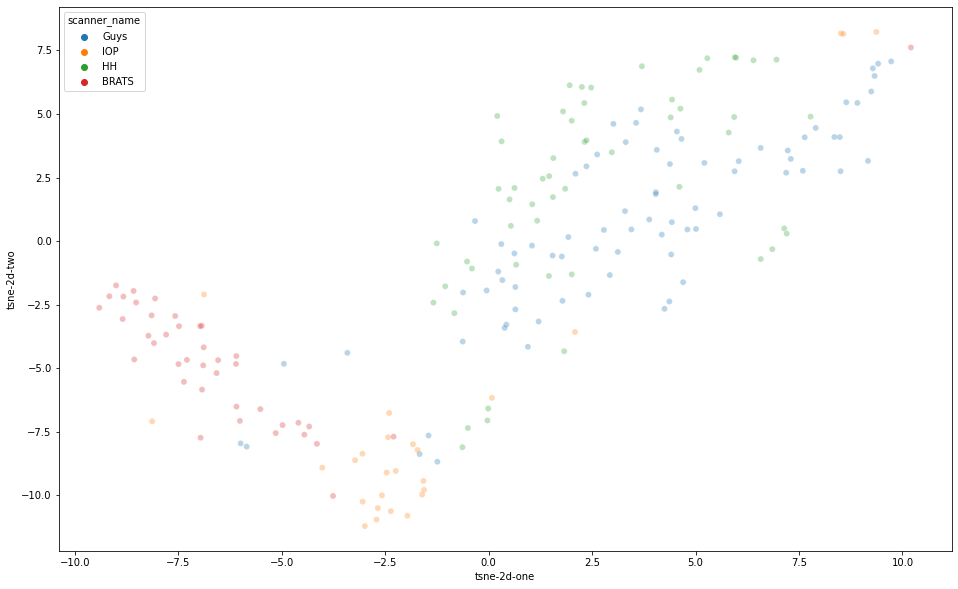

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "scanner_name", data=result, legend="full", alpha=0.3)

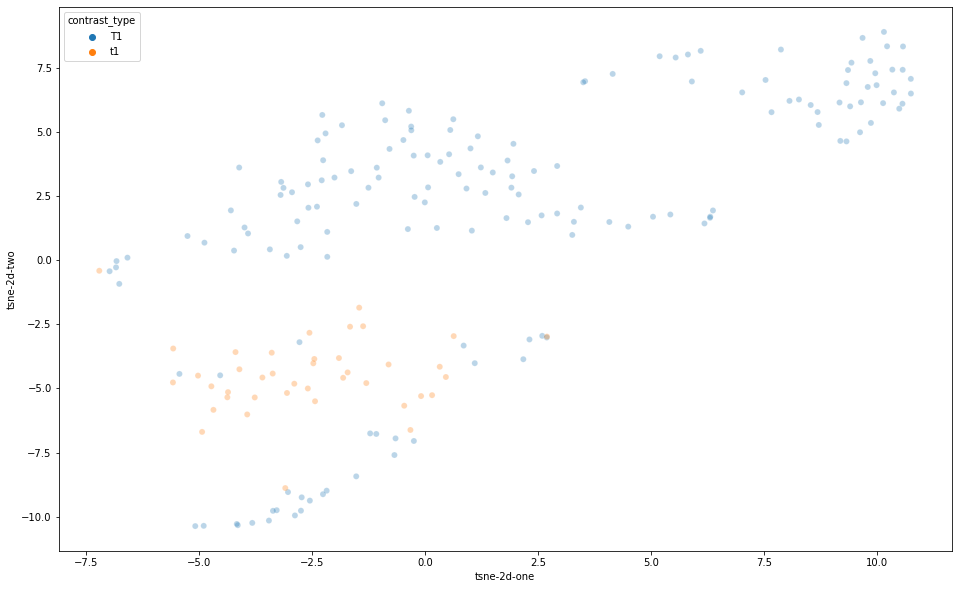

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type", data=result, legend="full", alpha=0.3)

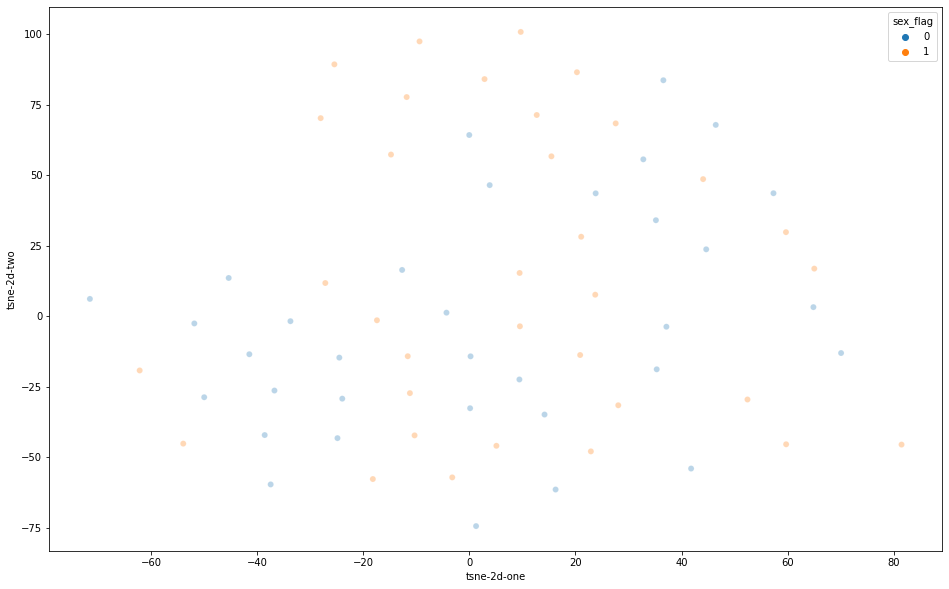

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "sex_flag", data=result, legend="full", alpha=0.3)

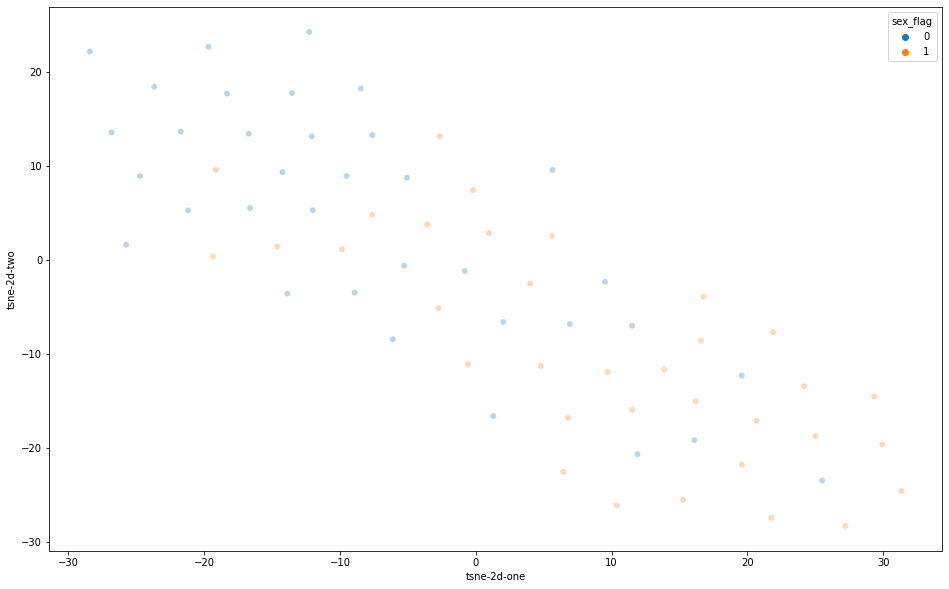

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "sex_flag", data=result, legend="full", alpha=0.3)

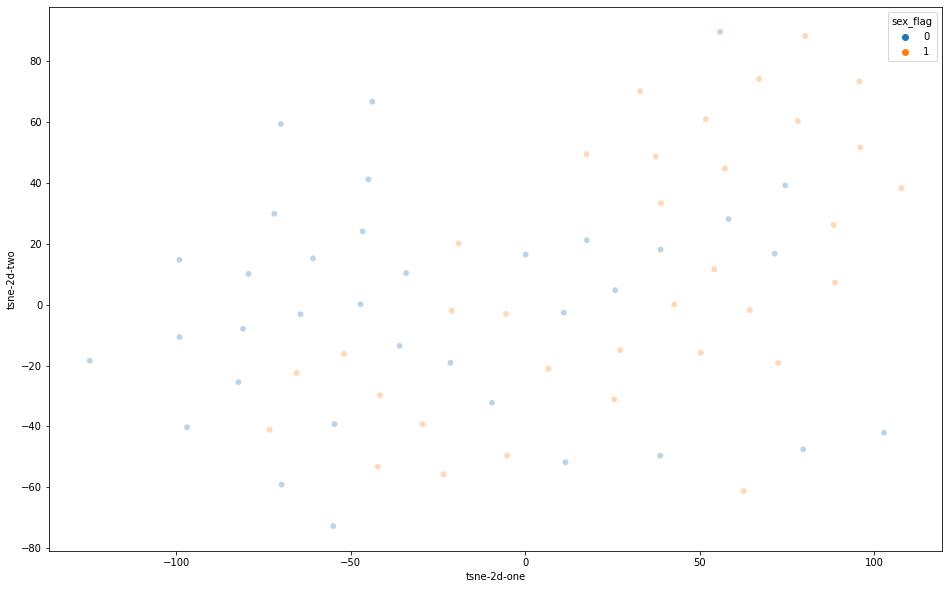

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "sex_flag", data=result, legend="full", alpha=0.3)

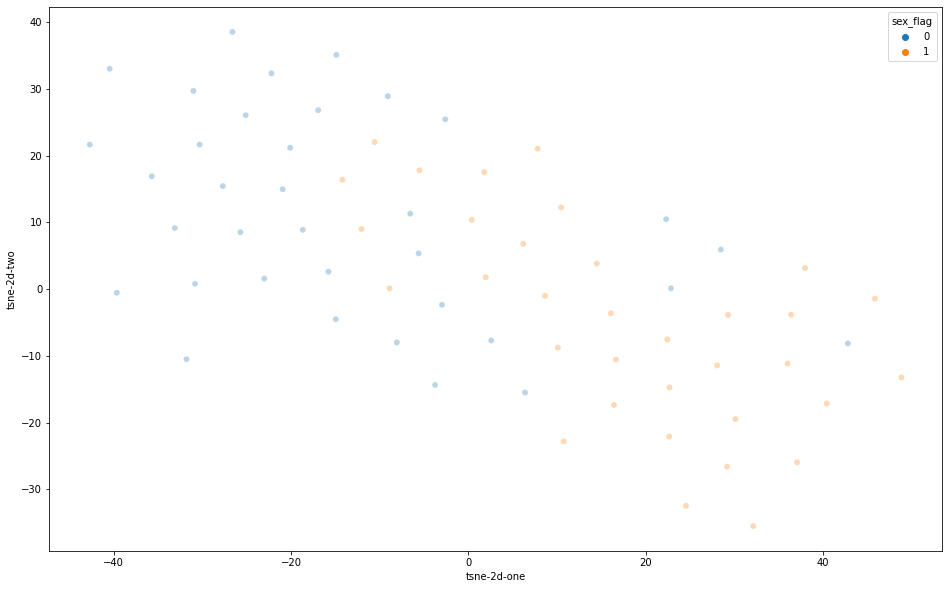

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "sex_flag", data=result, legend="full", alpha=0.3)

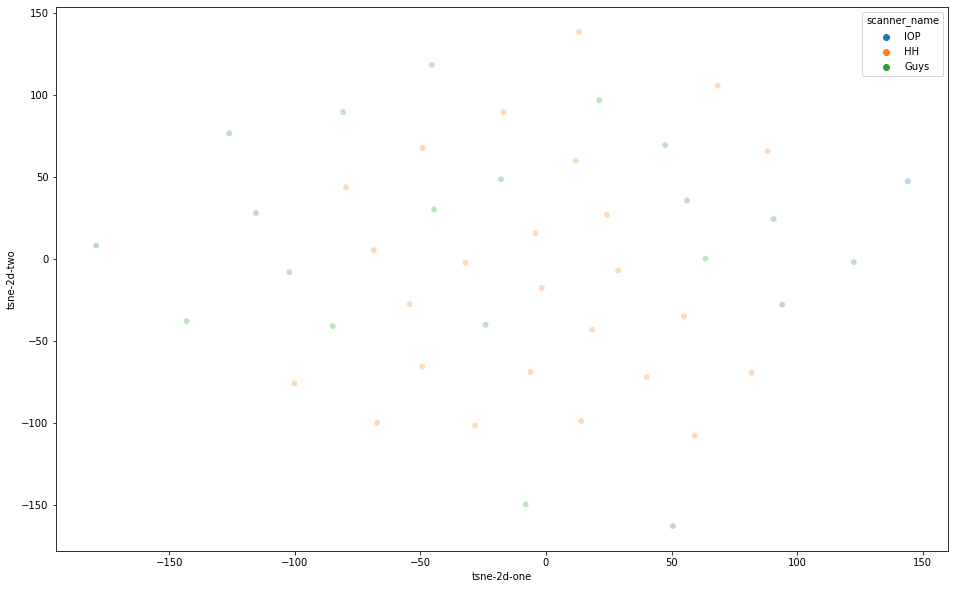

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "scanner_name", data=result, legend="full", alpha=0.3)

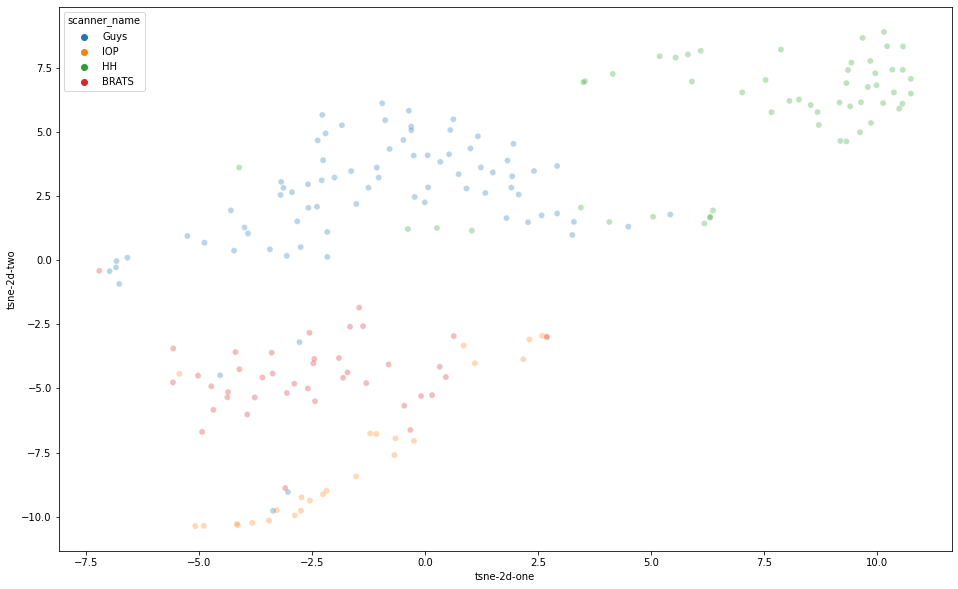

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "scanner_name", data=result, legend="full", alpha=0.3)

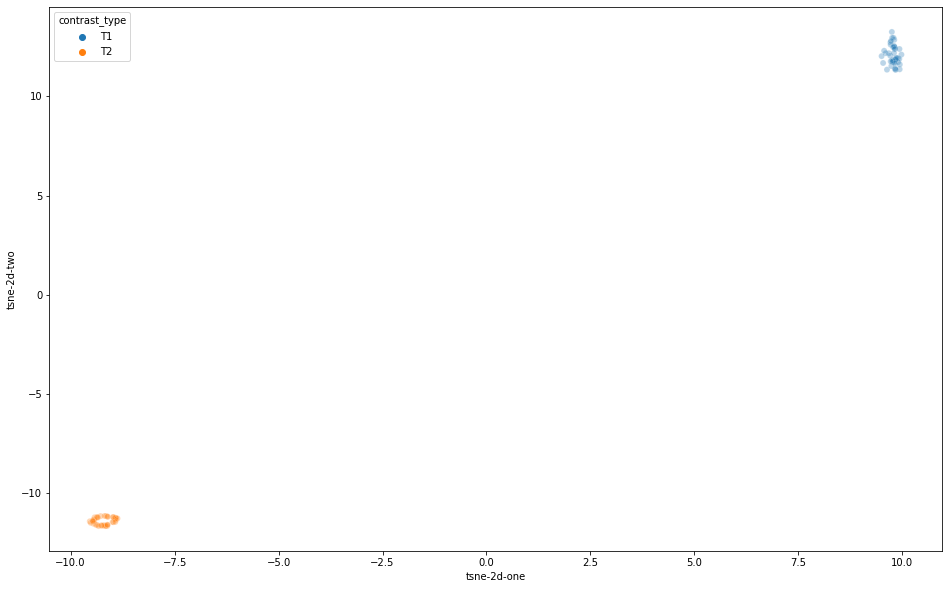

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type", data=result, legend="full", alpha=0.3)

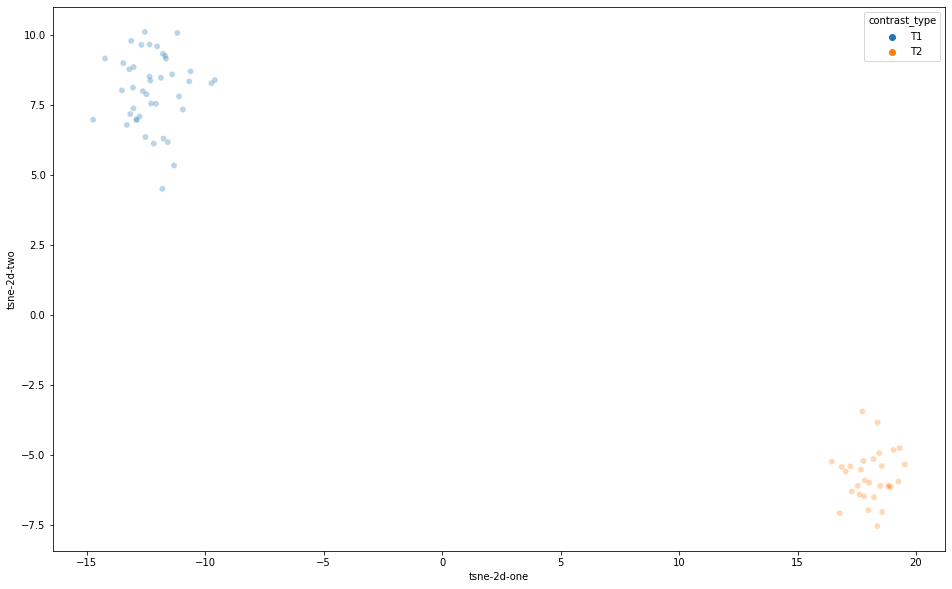

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type", data=result, legend="full", alpha=0.3)

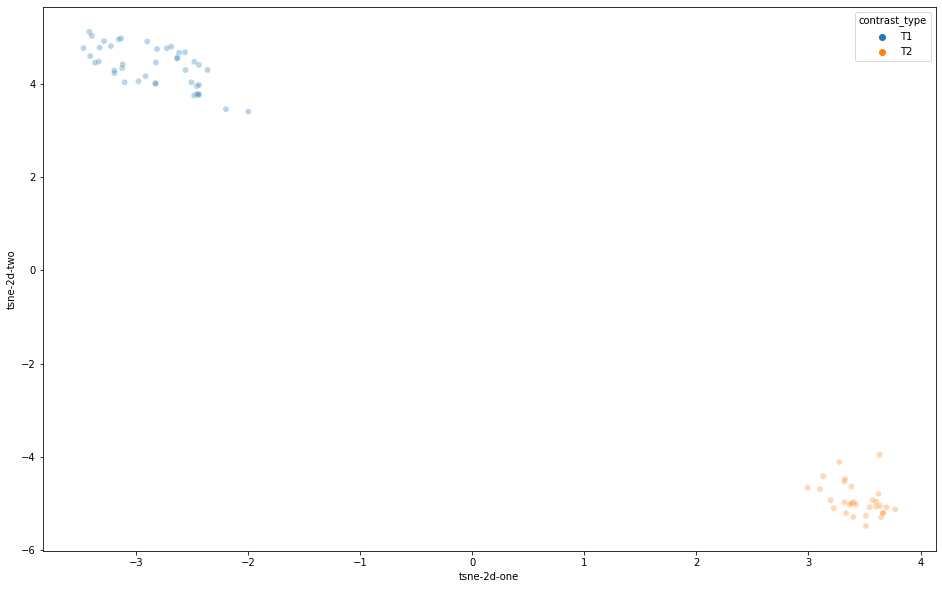

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type", data=result, legend="full", alpha=0.3)

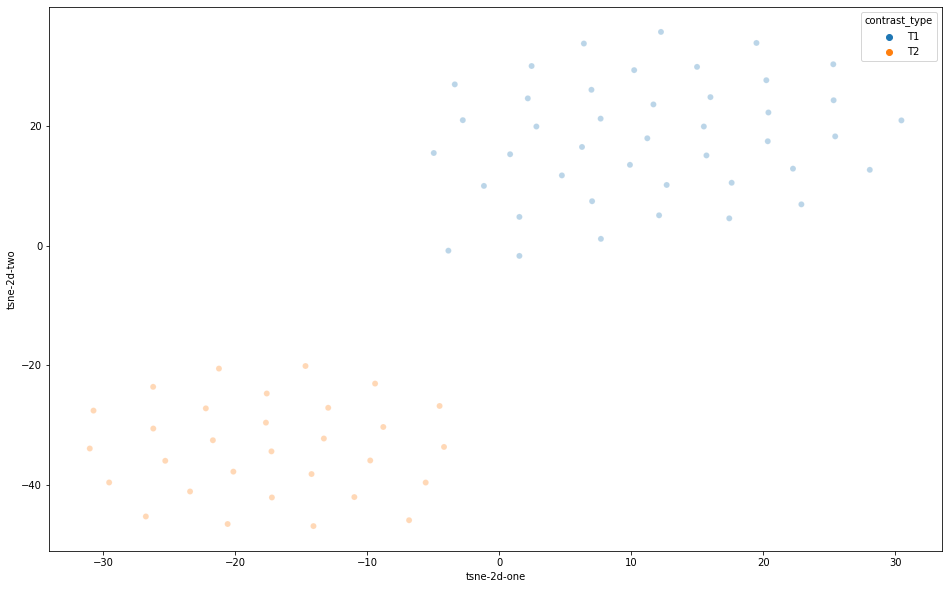

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type", data=result, legend="full", alpha=0.3)

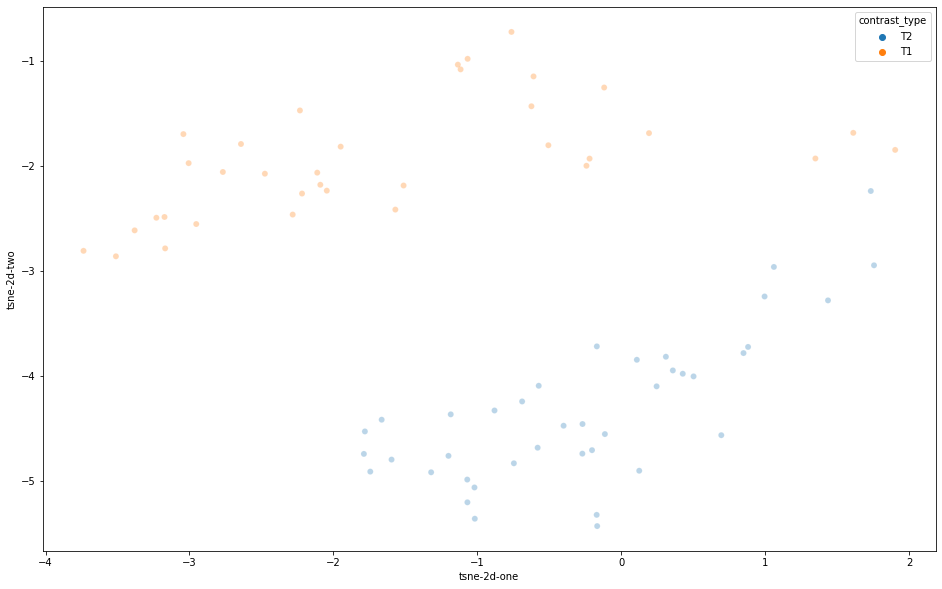

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type", data=result, legend="full", alpha=0.3)

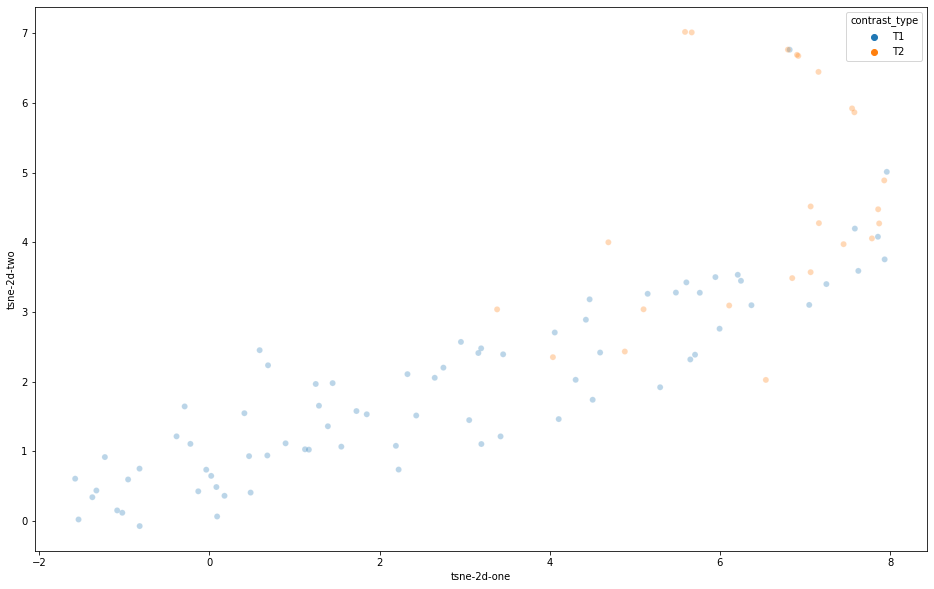

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type", data=result, legend="full", alpha=0.3)

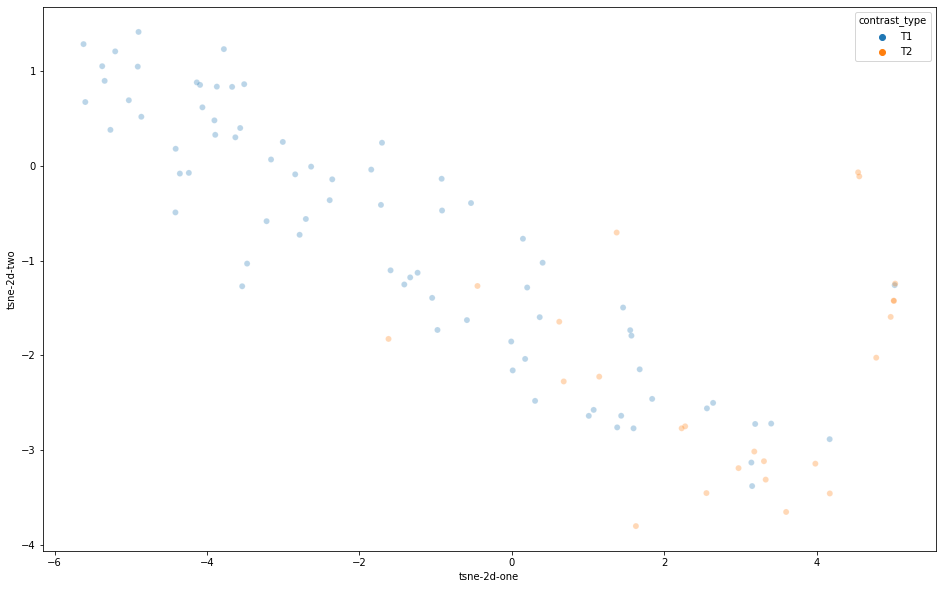

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type", data=result, legend="full", alpha=0.3)

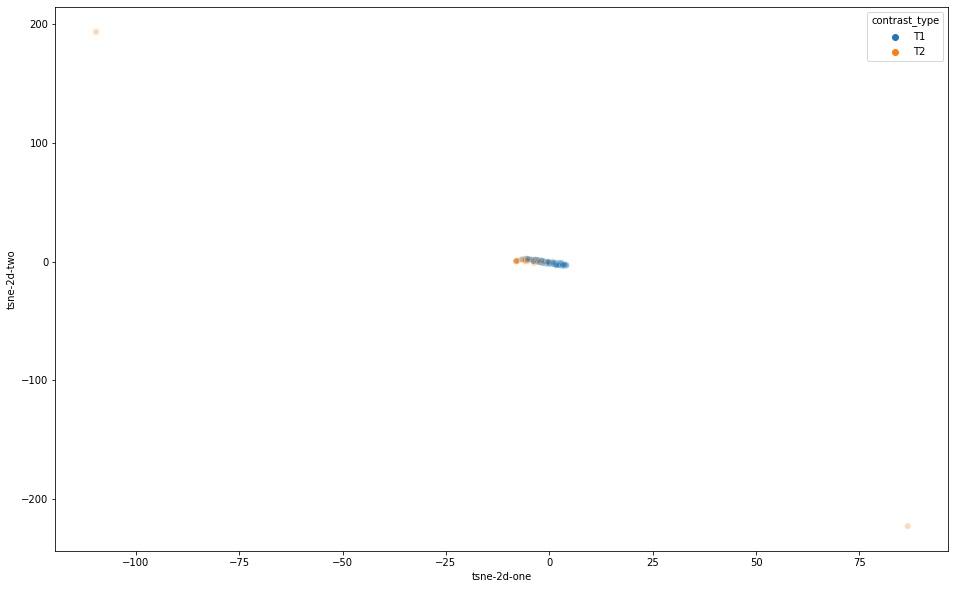

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type", data=result, legend="full", alpha=0.3)

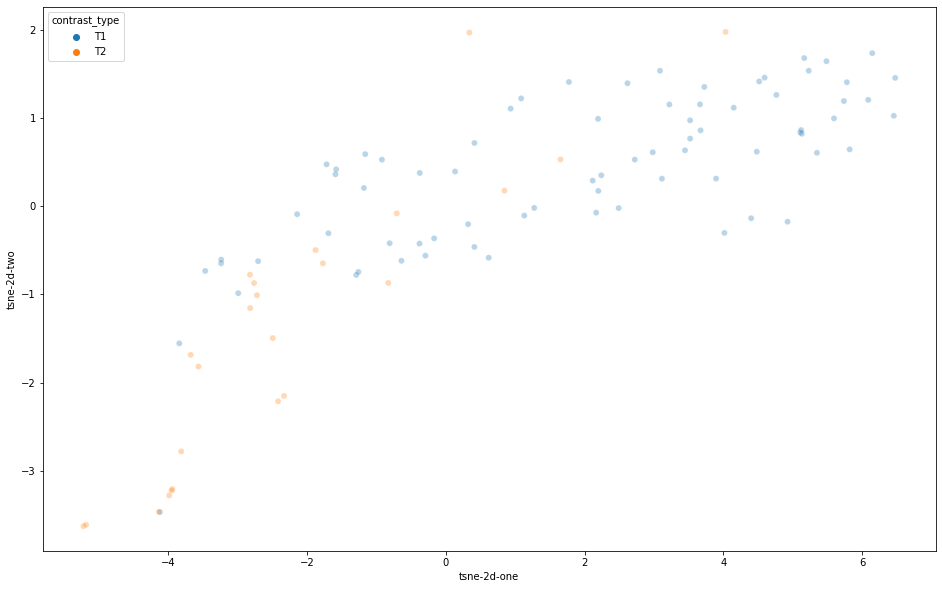

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type", data=result, legend="full", alpha=0.3)

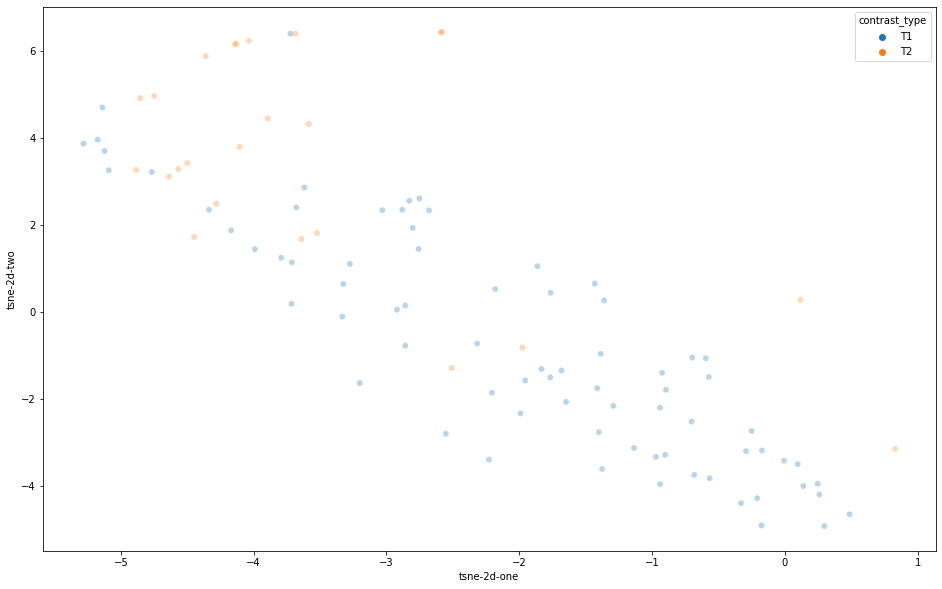

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

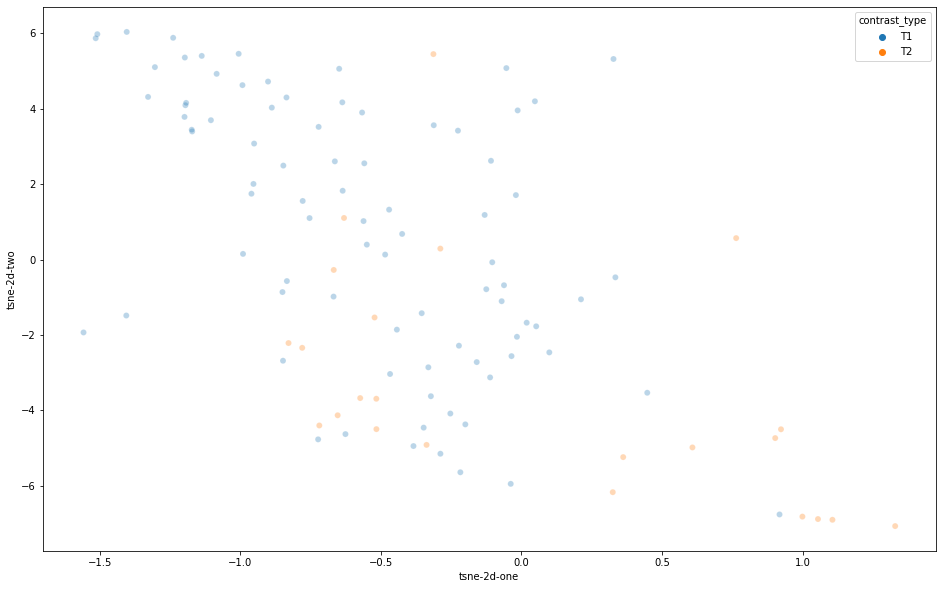

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

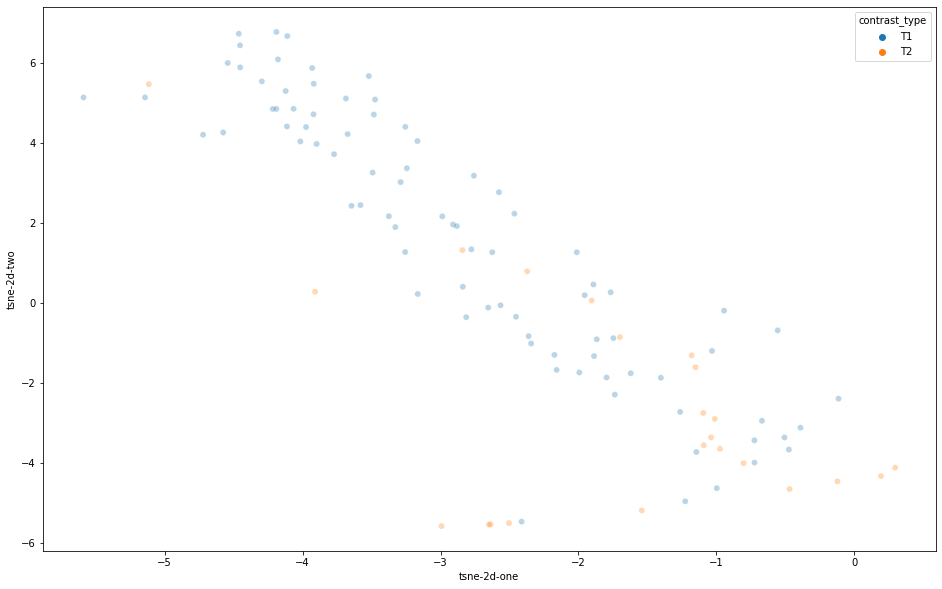

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

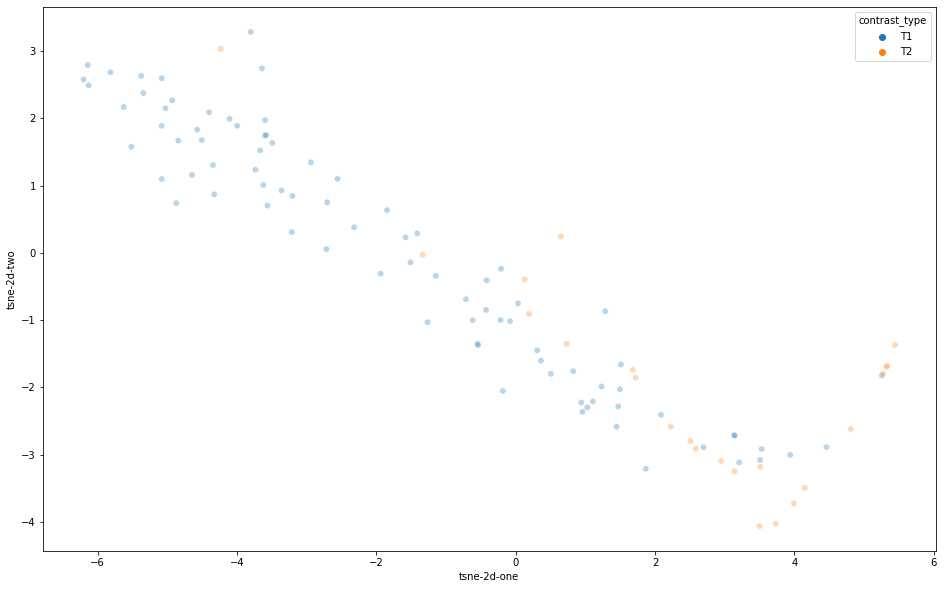

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

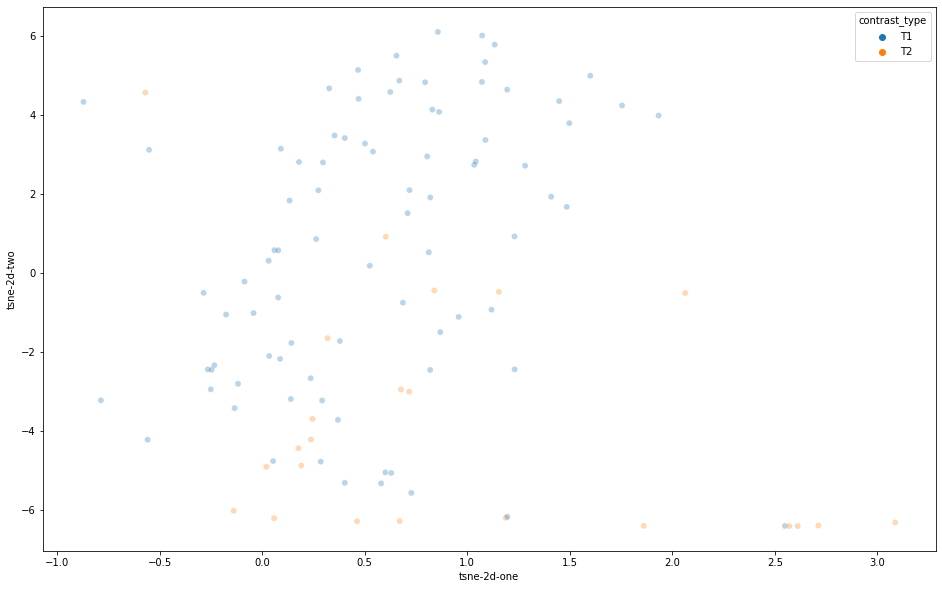

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

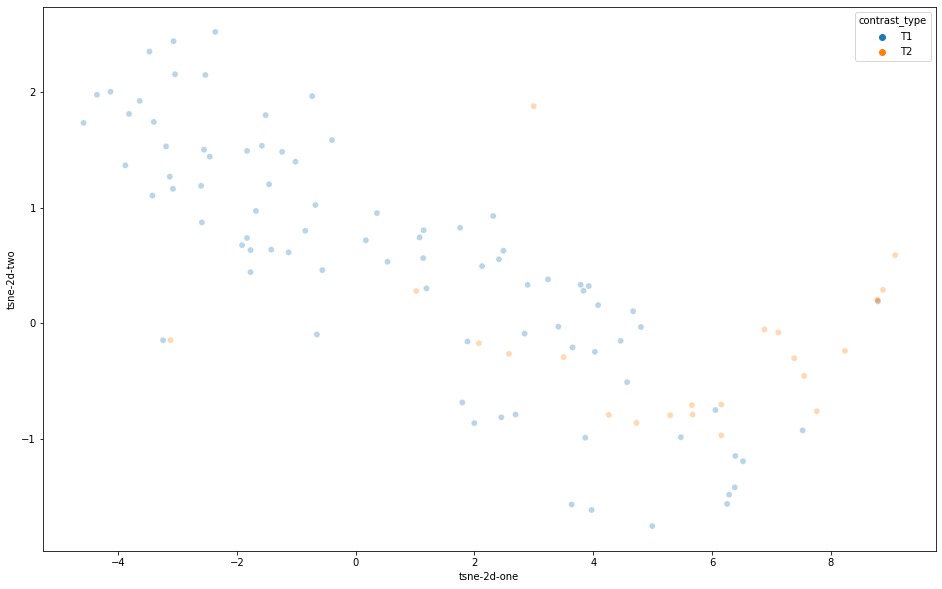

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

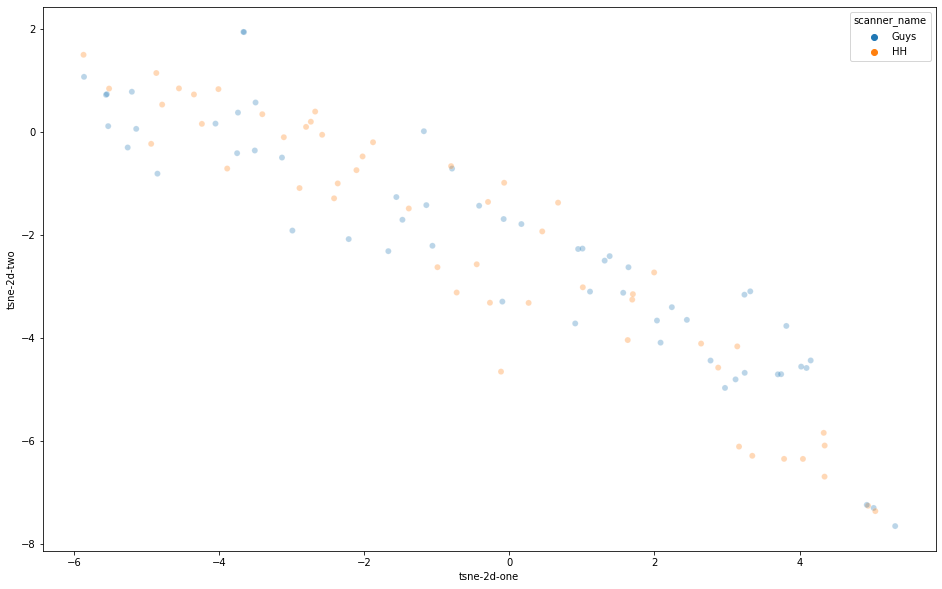

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "scanner_name",
    data=result,
    legend="full",
    alpha=0.3)

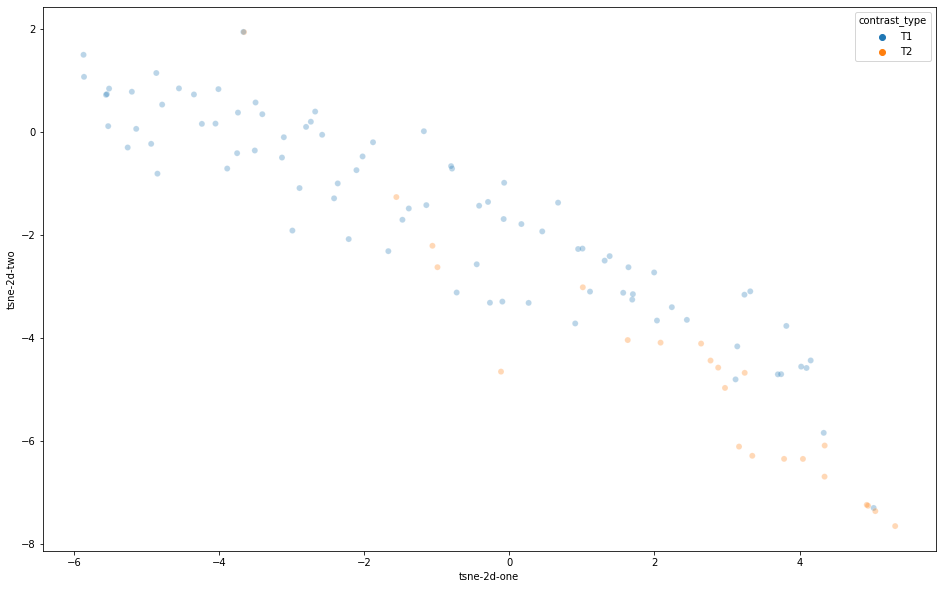

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

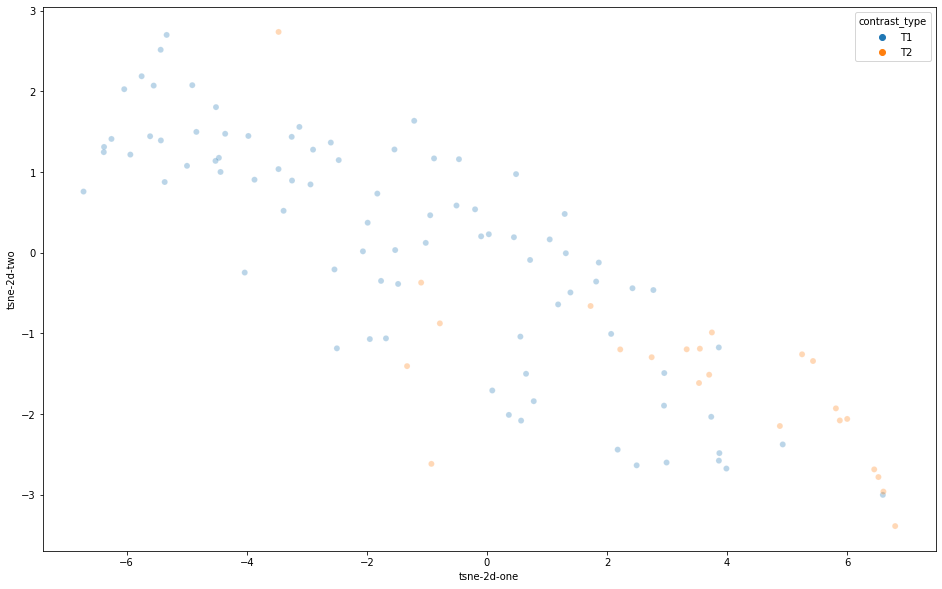

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

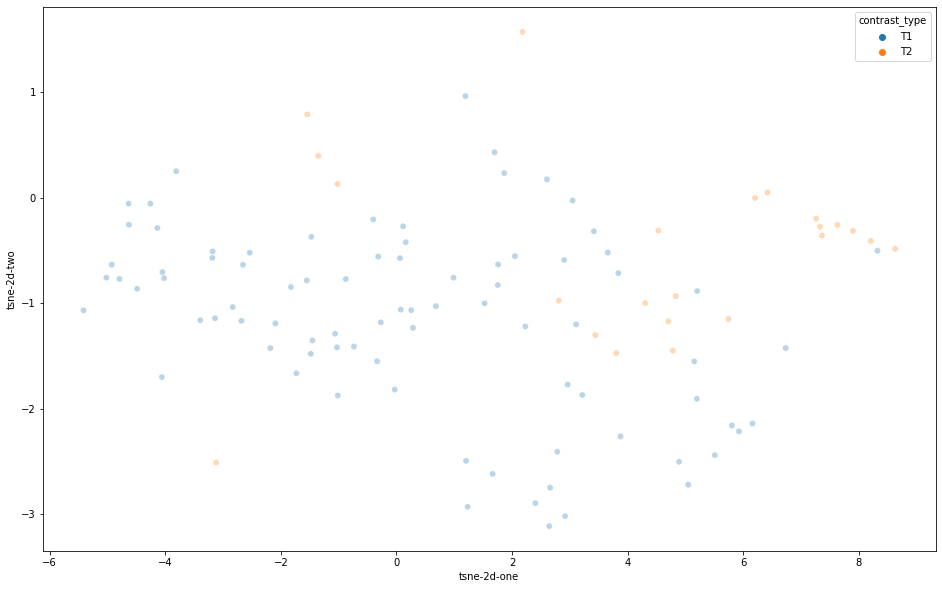

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

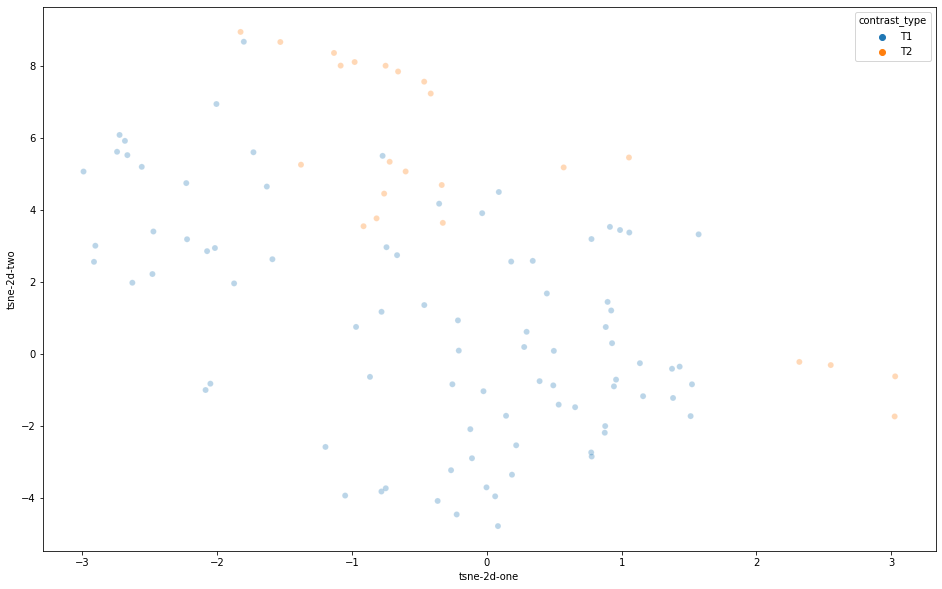

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

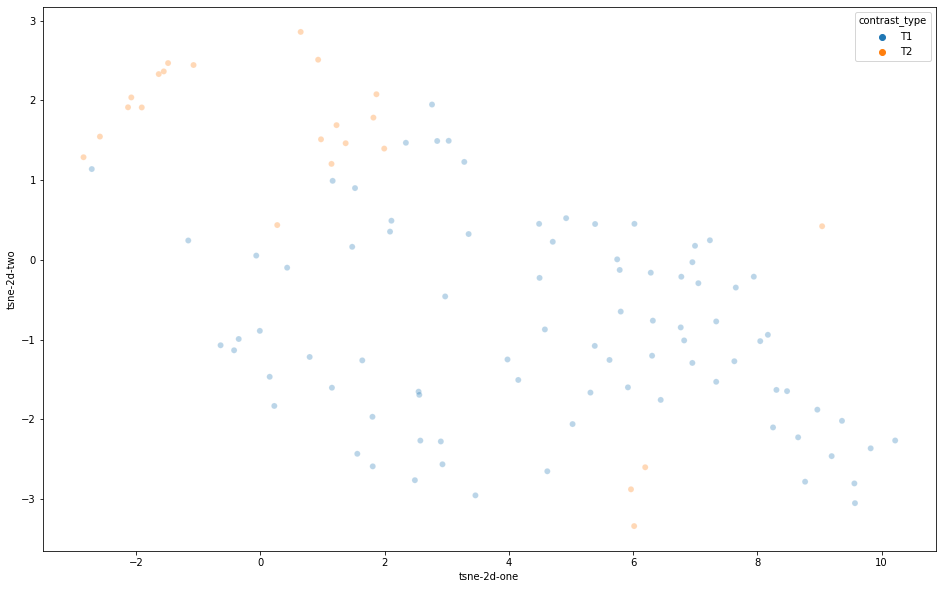

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

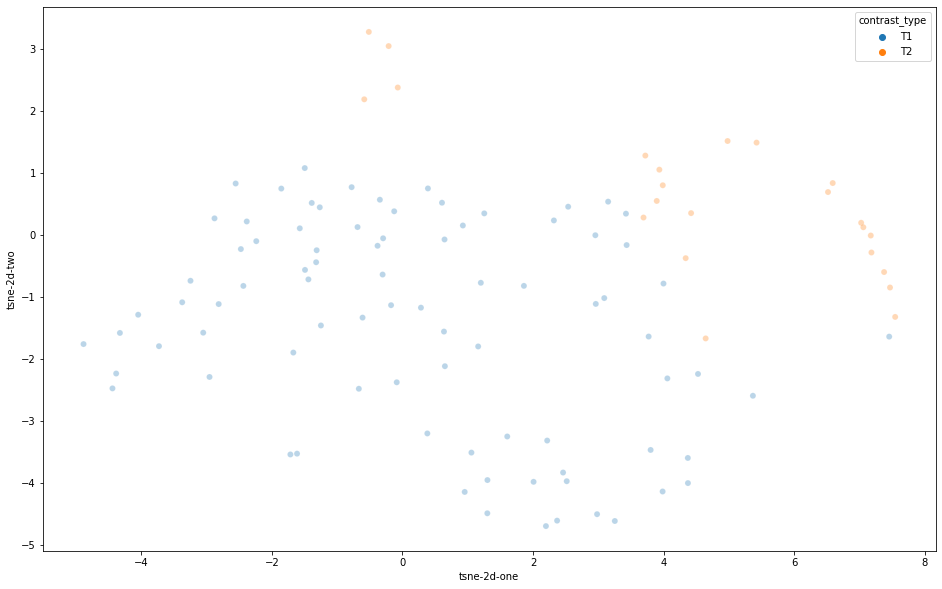

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

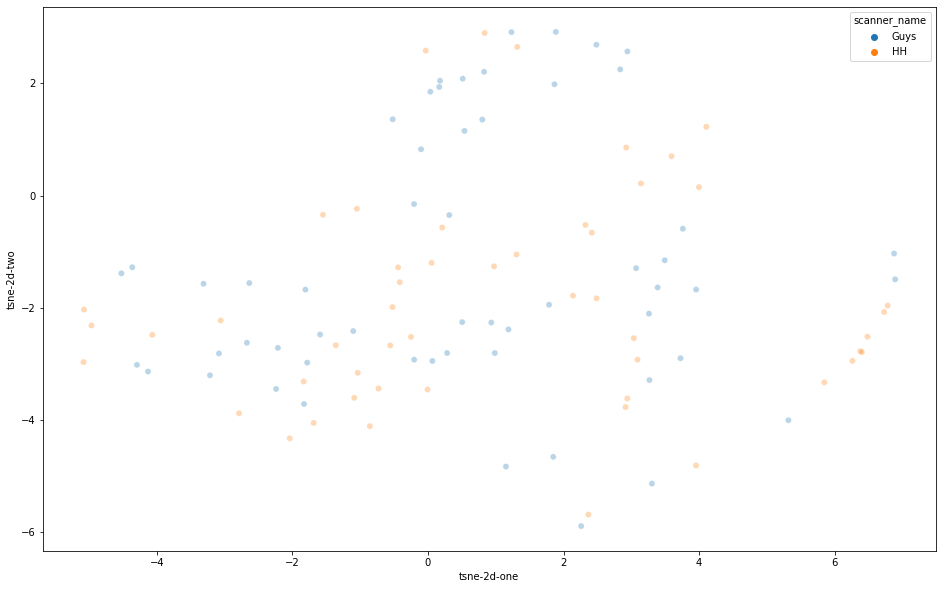

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "scanner_name",
    data=result,
    legend="full",
    alpha=0.3)

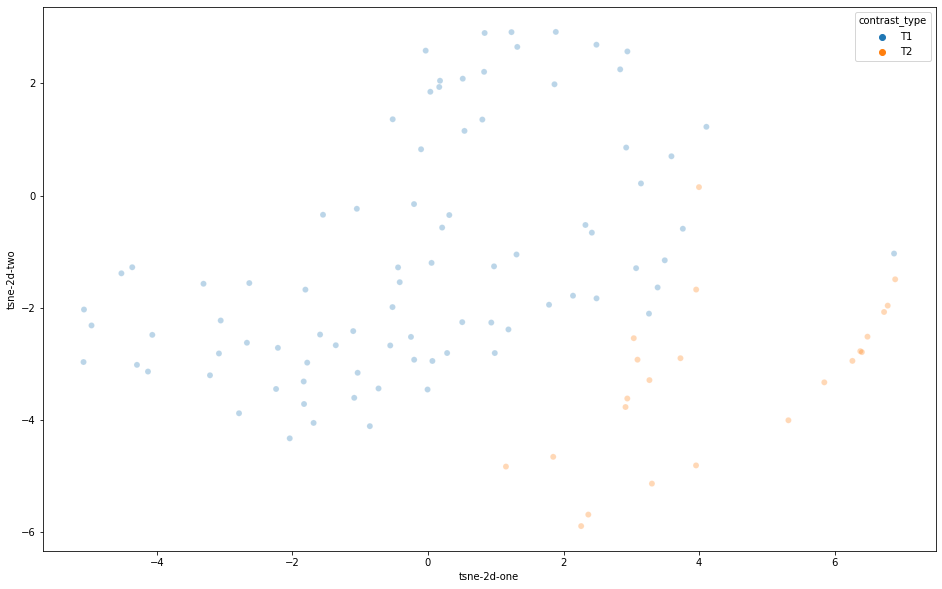

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

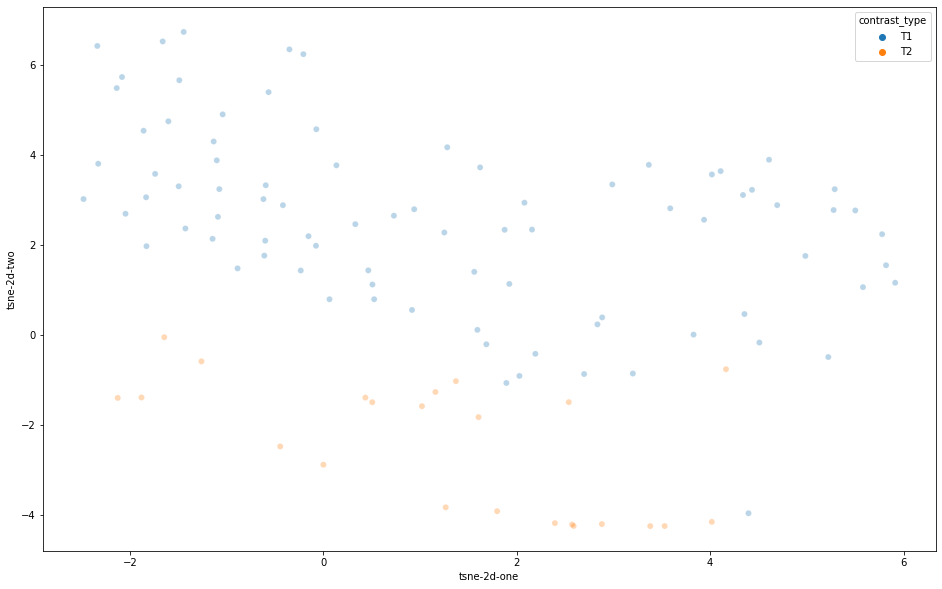

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

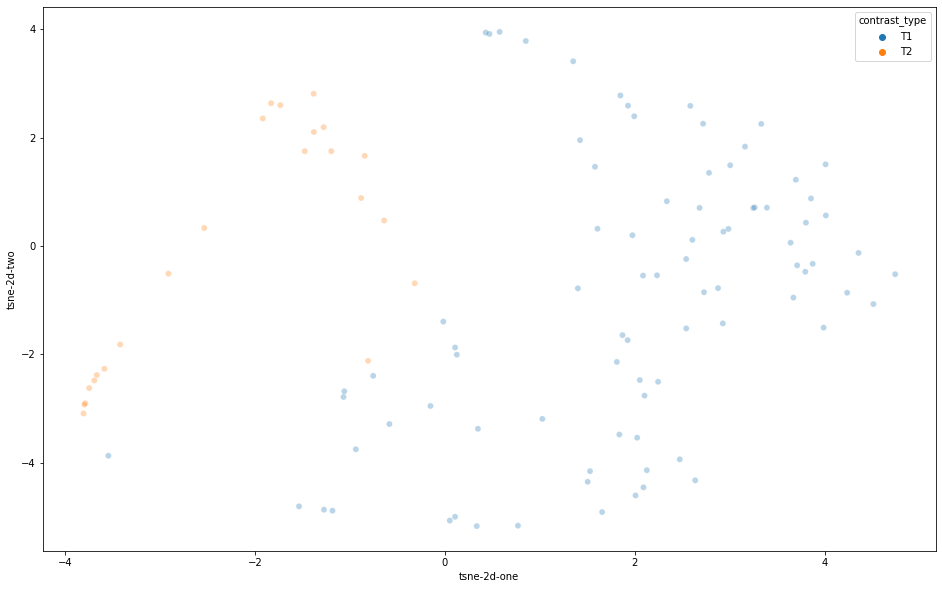

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

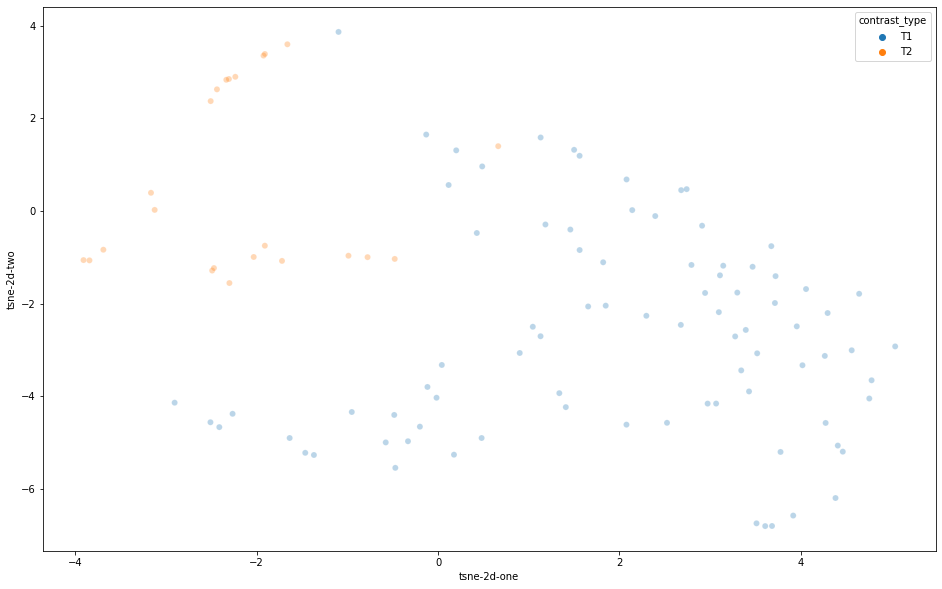

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

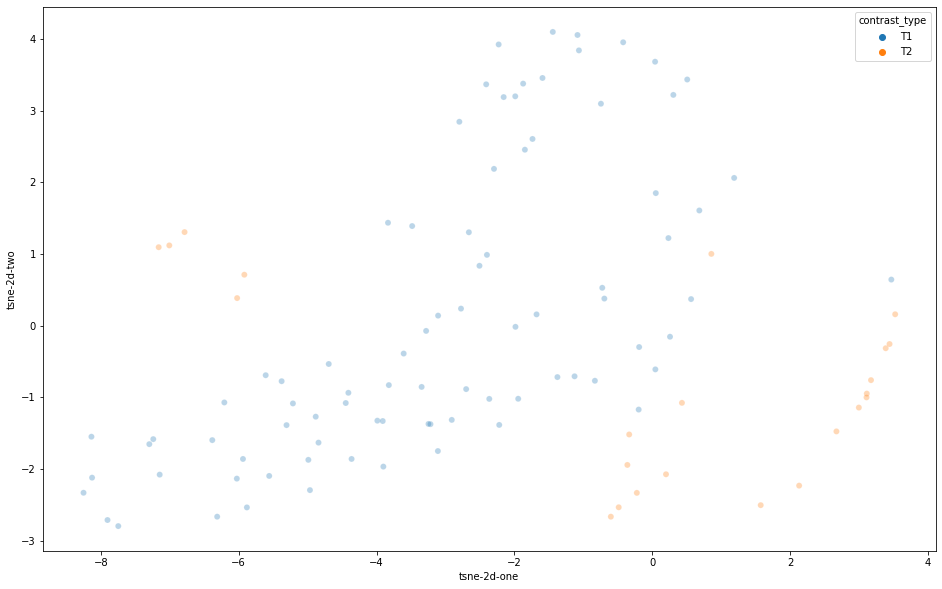

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)

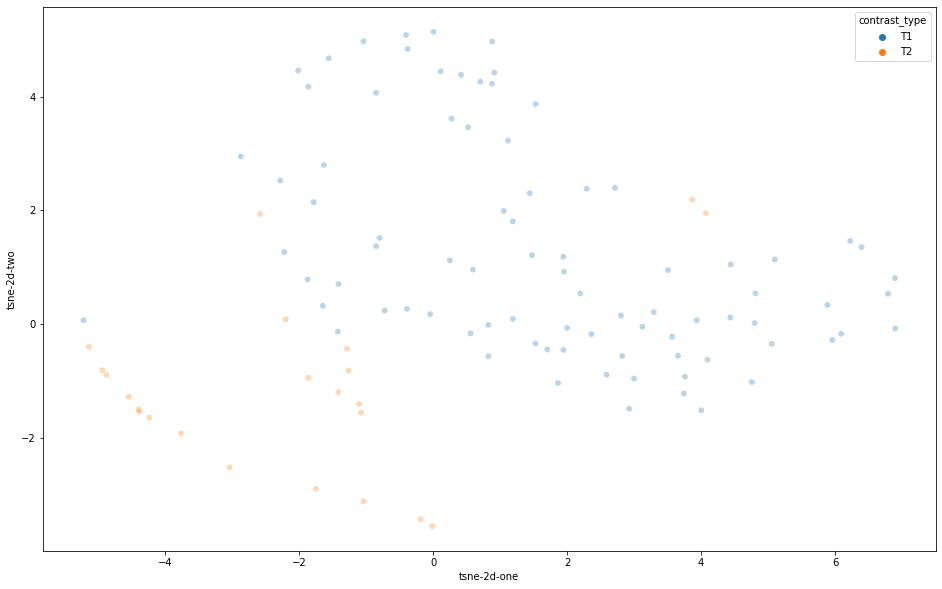

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "contrast_type",
    data=result,
    legend="full",
    alpha=0.3)